In [9]:
!git clone https://github.com/ashleve/lightning-hydra-template
!cd lightning-hydra-template
!pip install -r /content/lightning-hydra-template/requirements.txt
!pip install kornia
!pip install kornia[x]
import kornia

fatal: destination path 'lightning-hydra-template' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.3 MB 19 kB/s 
  Using cached torchvision-0.13.0-cp37-cp37m-manylinux1_x86_64.whl (19.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.9.1
    Uninstalling torchvision-0.9.1:
      Successfully uninstalled torchvision-0.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.12.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.12.0 which is i

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import kornia
from torchmetrics.functional import accuracy
#from differentiable_augmentations import * 

In [2]:
class LitClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(3, 6, 5), 
                                     nn.MaxPool2d(2, 2), 
                                     nn.Conv2d(6, 16, 5), 
                                     nn.Flatten(), 
                                     nn.Linear(1600, 120), 
                                     nn.Linear(120, 256), 
                                     nn.Linear(256, 10))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        z = self.encoder(x)
        #x_hat = self.decoder(z)
        loss = F.cross_entropy(z, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.encoder(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
    
    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/content/drive/MyDrive/cifar10thesis",
    filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [45000, 5000])

classifier = LitClassifier()
trainer = pl.Trainer(callbacks=[checkpoint_callback],accelerator='gpu', devices=1)
#trainer.fit(classifier, DataLoader(train), DataLoader(val))

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
! pip install --quiet "torch>=1.6, <1.9" "torchmetrics>=0.3" "lightning-bolts" "pytorch-lightning>=1.3" "torchvision"
import torchvision

     |████████████████████████████████| 804.1 MB 2.8 kB/s 
     |████████████████████████████████| 316 kB 68.4 MB/s 
     |████████████████████████████████| 19.1 MB 1.0 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 70.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.1 MB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 17.4 MB 838 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.


In [24]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)
trainer.test(classifier, cifar10_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:61: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:65: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:69: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


Files already downloaded and verified
Files already downloaded and verified


Missing logger folder: /content/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.09019999951124191    │
│         test_loss         │   -0.00318220560438931    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.09019999951124191, 'test_loss': -0.00318220560438931}]

In [ ]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)
trainer.test(classifier, cifar10_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:61: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:65: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:69: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.31779998540878296    │
│         test_loss         │     -7.84668493270874     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.31779998540878296, 'test_loss': -7.84668493270874}]

In [26]:
model2 = classifier.load_from_checkpoint('/content/drive/MyDrive/cifar10thesis/sample-mnist-epoch=03-val_loss=1.71.ckpt')

In [29]:
trainer.test(model2, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3635999858379364     │
│         test_loss         │    -7.706151485443115     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.3635999858379364, 'test_loss': -7.706151485443115}]

In [41]:
trainer.test(classifier, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4081999957561493     │
│         test_loss         │    -2.3352742195129395    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.4081999957561493, 'test_loss': -2.3352742195129395}]

In [72]:
trainer.test(classifier, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1152999997138977     │
│         test_loss         │    0.9259307384490967     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.1152999997138977, 'test_loss': 0.9259307384490967}]

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Differentiable Patch Gaussian and other functions

In [11]:
def valid(z,himg,wimg):
  print(z)
  if(z[0]+z[1]>=himg or z[0]>=wimg or z[0]<=0 or z[2]+z[3]>=himg or z[2]>=himg or z[2]<=0):
    return False
  else:
    return True

In [76]:
from torch.distributions.normal import Normal
def differentiable_rotation2(image_batch, angle):
    image_batch = image_batch.expand(image_batch.shape[0],3,32,32)
    #angle = torch.ones(image_batch.cpu().shape[0], device=device) * angle
    angle =  angle.squeeze()

    # define the rotation center
    center = torch.ones(image_batch.shape[0], 2)
    center = center.to(device)
    center[..., 0] = image_batch.shape[3] / 2  # x
    center[..., 1] = image_batch.shape[2] / 2  # y

    # define the scale factor
    scale = torch.ones(image_batch.shape[0],2)
    scale = scale.to(device)

    # compute the transformation matrix
    M = kornia.geometry.transform.get_rotation_matrix2d(center, angle, scale)

    # apply the transformation to original image

    _, _, h, w = image_batch.shape
    rotated_image_batch = kornia.geometry.transform.warp_affine(image_batch, M, dsize=(h, w))
    return rotated_image_batch

def differentiable_crop_translation_scale(image_batch, angle):
    grid = F.affine_grid(angle, (image_batch.shape[0], 3, 32, 32))
    image_batch = F.grid_sample(image_batch, grid)
    return image_batch

def differentiable_gaussian_blur(image_batch, sigma):
    #image_batch = image_batch.expand(1,3,32,32)
    gauss = kornia.filters.gaussian_blur2d(input = image_batch, kernel_size=(3, 3), sigma=(sigma, sigma))

    # blur the image
    image_batch = gauss

    # convert back to numpy
    #image_batch = kornia.tensor_to_image(image_batch.byte()[0])
    return image_batch

#Patch Gaussian
def differentiable_gaussian_noise_with_selectable_focal_region(
    image_batch, mean, variance, z):
    b, c, himg, wimg = image_batch.shape
    distr = Normal(loc=mean, scale=variance)
    z=z.long()
    focal_mask = torch.rand((c, himg, wimg), requires_grad=True, dtype=torch.float32)
    sample_noise = distr.sample(sample_shape=(b, *focal_mask.shape))
    attended_noise = []
    attended_noise2 = []
    for i, batch in enumerate(range(image_batch.shape[0])):
      if(not valid(z,himg,wimg)):
        attended_noise.append(sample_noise)
      else:
        attended_noise.append(sample_noise[:,:,z[0]:z[0]+z[1],z[2]:z[2]+z[3]])

    attended_noise = sample_noise * focal_mask
    for i,noise in enumerate(attended_noise):
      #print(attended_noise[i]).shape
      if(valid(z,himg,wimg)):
        #attended_noise2.append(F.pad(attended_noise[i],(z[0],himg-2*z[0]-z[1],z[2],wimg-2*z[2]-z[3])))
        attended_noise2.append(torch.unsqueeze(attended_noise[i],0))
    [print(t.size()) for t in attended_noise2]
    print(len(attended_noise2))
    image_batch = image_batch + torch.cat(attended_noise2,dim=0)
    return image_batch

In [13]:
import numpy as np

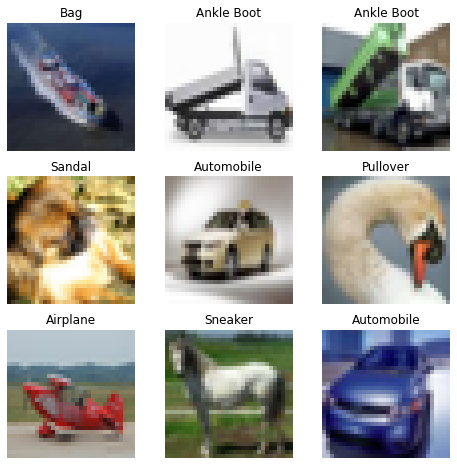

In [14]:
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    img = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [ ]:
#kornia augmentation
def slider_control(angle, index):
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      img, label = dataset[index]
      img = img.to(device)
      img = differentiable_rotation2(img,angle)
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      img = img.cpu().numpy()
      plt.axis("off")
      img = img.squeeze()
      plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
#kornia augmentation
def slider_control_crop(sigma, index):
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      img, label = dataset[index]
      img = differentiable_gaussian_blur(img, sigma)
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      #img = img.numpy()
      plt.axis("off")
      img = img.squeeze()
      plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
#PatchGaussian slider
def slider_control_patch(mean, variance,h, w):
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      img, label = dataset[index]
      img = img.unsqueeze(0)
      img = differentiable_gaussian_noise_with_selectable_focal_region(img,mean, variance, h, w)
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      #img = img.numpy()
      plt.axis("off")
      img = img.squeeze()
      plt.imshow(np.transpose(img.detach().numpy(), (1, 2, 0)))

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
interact(slider_control, angle=10,index=5);

interactive(children=(IntSlider(value=10, description='angle', max=30, min=-10), IntSlider(value=5, descriptio…

In [ ]:
index=10
sigma=0.4
interact(slider_control_crop, sigma=sigma,index=index);

interactive(children=(FloatSlider(value=0.4, description='sigma', max=1.2000000000000002, min=-0.4), IntSlider…

In [ ]:
mean = 0.5
var = 0.2
h=10
w=10
index=10
interact(slider_control_patch, mean=mean,variance=var, h=h, w=w, index=10);

interactive(children=(FloatSlider(value=0.5, description='mean', max=1.5, min=-0.5), FloatSlider(value=0.2, de…

In [32]:
class Generator(nn.Module):
    def __init__(self,image_shape):
          super().__init__()
          self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(500, 1), nn.Sigmoid())
    
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        z = self.encoder(x)
        return z

In [33]:
class Discriminator(nn.Module):
    def __init__(self,image_shape):
          super().__init__()
          self.encoder = nn.Sequential(nn.Conv2d(3, 6, 5), nn.LeakyReLU(0.2, inplace=True), nn.MaxPool2d(2, 2), nn.Conv2d(6, 16, 5), 
                                       nn.LeakyReLU(0.2, inplace=True), nn.Flatten(), nn.Linear(1600, 120), nn.LeakyReLU(0.2, inplace=True), 
                                       nn.BatchNorm1d(120, 0.8), nn.Linear(120, 256), nn.BatchNorm1d(256, 0.8), nn.Linear(256, 10), nn.Sigmoid())

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        z = self.encoder(x)
        return z

In [16]:
import os
from collections import OrderedDict

In [17]:
#configs
lr=0.01
b1=0.5
b2=0.999

In [18]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [19]:
class CIFARDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.491,0.482,0.446), (0.247,0.243,0.261)),
            ]
        )

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (3, 32, 32)
        self.num_classes = 10

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.cifar_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [52]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    #perturbed_image = image + epsilon*sign_data_grad
    #xhat = differentiable_rotation2(image,sign_data_grad.repeat(image.shape[0],1)*epsilon*10)
    xhat = differentiable_crop_translation_scale(image,sign_data_grad.repeat(1,1,1)*epsilon*10)
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return xhat

In [21]:
def fgsm_attack_rotation(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    xhat = differentiable_rotation2(image,sign_data_grad.repeat(image.shape[0],1)*epsilon*10)
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return xhat

In [78]:
def fgsm_attack_blur(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    xhat = differentiable_gaussian_blur(image,sign_data_grad.repeat(image.shape[0],1)*epsilon*10)
    #xhat = differentiable_crop_translation_scale(image,sign_data_grad.repeat(1,1,1)*epsilon*10)
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return xhat

In [79]:
class GANModule(pl.LightningModule):
    def __init__(self,channels,width,height):
          super().__init__()
          self.generator = Generator(image_shape=(width,height,channels))
          self.classifier = classifier
          self.rot = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True)
          self.mask = torch.nn.Parameter(torch.tensor((0.5,0.5,0.5,0.5), requires_grad=True))
          self.affine = torch.Tensor([[1.1,0.0,0],[0.0,1.1,0]])
          self.affine_grid = torch.nn.Parameter(torch.Tensor.repeat(self.affine,[256,1,1]), requires_grad=True)
          self.focal_mask = torch.nn.Parameter(torch.tensor((8.0,8.0,8.0,8.0), requires_grad=True))
          self.mean = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True)
          self.variance = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True)


    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x, y = x.to(device), y.to(device)
        z1 = self.rot.repeat(x.shape[0], 1)
        zmask = self.mask.repeat(x.shape[0], 1)
        #xhat = differentiable_rotation2(x,self.rot.repeat(x.shape[0], 1))
        #xhat = differentiable_gaussian_noise_with_selectable_focal_region(x,self.mean,self.variance,self.focal_mask)
        #xhat = differentiable_crop_translation_scale(x,self.affine_grid)
        xhat = differentiable_gaussian_blur(x,self.variance)
        #xhat = differentiable_gaussian_noise_with_selectable_focal_region(x,0.5,0.2,self.mask)
        #xhat2 = differentiable_crop_translation_scale(x,self.affine_grid).to("cpu").detach().numpy()[0]
        #xhat2 = differentiable_crop_translation_scale(x,self.affine_grid).to("cpu").detach().numpy()[0]
        xhat2 = differentiable_gaussian_blur(x,self.variance).to("cpu").detach().numpy()[0]
        xhat2 = np.transpose(xhat2,(1,2,0))
        plt.imshow(xhat2)
        plt.show()

        yreal = self.classifier(xhat)
        yreal = yreal.to(device)

        loss_D=0
        loss_G=0

        #if optimizer_idx == 1:
        loss_D = F.cross_entropy(yreal, y) - torch.sum(self.variance)# + F.binary_cross_entropy(yreal, valid))/2.0
        tqdm_dict = {"d_loss": loss_D}
        
        grad = torch.autograd.grad(loss_D, self.variance,
                                  retain_graph=False, create_graph=False)[0]
        perturbation = fgsm_attack_blur(x, 0.5, grad)
        with torch.no_grad():
          self.variance.copy_(nn.Parameter(torch.nn.Parameter(self.variance) + torch.nn.Parameter(grad)))
        
        print(self.affine_grid)
        yfake = self.classifier(perturbation)
        loss_D1 = F.cross_entropy(yfake, y)
        print("lossD1")
        print(loss_D1)
        output = OrderedDict({"loss": loss_D1, "progress_bar": tqdm_dict, "log": tqdm_dict,"loss_D": loss_D})

        return output

        '''loss_G = F.cross_entropy(x, y)
        labels = yreal.shape[0]
        loss_G = loss_G # + loss_patch_size*loss_patch_size/z.shape[0]
        tqdm_dict = {"g_loss": loss_G}
        output = OrderedDict({"loss": loss_G, "progress_bar": tqdm_dict, "log": tqdm_dict,"loss_G": loss_G})
        return output'''

    def configure_optimizers(self):
        #opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.classifier.parameters(), lr=lr, betas=(b1, b2))
        #opt_g = torch.optim.Adam([self.z1], lr=lr, betas=(b1, b2))
        return opt_d#,opt_g

In [44]:
CUDA_LAUNCH_BLOCKING=1

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:158: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDepr

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | generator  | Generator     | 501   
1 | classifier | LitClassifier | 228 K 
---------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.922     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


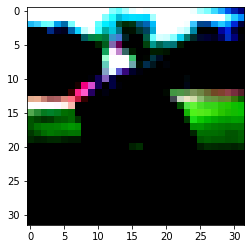

ValueError: ignored

In [80]:
dm = CIFARDataModule()
model = GANModule(*dm.size())
trainer = pl.Trainer(gpus=AVAIL_GPUS, max_epochs=5, progress_bar_refresh_rate=20)
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:158: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is

Files already downloaded and verified
Files already downloaded and verified



  | Name       | Type          | Params
---------------------------------------------
0 | generator  | Generator     | 501   
1 | classifier | LitClassifier | 228 K 
---------------------------------------------
229 K     Trainable params
0         Non-trainable params
229 K     Total params
0.918     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8, 8, 8])
tensor([8, 8,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4256: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  else:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


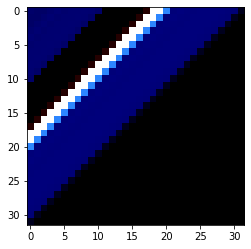

RuntimeError: ignored

In [ ]:
dm = CIFARDataModule()
model = GANModule(*dm.size())
trainer = pl.Trainer(gpus=AVAIL_GPUS, max_epochs=5, progress_bar_refresh_rate=20)
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:158: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | generator  | Generator     | 501   
1 | classifier | LitClassifier | 228 K 
---------------------------------------------
229 K     Trainable params
0         Non-trainable params
229 K     Total params
0.918     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


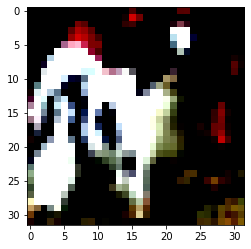

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0004, device='cuda:0')
lossD1
tensor(2.3058, device='cuda:0', grad_fn=<NllLossBackward0>)


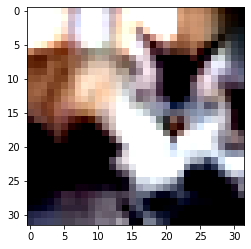

tensor(-0.0193, device='cuda:0')
lossD1
tensor(2.6913, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


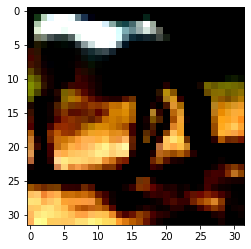

tensor(-0.0429, device='cuda:0')
lossD1
tensor(4.2468, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


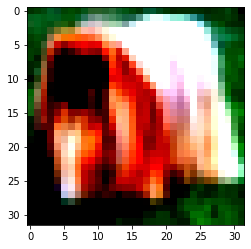

tensor(-0.0281, device='cuda:0')
lossD1
tensor(4.9218, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


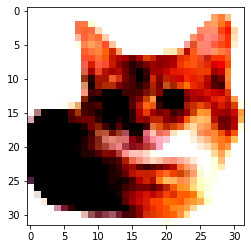

tensor(-0.0068, device='cuda:0')
lossD1
tensor(2.5590, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


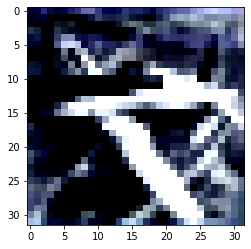

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0073, device='cuda:0')
lossD1
tensor(2.9226, device='cuda:0', grad_fn=<NllLossBackward0>)


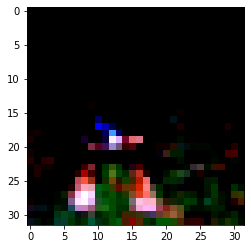

tensor(-0.1371, device='cuda:0')
lossD1
tensor(5.2396, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


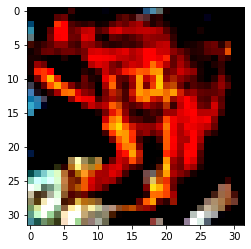

tensor(-0.1516, device='cuda:0')
lossD1
tensor(4.0765, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


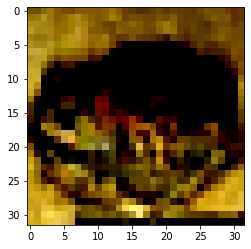

tensor(-0.2657, device='cuda:0')
lossD1
tensor(18.8589, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


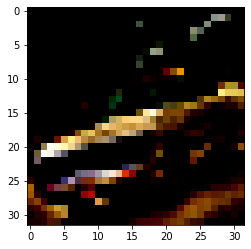

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2275, device='cuda:0')
lossD1
tensor(18.2943, device='cuda:0', grad_fn=<NllLossBackward0>)


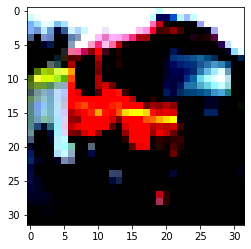

tensor(-0.4506, device='cuda:0')
lossD1
tensor(12.1860, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


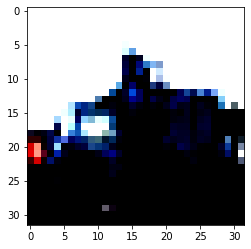

tensor(0.5218, device='cuda:0')
lossD1
tensor(5.9738, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


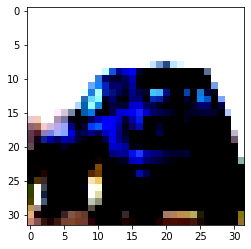

tensor(0.0085, device='cuda:0')
lossD1
tensor(37.3267, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


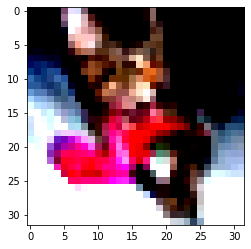

tensor(-0.4151, device='cuda:0')
lossD1
tensor(6.4473, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


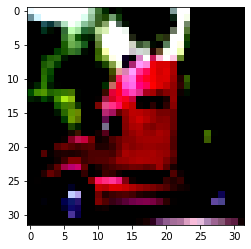

tensor(0.0429, device='cuda:0')
lossD1
tensor(7.5261, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


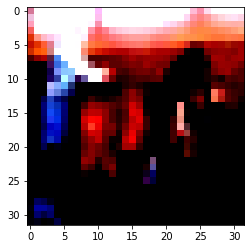

tensor(0.0641, device='cuda:0')
lossD1
tensor(8.3311, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


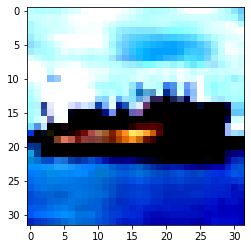

tensor(0.5784, device='cuda:0')
lossD1
tensor(22.9624, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


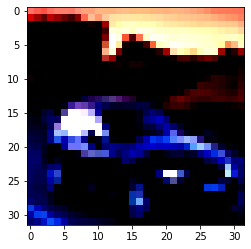

tensor(-0.1466, device='cuda:0')
lossD1
tensor(3.3282, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


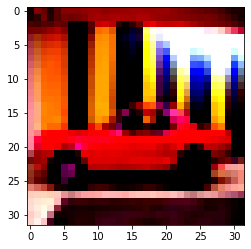

tensor(0.1199, device='cuda:0')
lossD1
tensor(7.1722, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


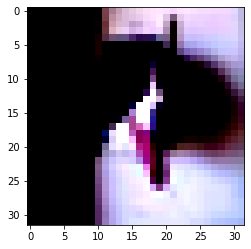

tensor(0.0146, device='cuda:0')
lossD1
tensor(7.4718, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


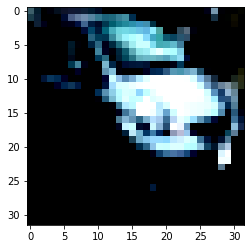

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0170, device='cuda:0')
lossD1
tensor(5.8316, device='cuda:0', grad_fn=<NllLossBackward0>)


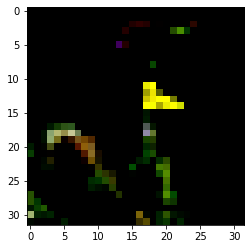

tensor(-0.2591, device='cuda:0')
lossD1
tensor(9.6195, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


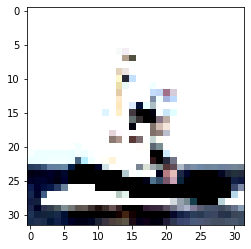

tensor(-0.1097, device='cuda:0')
lossD1
tensor(7.8248, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


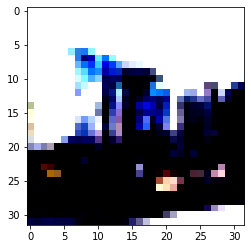

tensor(-0.0837, device='cuda:0')
lossD1
tensor(5.5143, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


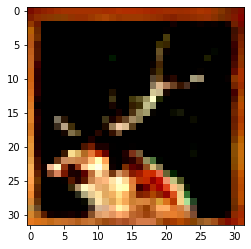

tensor(-0.0327, device='cuda:0')
lossD1
tensor(5.5654, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


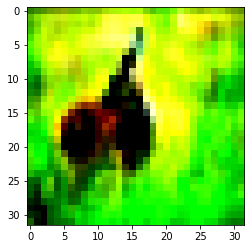

tensor(0.0066, device='cuda:0')
lossD1
tensor(2.6627, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


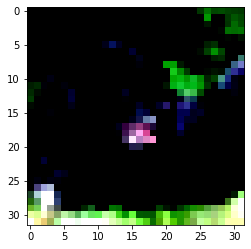

tensor(0.0035, device='cuda:0')
lossD1
tensor(2.2977, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


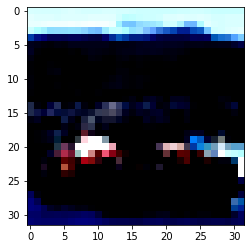

tensor(-0.0012, device='cuda:0')
lossD1
tensor(2.1668, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


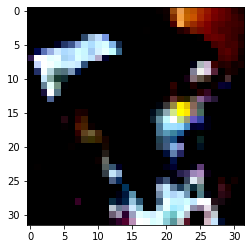

tensor(-0.0026, device='cuda:0')
lossD1
tensor(2.1247, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


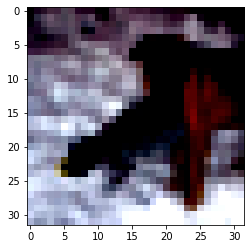

tensor(-0.0004, device='cuda:0')
lossD1
tensor(2.0843, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


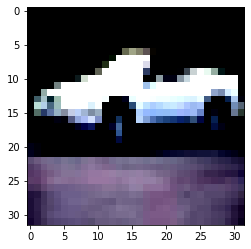

tensor(-0.0057, device='cuda:0')
lossD1
tensor(2.0357, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


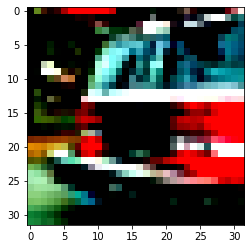

tensor(0.0082, device='cuda:0')
lossD1
tensor(2.0351, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


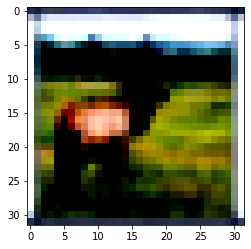

tensor(0.0009, device='cuda:0')
lossD1
tensor(2.0514, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


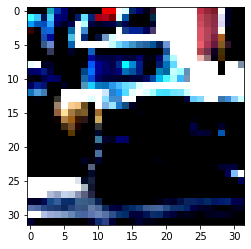

tensor(0.0040, device='cuda:0')
lossD1
tensor(2.0032, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


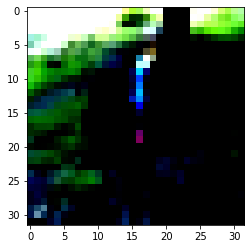

tensor(-0.0056, device='cuda:0')
lossD1
tensor(2.0829, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


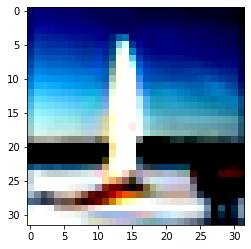

tensor(-0.0011, device='cuda:0')
lossD1
tensor(1.9541, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


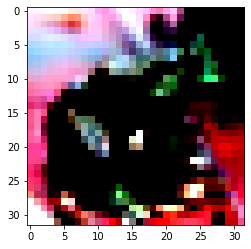

tensor(0.0135, device='cuda:0')
lossD1
tensor(1.9178, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


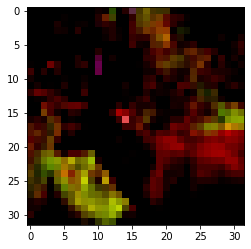

tensor(0.0091, device='cuda:0')
lossD1
tensor(1.9409, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


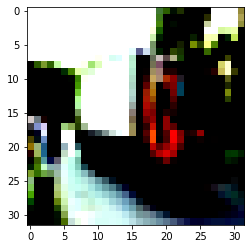

tensor(0.0116, device='cuda:0')
lossD1
tensor(2.0452, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


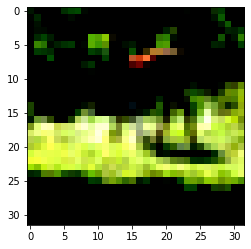

tensor(-0.0003, device='cuda:0')
lossD1
tensor(1.9276, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


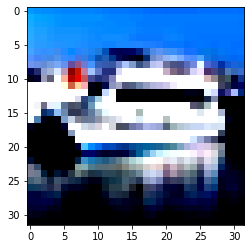

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0005, device='cuda:0')
lossD1
tensor(1.9480, device='cuda:0', grad_fn=<NllLossBackward0>)


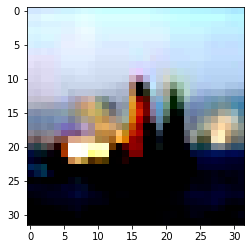

tensor(0.0103, device='cuda:0')
lossD1
tensor(1.9598, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


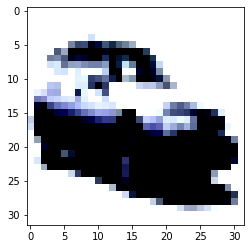

tensor(0.0083, device='cuda:0')
lossD1
tensor(1.9057, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


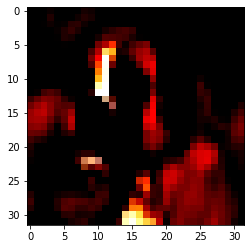

tensor(0.0161, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lossD1
tensor(1.8270, device='cuda:0', grad_fn=<NllLossBackward0>)


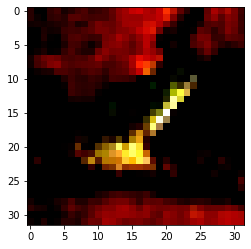

tensor(0.0011, device='cuda:0')
lossD1
tensor(2.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


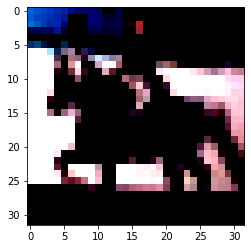

tensor(0.0141, device='cuda:0')
lossD1
tensor(1.9110, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


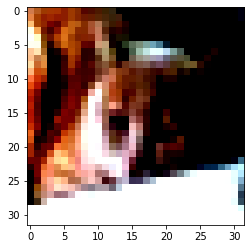

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0110, device='cuda:0')
lossD1
tensor(1.8687, device='cuda:0', grad_fn=<NllLossBackward0>)


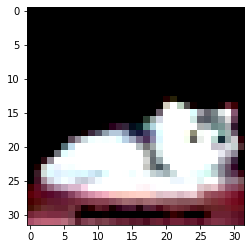

tensor(-0.0166, device='cuda:0')
lossD1
tensor(1.8662, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


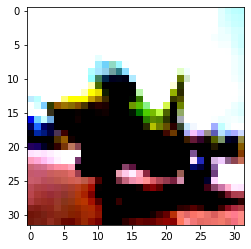

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0075, device='cuda:0')
lossD1
tensor(1.9341, device='cuda:0', grad_fn=<NllLossBackward0>)


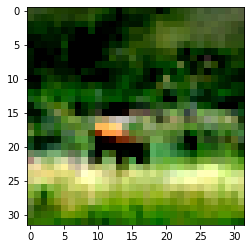

tensor(0.0251, device='cuda:0')
lossD1
tensor(1.9631, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


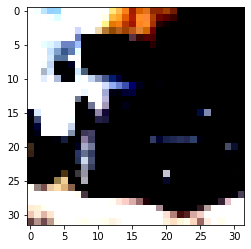

tensor(-0.0290, device='cuda:0')
lossD1
tensor(1.8810, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


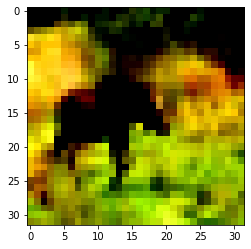

tensor(0.0164, device='cuda:0')
lossD1
tensor(1.8410, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


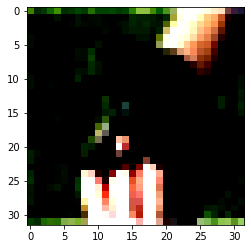

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0360, device='cuda:0')
lossD1
tensor(1.8053, device='cuda:0', grad_fn=<NllLossBackward0>)


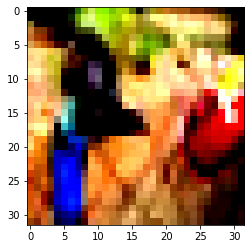

tensor(0.0548, device='cuda:0')
lossD1
tensor(1.9252, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


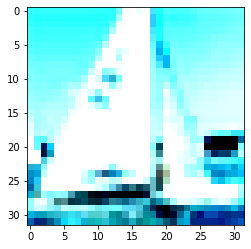

tensor(-0.0506, device='cuda:0')
lossD1
tensor(1.7718, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


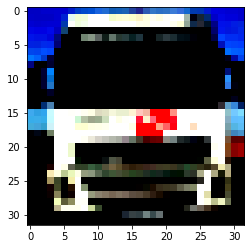

tensor(0.0154, device='cuda:0')
lossD1
tensor(1.8041, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


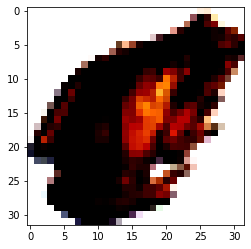

tensor(0.0633, device='cuda:0')
lossD1
tensor(1.8605, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


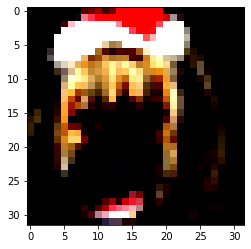

tensor(-0.0520, device='cuda:0')
lossD1
tensor(1.8632, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


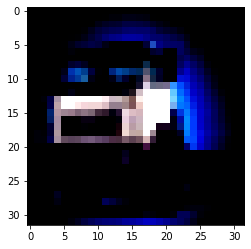

tensor(-0.0120, device='cuda:0')
lossD1
tensor(1.8244, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


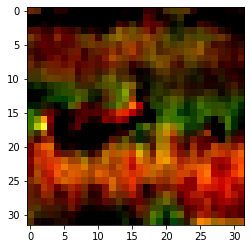

tensor(0.0641, device='cuda:0')
lossD1
tensor(1.7746, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


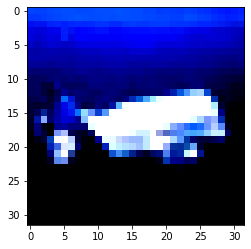

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0534, device='cuda:0')
lossD1
tensor(1.8970, device='cuda:0', grad_fn=<NllLossBackward0>)


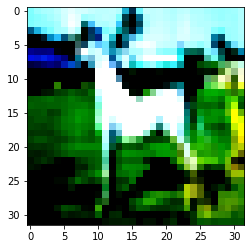

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0390, device='cuda:0')
lossD1
tensor(1.7590, device='cuda:0', grad_fn=<NllLossBackward0>)


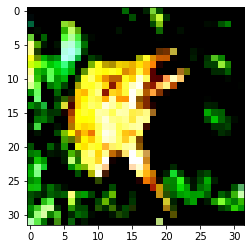

tensor(0.0212, device='cuda:0')
lossD1
tensor(1.7703, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


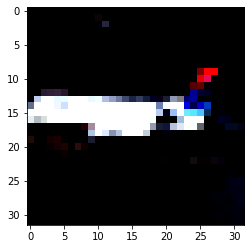

tensor(0.0525, device='cuda:0')
lossD1
tensor(1.7691, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


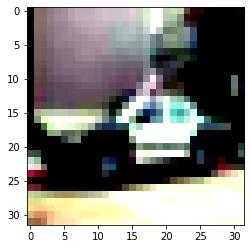

tensor(-0.0483, device='cuda:0')
lossD1
tensor(1.8002, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


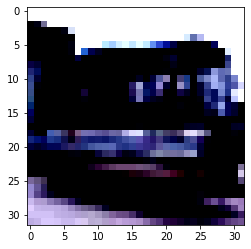

tensor(0.0565, device='cuda:0')
lossD1
tensor(1.7587, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


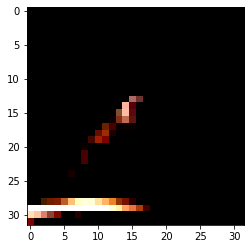

tensor(-0.0693, device='cuda:0')
lossD1
tensor(1.7361, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


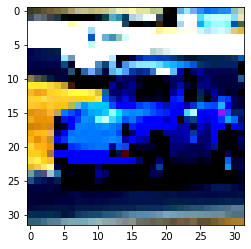

tensor(0.0425, device='cuda:0')
lossD1
tensor(1.8496, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


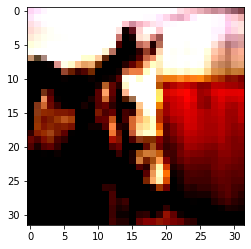

tensor(-0.0447, device='cuda:0')
lossD1
tensor(1.8303, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


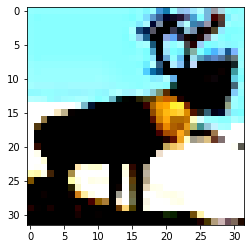

tensor(0.0486, device='cuda:0')
lossD1
tensor(1.9127, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


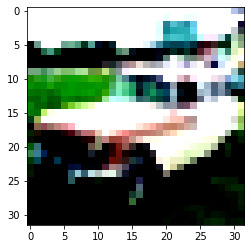

tensor(-0.0431, device='cuda:0')
lossD1
tensor(1.8666, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


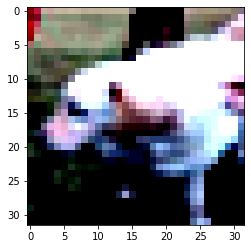

tensor(0.0345, device='cuda:0')
lossD1
tensor(1.8747, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


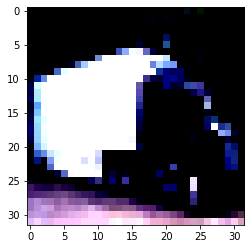

tensor(-0.0297, device='cuda:0')
lossD1
tensor(1.7457, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


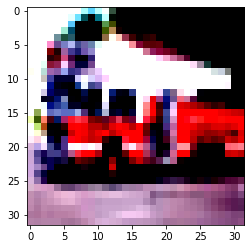

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0412, device='cuda:0')
lossD1
tensor(1.6886, device='cuda:0', grad_fn=<NllLossBackward0>)


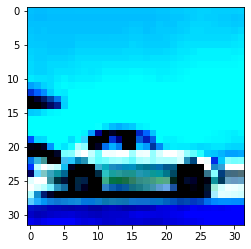

tensor(-0.0398, device='cuda:0')
lossD1
tensor(1.8196, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


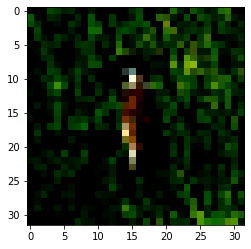

tensor(0.0485, device='cuda:0')
lossD1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7703, device='cuda:0', grad_fn=<NllLossBackward0>)


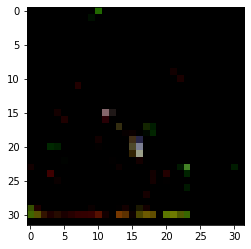

tensor(-0.0683, device='cuda:0')
lossD1
tensor(1.6711, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


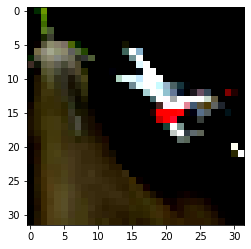

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0390, device='cuda:0')
lossD1
tensor(1.7780, device='cuda:0', grad_fn=<NllLossBackward0>)


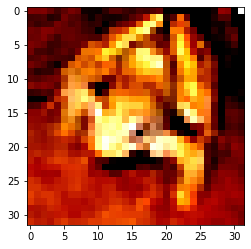

tensor(-0.0363, device='cuda:0')
lossD1
tensor(1.8415, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


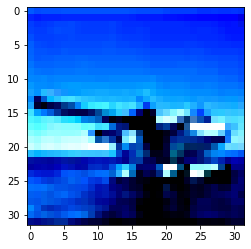

tensor(0.0998, device='cuda:0')
lossD1
tensor(1.7820, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


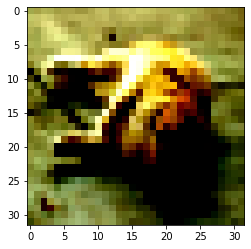

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0666, device='cuda:0')
lossD1
tensor(1.7567, device='cuda:0', grad_fn=<NllLossBackward0>)


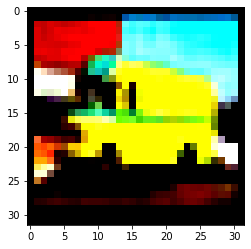

tensor(-0.0847, device='cuda:0')
lossD1
tensor(1.8543, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


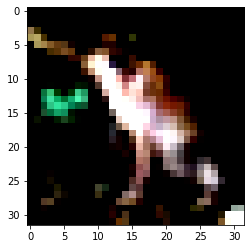

tensor(0.0400, device='cuda:0')
lossD1
tensor(1.8335, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


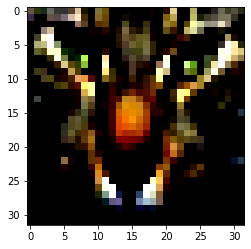

tensor(0.0684, device='cuda:0')
lossD1
tensor(1.7420, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


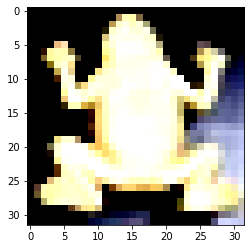

tensor(-0.0562, device='cuda:0')
lossD1
tensor(1.7500, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


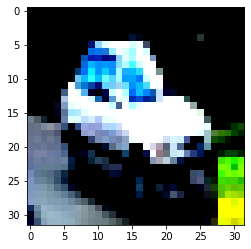

tensor(0.0181, device='cuda:0')
lossD1
tensor(1.8550, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


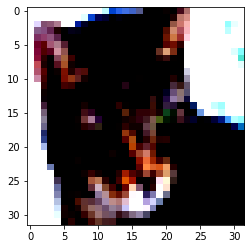

tensor(0.0474, device='cuda:0')
lossD1
tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


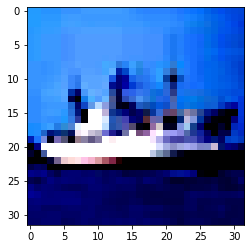

tensor(-0.0781, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lossD1
tensor(1.7992, device='cuda:0', grad_fn=<NllLossBackward0>)


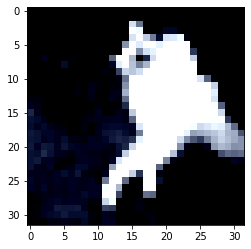

tensor(0.0195, device='cuda:0')
lossD1
tensor(1.7442, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


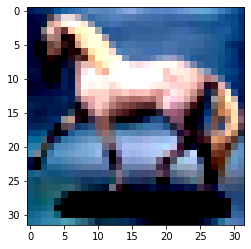

tensor(0.0295, device='cuda:0')
lossD1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



tensor(1.6978, device='cuda:0', grad_fn=<NllLossBackward0>)


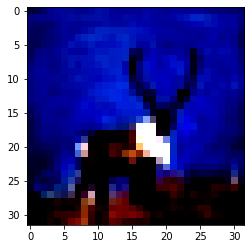

tensor(-0.0134, device='cuda:0')
lossD1
tensor(1.7375, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


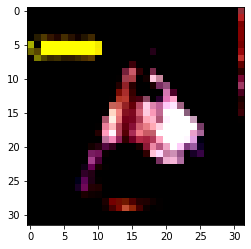

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0613, device='cuda:0')
lossD1
tensor(1.6836, device='cuda:0', grad_fn=<NllLossBackward0>)


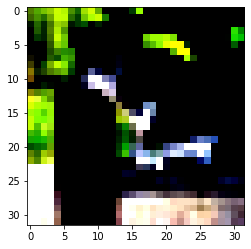

tensor(-0.0723, device='cuda:0')
lossD1
tensor(1.7281, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


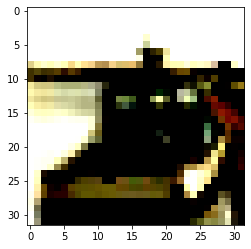

tensor(0.0486, device='cuda:0')
lossD1
tensor(1.7305, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


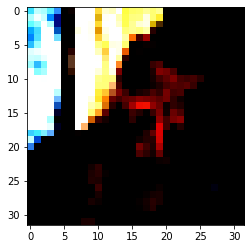

tensor(-0.0821, device='cuda:0')
lossD1
tensor(1.6879, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


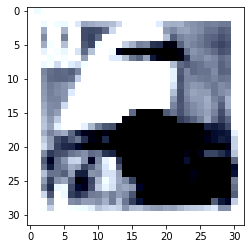

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0446, device='cuda:0')
lossD1
tensor(1.7408, device='cuda:0', grad_fn=<NllLossBackward0>)


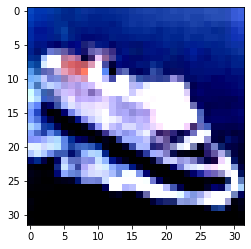

tensor(0.0816, device='cuda:0')
lossD1
tensor(1.8406, device='cuda:0', grad_fn=<NllLossBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


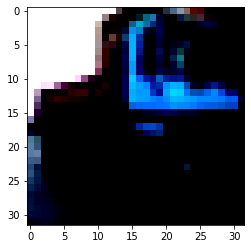

tensor(-0.0614, device='cuda:0')
lossD1
tensor(1.8185, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


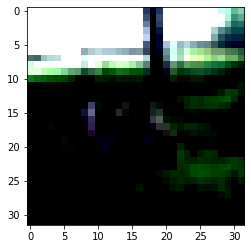

tensor(-0.0770, device='cuda:0')
lossD1
tensor(1.7482, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


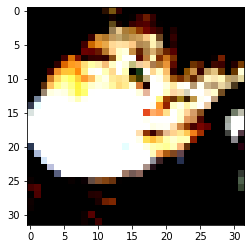

tensor(0.0552, device='cuda:0')
lossD1
tensor(1.7536, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


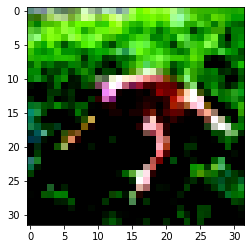

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0547, device='cuda:0')
lossD1
tensor(1.7130, device='cuda:0', grad_fn=<NllLossBackward0>)


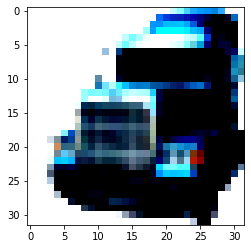

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0533, device='cuda:0')
lossD1
tensor(1.7030, device='cuda:0', grad_fn=<NllLossBackward0>)


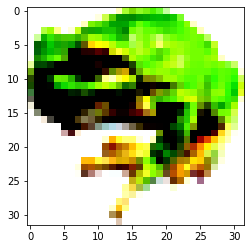

tensor(0.0567, device='cuda:0')
lossD1
tensor(1.5680, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


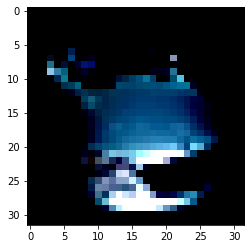

tensor(-0.1003, device='cuda:0')
lossD1
tensor(1.9091, device='cuda:0', grad_fn=<NllLossBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


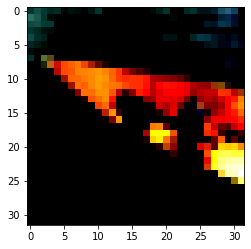

tensor(0.0055, device='cuda:0')
lossD1
tensor(1.7547, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


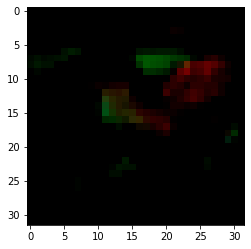

tensor(0.0112, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lossD1
tensor(1.6816, device='cuda:0', grad_fn=<NllLossBackward0>)


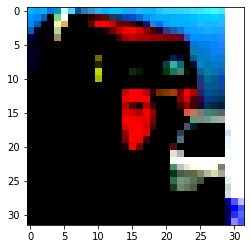

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0564, device='cuda:0')
lossD1
tensor(1.6453, device='cuda:0', grad_fn=<NllLossBackward0>)


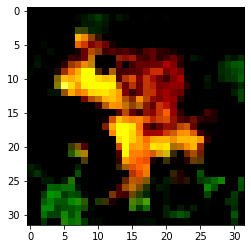

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0754, device='cuda:0')
lossD1
tensor(1.7783, device='cuda:0', grad_fn=<NllLossBackward0>)


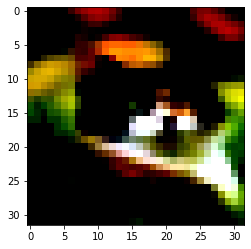

tensor(0.0352, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lossD1
tensor(1.7934, device='cuda:0', grad_fn=<NllLossBackward0>)


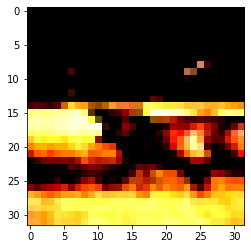

tensor(0.0335, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



lossD1
tensor(1.7285, device='cuda:0', grad_fn=<NllLossBackward0>)


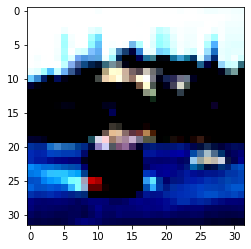

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0164, device='cuda:0')
lossD1
tensor(1.6980, device='cuda:0', grad_fn=<NllLossBackward0>)


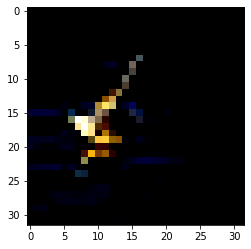

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0470, device='cuda:0')
lossD1
tensor(1.6103, device='cuda:0', grad_fn=<NllLossBackward0>)


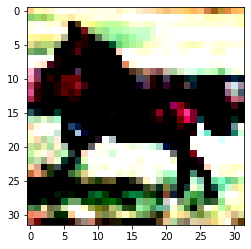

tensor(-0.0317, device='cuda:0')
lossD1
tensor(1.6823, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


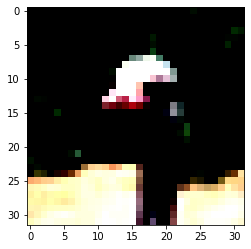

tensor(-0.0334, device='cuda:0')
lossD1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7977, device='cuda:0', grad_fn=<NllLossBackward0>)


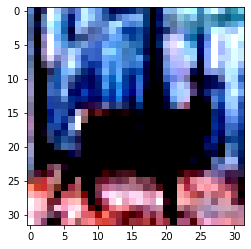

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0684, device='cuda:0')
lossD1
tensor(1.7152, device='cuda:0', grad_fn=<NllLossBackward0>)


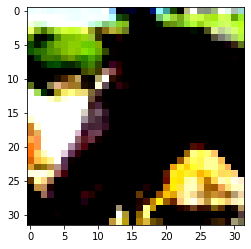

tensor(-0.0333, device='cuda:0')
lossD1
tensor(1.6789, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


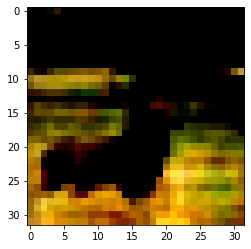

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0474, device='cuda:0')
lossD1
tensor(1.6394, device='cuda:0', grad_fn=<NllLossBackward0>)


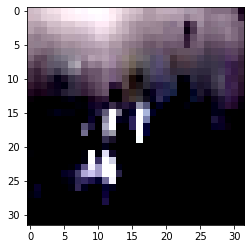

tensor(0.0779, device='cuda:0')
lossD1
tensor(1.6164, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


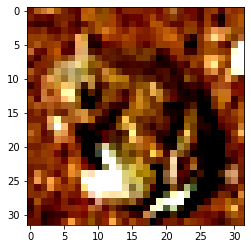

tensor(-0.0450, device='cuda:0')
lossD1
tensor(1.5551, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


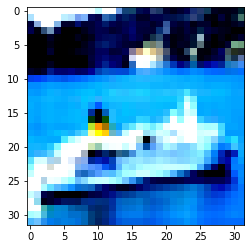

tensor(-0.0219, device='cuda:0')
lossD1
tensor(1.6498, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


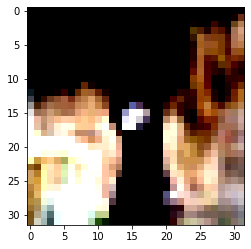

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0213, device='cuda:0')
lossD1
tensor(1.6714, device='cuda:0', grad_fn=<NllLossBackward0>)


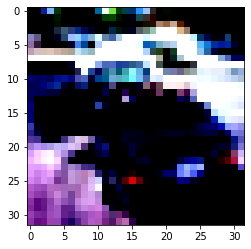

tensor(-0.0396, device='cuda:0')
lossD1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



tensor(1.6980, device='cuda:0', grad_fn=<NllLossBackward0>)


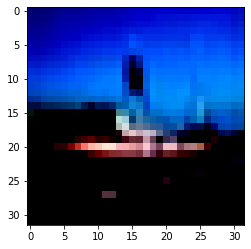

tensor(0.0614, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



lossD1
tensor(1.7517, device='cuda:0', grad_fn=<NllLossBackward0>)


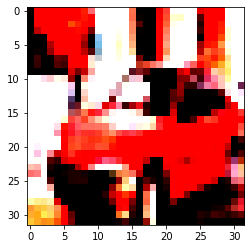

tensor(-0.0870, device='cuda:0')
lossD1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



tensor(1.6714, device='cuda:0', grad_fn=<NllLossBackward0>)


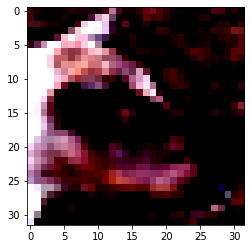

tensor(0.0782, device='cuda:0')
lossD1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7856, device='cuda:0', grad_fn=<NllLossBackward0>)


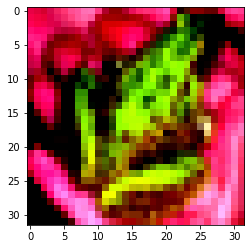

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0641, device='cuda:0')
lossD1
tensor(1.6448, device='cuda:0', grad_fn=<NllLossBackward0>)


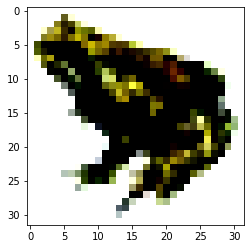

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0618, device='cuda:0')
lossD1
tensor(1.6759, device='cuda:0', grad_fn=<NllLossBackward0>)


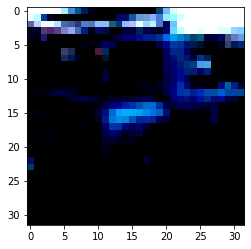

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0338, device='cuda:0')
lossD1
tensor(1.7129, device='cuda:0', grad_fn=<NllLossBackward0>)


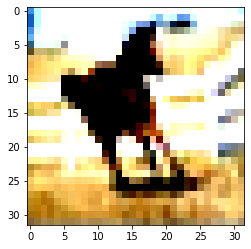

tensor(0.1093, device='cuda:0')
lossD1
tensor(1.7238, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


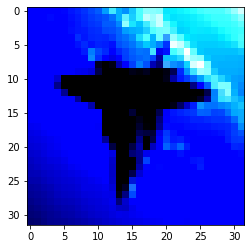

tensor(-0.0416, device='cuda:0')
lossD1
tensor(1.6771, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


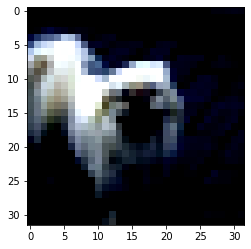

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0221, device='cuda:0')
lossD1
tensor(1.6837, device='cuda:0', grad_fn=<NllLossBackward0>)


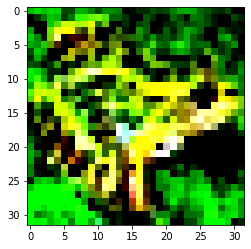

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0608, device='cuda:0')
lossD1
tensor(1.7555, device='cuda:0', grad_fn=<NllLossBackward0>)


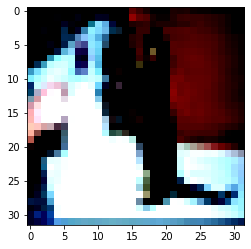

tensor(0.0437, device='cuda:0')
lossD1
tensor(1.7692, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


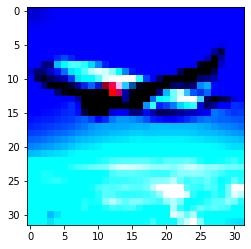

tensor(-0.0234, device='cuda:0')
lossD1
tensor(1.8811, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


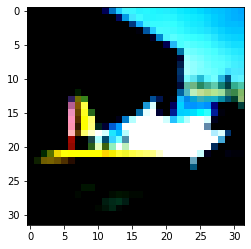

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0699, device='cuda:0')
lossD1
tensor(1.8107, device='cuda:0', grad_fn=<NllLossBackward0>)


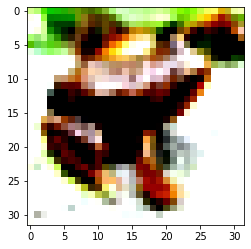

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0199, device='cuda:0')
lossD1
tensor(1.7531, device='cuda:0', grad_fn=<NllLossBackward0>)


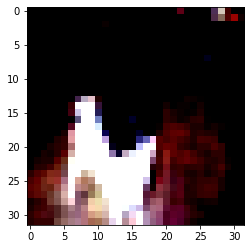

tensor(-0.0139, device='cuda:0')
lossD1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.5820, device='cuda:0', grad_fn=<NllLossBackward0>)


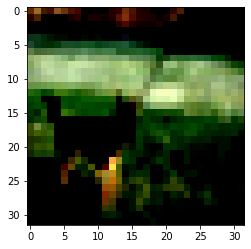

tensor(-0.0432, device='cuda:0')
lossD1
tensor(1.7068, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


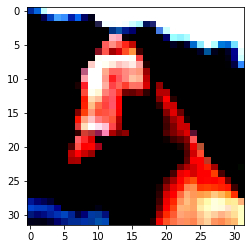

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0742, device='cuda:0')
lossD1
tensor(1.6713, device='cuda:0', grad_fn=<NllLossBackward0>)


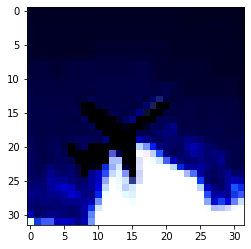

tensor(-0.0417, device='cuda:0')
lossD1
tensor(1.7088, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


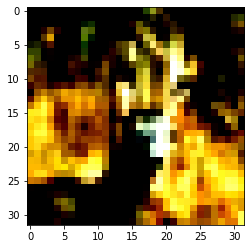

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0454, device='cuda:0')
lossD1
tensor(1.7241, device='cuda:0', grad_fn=<NllLossBackward0>)


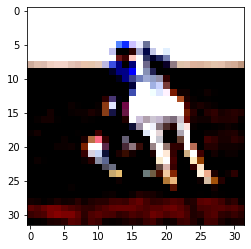

tensor(0.0053, device='cuda:0')
lossD1
tensor(1.5980, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


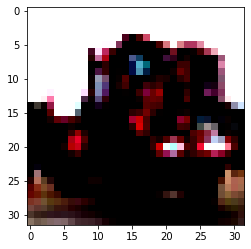

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0468, device='cuda:0')
lossD1
tensor(1.6461, device='cuda:0', grad_fn=<NllLossBackward0>)


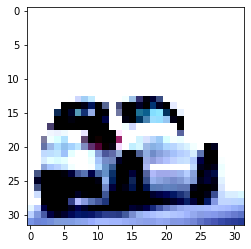

tensor(-0.0764, device='cuda:0')
lossD1
tensor(1.6986, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


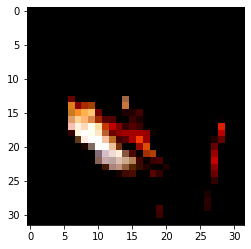

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0392, device='cuda:0')
lossD1
tensor(1.8406, device='cuda:0', grad_fn=<NllLossBackward0>)


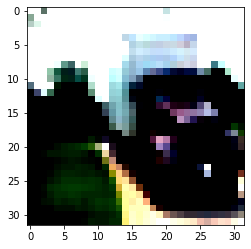

tensor(0.0457, device='cuda:0')
lossD1
tensor(1.6359, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


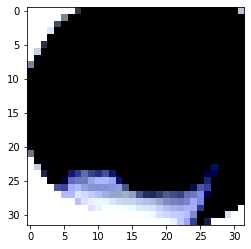

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0720, device='cuda:0')
lossD1
tensor(1.7674, device='cuda:0', grad_fn=<NllLossBackward0>)


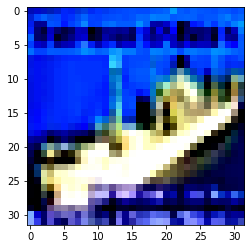

tensor(0.0046, device='cuda:0')
lossD1
tensor(1.6493, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


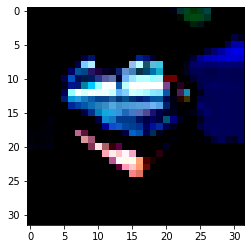

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0367, device='cuda:0')
lossD1
tensor(1.7000, device='cuda:0', grad_fn=<NllLossBackward0>)


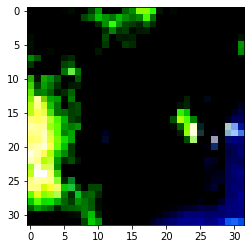

tensor(0.0453, device='cuda:0')
lossD1
tensor(1.6793, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


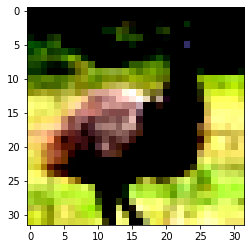

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0274, device='cuda:0')
lossD1
tensor(1.6396, device='cuda:0', grad_fn=<NllLossBackward0>)


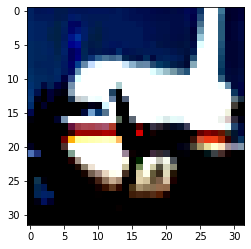

tensor(-0.0238, device='cuda:0')
lossD1
tensor(1.6925, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


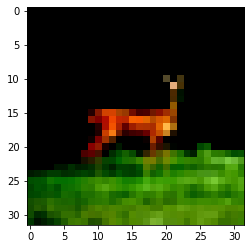

tensor(0.0674, device='cuda:0')
lossD1
tensor(1.8262, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


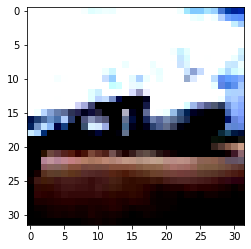

tensor(-0.0349, device='cuda:0')
lossD1
tensor(1.9343, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


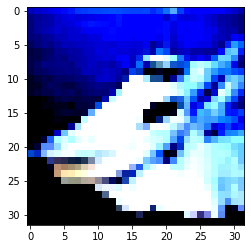

tensor(0.0058, device='cuda:0')
lossD1
tensor(1.7940, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


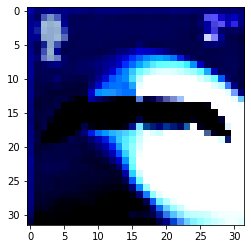

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0181, device='cuda:0')
lossD1
tensor(1.6227, device='cuda:0', grad_fn=<NllLossBackward0>)


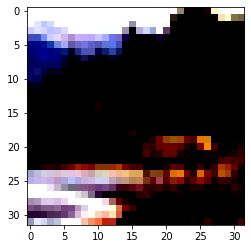

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0329, device='cuda:0')
lossD1
tensor(1.7223, device='cuda:0', grad_fn=<NllLossBackward0>)


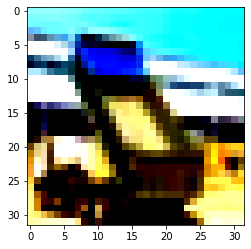

tensor(0.0040, device='cuda:0')
lossD1
tensor(1.7518, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


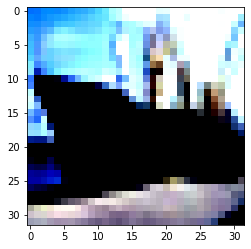

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0866, device='cuda:0')
lossD1
tensor(1.6160, device='cuda:0', grad_fn=<NllLossBackward0>)


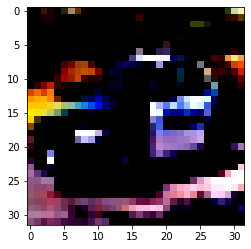

tensor(-0.0317, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lossD1
tensor(1.7207, device='cuda:0', grad_fn=<NllLossBackward0>)


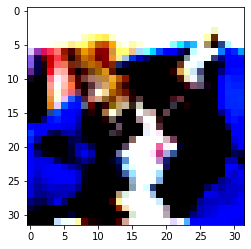

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0143, device='cuda:0')
lossD1
tensor(1.6793, device='cuda:0', grad_fn=<NllLossBackward0>)


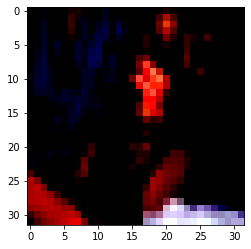

tensor(-0.0244, device='cuda:0')
lossD1
tensor(1.6132, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


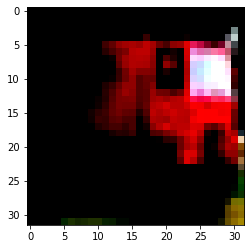

tensor(0.0309, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



lossD1
tensor(1.6779, device='cuda:0', grad_fn=<NllLossBackward0>)


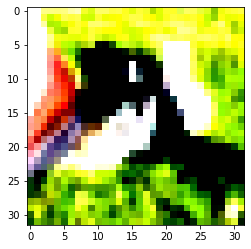

tensor(-0.0095, device='cuda:0')
lossD1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.6370, device='cuda:0', grad_fn=<NllLossBackward0>)


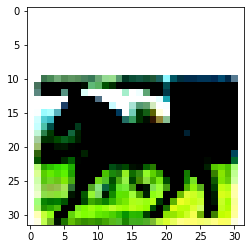

tensor(-0.0818, device='cuda:0')
lossD1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



tensor(1.6199, device='cuda:0', grad_fn=<NllLossBackward0>)


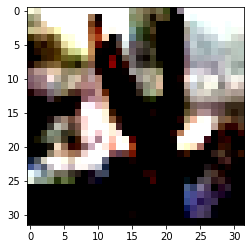

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0362, device='cuda:0')
lossD1
tensor(1.6644, device='cuda:0', grad_fn=<NllLossBackward0>)


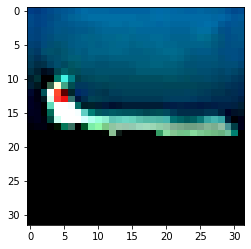

tensor(0.0896, device='cuda:0')
lossD1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7590, device='cuda:0', grad_fn=<NllLossBackward0>)


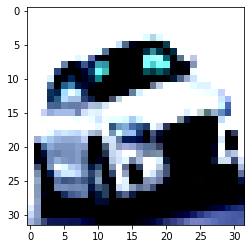

tensor(-0.0028, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



lossD1
tensor(1.6692, device='cuda:0', grad_fn=<NllLossBackward0>)


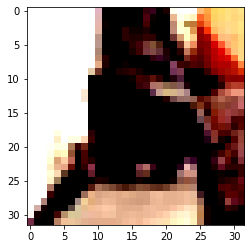

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0459, device='cuda:0')
lossD1
tensor(1.6547, device='cuda:0', grad_fn=<NllLossBackward0>)


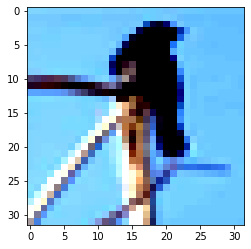

tensor(-0.0155, device='cuda:0')
lossD1
tensor(1.6374, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


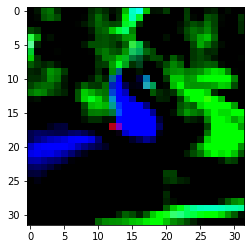

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0630, device='cuda:0')
lossD1
tensor(1.5419, device='cuda:0', grad_fn=<NllLossBackward0>)


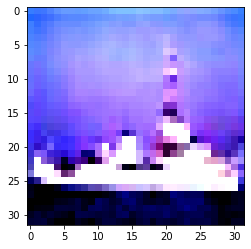

tensor(-0.0521, device='cuda:0')
lossD1
tensor(1.6444, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


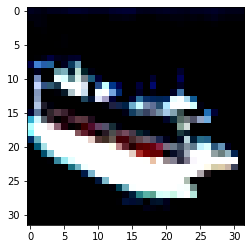

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0322, device='cuda:0')
lossD1
tensor(1.6505, device='cuda:0', grad_fn=<NllLossBackward0>)


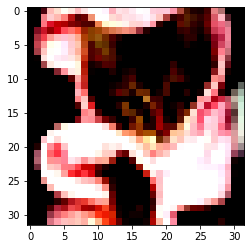

tensor(0.0780, device='cuda:0')
lossD1
tensor(1.7357, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


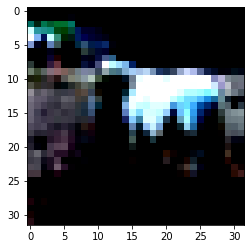

tensor(-0.0054, device='cuda:0')
lossD1
tensor(1.6490, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


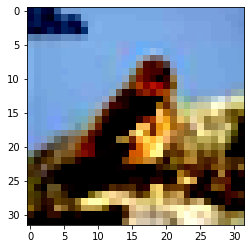

tensor(-0.0574, device='cuda:0')
lossD1
tensor(1.6693, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


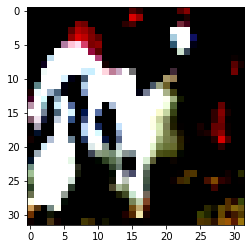

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0394, device='cuda:0')
lossD1
tensor(1.7041, device='cuda:0', grad_fn=<NllLossBackward0>)


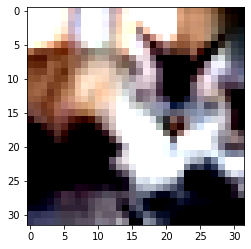

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0422, device='cuda:0')
lossD1
tensor(1.7077, device='cuda:0', grad_fn=<NllLossBackward0>)


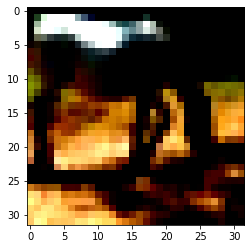

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0503, device='cuda:0')
lossD1
tensor(1.6582, device='cuda:0', grad_fn=<NllLossBackward0>)


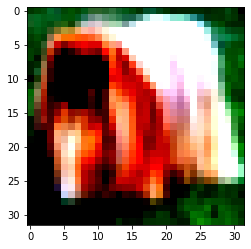

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0560, device='cuda:0')
lossD1
tensor(1.6478, device='cuda:0', grad_fn=<NllLossBackward0>)


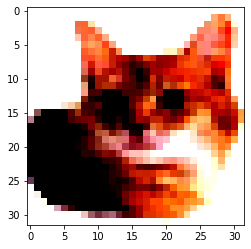

tensor(0.0522, device='cuda:0')
lossD1
tensor(1.6222, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


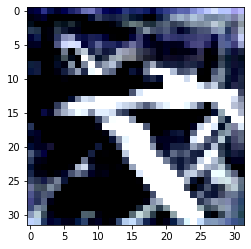

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0481, device='cuda:0')
lossD1
tensor(1.6137, device='cuda:0', grad_fn=<NllLossBackward0>)


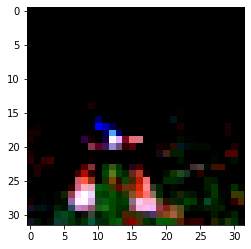

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0584, device='cuda:0')
lossD1
tensor(1.7102, device='cuda:0', grad_fn=<NllLossBackward0>)


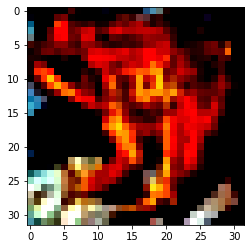

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0115, device='cuda:0')
lossD1
tensor(1.8362, device='cuda:0', grad_fn=<NllLossBackward0>)


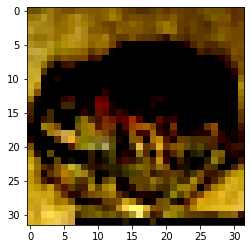

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0202, device='cuda:0')
lossD1
tensor(1.8331, device='cuda:0', grad_fn=<NllLossBackward0>)


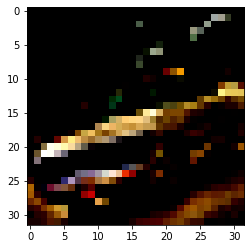

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0129, device='cuda:0')
lossD1
tensor(1.6309, device='cuda:0', grad_fn=<NllLossBackward0>)


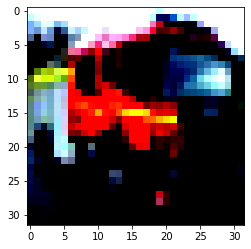

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0025, device='cuda:0')
lossD1
tensor(1.6620, device='cuda:0', grad_fn=<NllLossBackward0>)


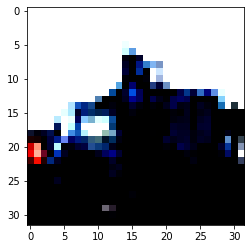

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0260, device='cuda:0')
lossD1
tensor(1.6666, device='cuda:0', grad_fn=<NllLossBackward0>)


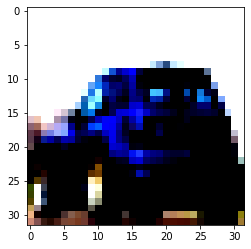

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0044, device='cuda:0')
lossD1
tensor(1.5920, device='cuda:0', grad_fn=<NllLossBackward0>)


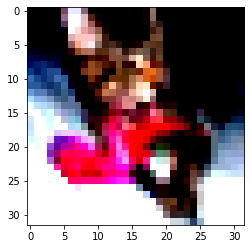

tensor(0.0203, device='cuda:0')
lossD1
tensor(1.6296, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


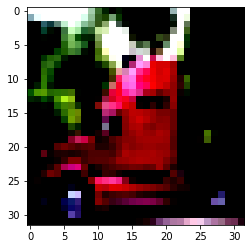

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0447, device='cuda:0')
lossD1
tensor(1.7315, device='cuda:0', grad_fn=<NllLossBackward0>)


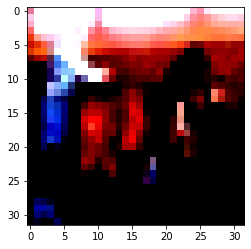

tensor(0.0131, device='cuda:0')
lossD1
tensor(1.6505, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


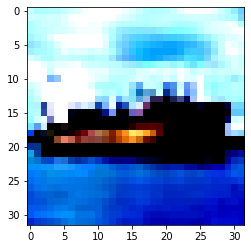

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0123, device='cuda:0')
lossD1
tensor(1.4425, device='cuda:0', grad_fn=<NllLossBackward0>)


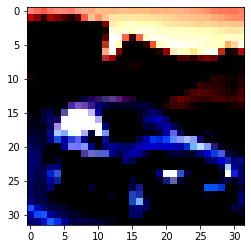

tensor(0.0473, device='cuda:0')
lossD1
tensor(1.6589, device='cuda:0', grad_fn=<NllLossBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


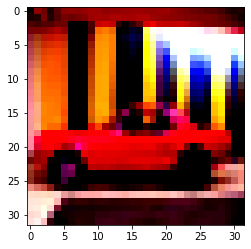

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0509, device='cuda:0')
lossD1
tensor(1.5733, device='cuda:0', grad_fn=<NllLossBackward0>)


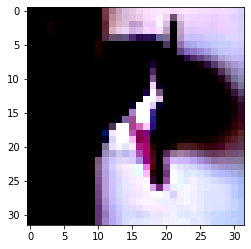

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0186, device='cuda:0')
lossD1
tensor(1.7676, device='cuda:0', grad_fn=<NllLossBackward0>)


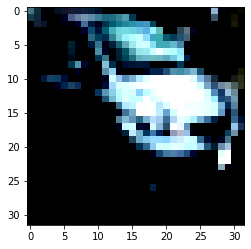

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0337, device='cuda:0')
lossD1
tensor(1.6870, device='cuda:0', grad_fn=<NllLossBackward0>)


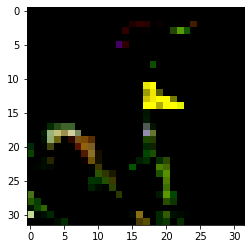

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0272, device='cuda:0')
lossD1
tensor(1.8282, device='cuda:0', grad_fn=<NllLossBackward0>)


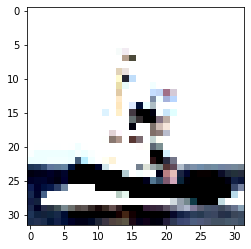

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0236, device='cuda:0')
lossD1
tensor(1.6562, device='cuda:0', grad_fn=<NllLossBackward0>)


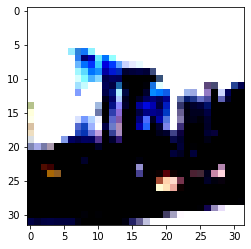

tensor(0.0373, device='cuda:0')
lossD1
tensor(1.6451, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


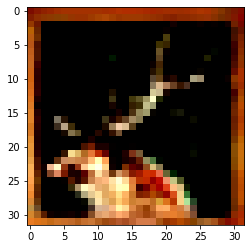

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0393, device='cuda:0')
lossD1
tensor(1.7746, device='cuda:0', grad_fn=<NllLossBackward0>)


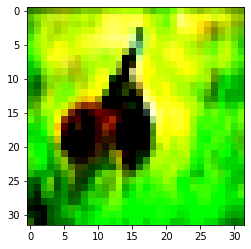

tensor(0.0688, device='cuda:0')
lossD1
tensor(1.6180, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


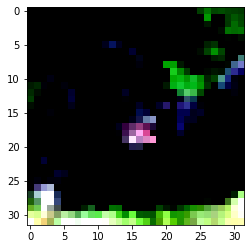

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0820, device='cuda:0')
lossD1
tensor(1.5500, device='cuda:0', grad_fn=<NllLossBackward0>)


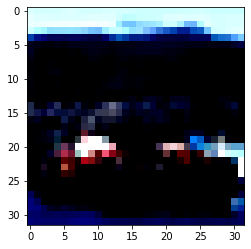

tensor(0.0427, device='cuda:0')
lossD1
tensor(1.5594, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


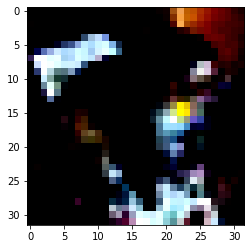

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0825, device='cuda:0')
lossD1
tensor(1.6126, device='cuda:0', grad_fn=<NllLossBackward0>)


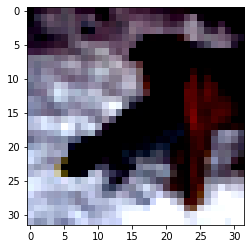

tensor(0.0193, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



lossD1
tensor(1.7385, device='cuda:0', grad_fn=<NllLossBackward0>)


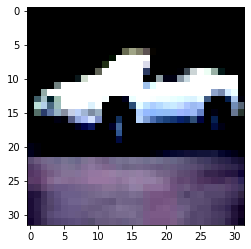

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0617, device='cuda:0')
lossD1
tensor(1.7311, device='cuda:0', grad_fn=<NllLossBackward0>)


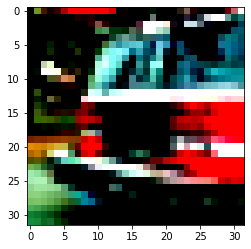

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0541, device='cuda:0')
lossD1
tensor(1.6731, device='cuda:0', grad_fn=<NllLossBackward0>)


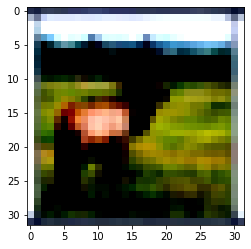

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-4.7462e-05, device='cuda:0')
lossD1
tensor(1.8242, device='cuda:0', grad_fn=<NllLossBackward0>)


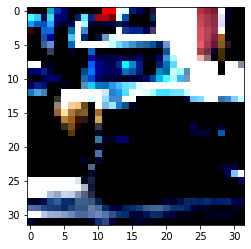

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0167, device='cuda:0')
lossD1
tensor(1.6634, device='cuda:0', grad_fn=<NllLossBackward0>)


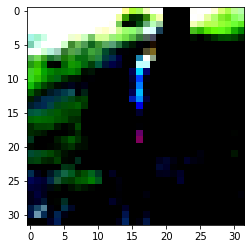

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0338, device='cuda:0')
lossD1
tensor(1.5719, device='cuda:0', grad_fn=<NllLossBackward0>)


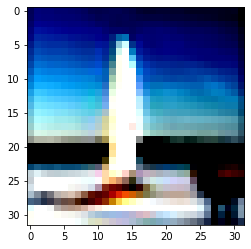

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0077, device='cuda:0')
lossD1
tensor(1.6322, device='cuda:0', grad_fn=<NllLossBackward0>)


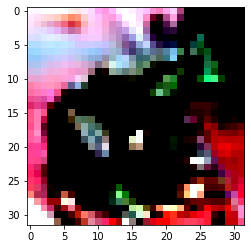

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0585, device='cuda:0')
lossD1
tensor(1.5798, device='cuda:0', grad_fn=<NllLossBackward0>)


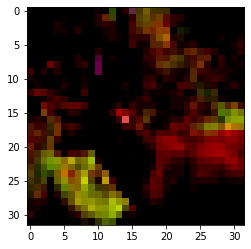

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0341, device='cuda:0')
lossD1
tensor(1.5909, device='cuda:0', grad_fn=<NllLossBackward0>)


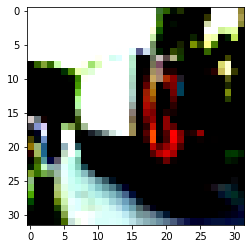

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0458, device='cuda:0')
lossD1
tensor(1.8088, device='cuda:0', grad_fn=<NllLossBackward0>)


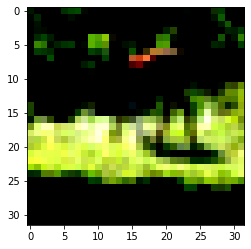

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0147, device='cuda:0')
lossD1
tensor(1.7071, device='cuda:0', grad_fn=<NllLossBackward0>)


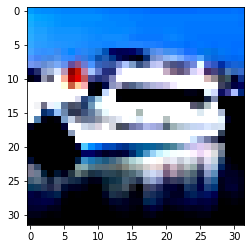

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0102, device='cuda:0')
lossD1
tensor(1.6228, device='cuda:0', grad_fn=<NllLossBackward0>)


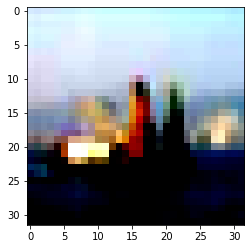

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0348, device='cuda:0')
lossD1
tensor(1.6062, device='cuda:0', grad_fn=<NllLossBackward0>)


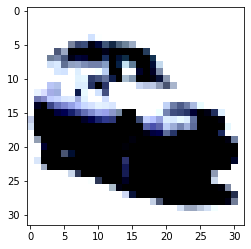

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0805, device='cuda:0')
lossD1
tensor(1.5774, device='cuda:0', grad_fn=<NllLossBackward0>)


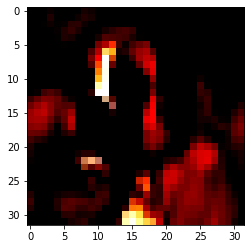

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0764, device='cuda:0')
lossD1
tensor(1.5187, device='cuda:0', grad_fn=<NllLossBackward0>)


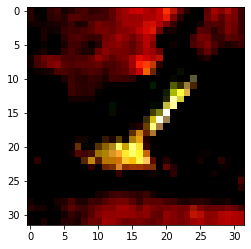

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0343, device='cuda:0')
lossD1
tensor(1.6990, device='cuda:0', grad_fn=<NllLossBackward0>)


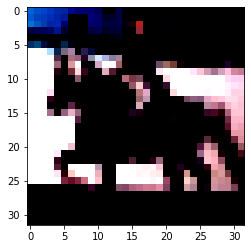

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0341, device='cuda:0')
lossD1
tensor(1.6883, device='cuda:0', grad_fn=<NllLossBackward0>)


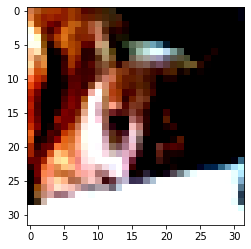

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0308, device='cuda:0')
lossD1
tensor(1.6355, device='cuda:0', grad_fn=<NllLossBackward0>)


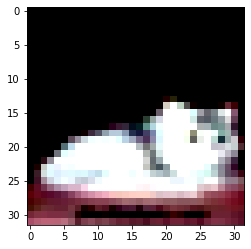

tensor(-0.0394, device='cuda:0')
lossD1
tensor(1.6717, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


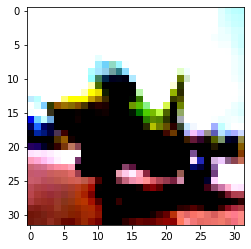

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0367, device='cuda:0')
lossD1
tensor(1.5018, device='cuda:0', grad_fn=<NllLossBackward0>)


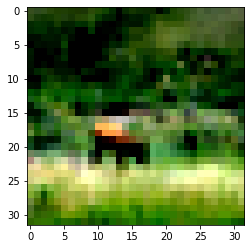

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0727, device='cuda:0')
lossD1
tensor(1.7039, device='cuda:0', grad_fn=<NllLossBackward0>)


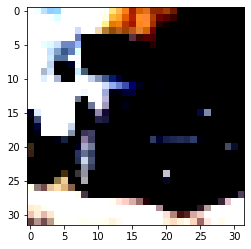

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0293, device='cuda:0')
lossD1
tensor(1.7387, device='cuda:0', grad_fn=<NllLossBackward0>)


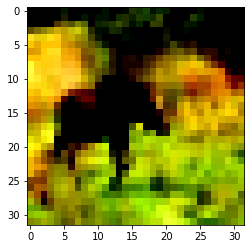

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0257, device='cuda:0')
lossD1
tensor(1.8358, device='cuda:0', grad_fn=<NllLossBackward0>)


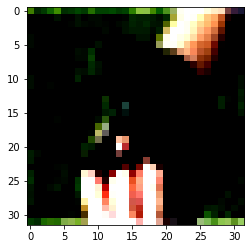

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0098, device='cuda:0')
lossD1
tensor(1.7601, device='cuda:0', grad_fn=<NllLossBackward0>)


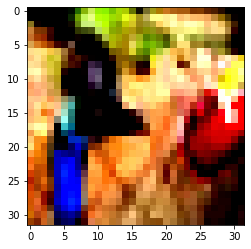

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0470, device='cuda:0')
lossD1
tensor(1.8679, device='cuda:0', grad_fn=<NllLossBackward0>)


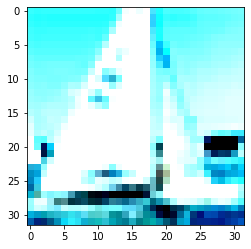

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0445, device='cuda:0')
lossD1
tensor(1.7059, device='cuda:0', grad_fn=<NllLossBackward0>)


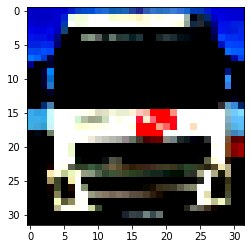

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.7224e-05, device='cuda:0')
lossD1
tensor(1.6499, device='cuda:0', grad_fn=<NllLossBackward0>)


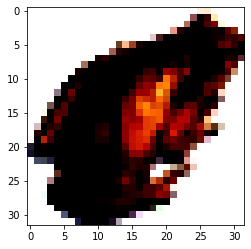

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0409, device='cuda:0')
lossD1
tensor(1.6501, device='cuda:0', grad_fn=<NllLossBackward0>)


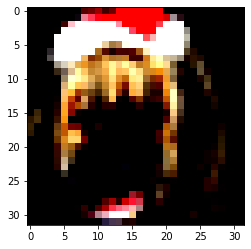

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0231, device='cuda:0')
lossD1
tensor(1.6631, device='cuda:0', grad_fn=<NllLossBackward0>)


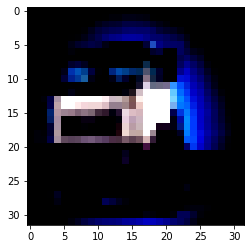

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0022, device='cuda:0')
lossD1
tensor(1.6527, device='cuda:0', grad_fn=<NllLossBackward0>)


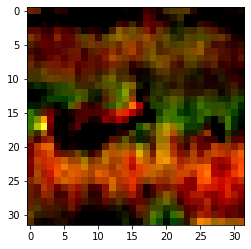

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0676, device='cuda:0')
lossD1
tensor(1.5947, device='cuda:0', grad_fn=<NllLossBackward0>)


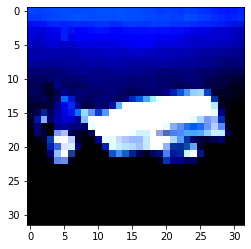

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0590, device='cuda:0')
lossD1
tensor(1.6874, device='cuda:0', grad_fn=<NllLossBackward0>)


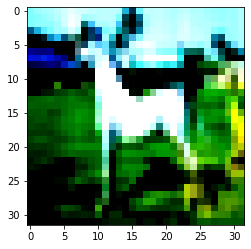

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0479, device='cuda:0')
lossD1
tensor(1.4979, device='cuda:0', grad_fn=<NllLossBackward0>)


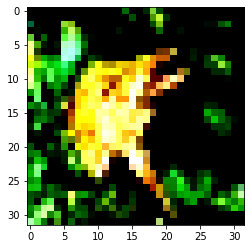

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0293, device='cuda:0')
lossD1
tensor(1.5246, device='cuda:0', grad_fn=<NllLossBackward0>)


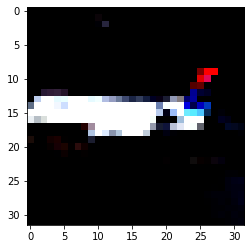

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0477, device='cuda:0')
lossD1
tensor(1.5722, device='cuda:0', grad_fn=<NllLossBackward0>)


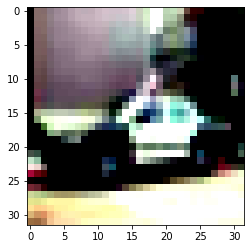

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0542, device='cuda:0')
lossD1
tensor(1.6295, device='cuda:0', grad_fn=<NllLossBackward0>)


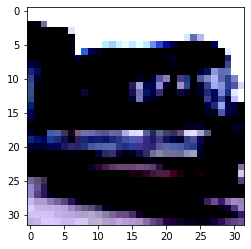

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0526, device='cuda:0')
lossD1
tensor(1.8189, device='cuda:0', grad_fn=<NllLossBackward0>)


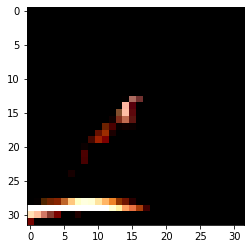

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0319, device='cuda:0')
lossD1
tensor(1.9648, device='cuda:0', grad_fn=<NllLossBackward0>)


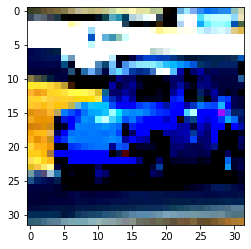

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0011, device='cuda:0')
lossD1
tensor(1.8211, device='cuda:0', grad_fn=<NllLossBackward0>)


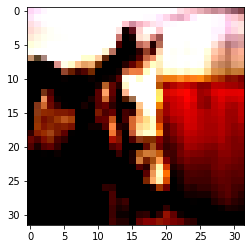

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0102, device='cuda:0')
lossD1
tensor(1.7481, device='cuda:0', grad_fn=<NllLossBackward0>)


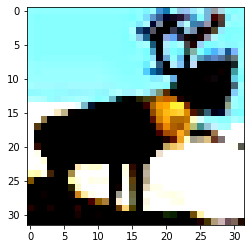

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0140, device='cuda:0')
lossD1
tensor(1.7976, device='cuda:0', grad_fn=<NllLossBackward0>)


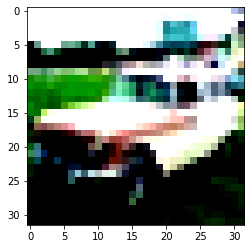

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0025, device='cuda:0')
lossD1
tensor(1.6984, device='cuda:0', grad_fn=<NllLossBackward0>)


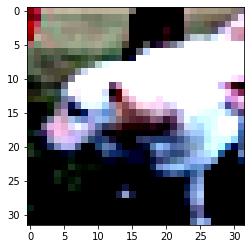

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0011, device='cuda:0')
lossD1
tensor(1.9577, device='cuda:0', grad_fn=<NllLossBackward0>)


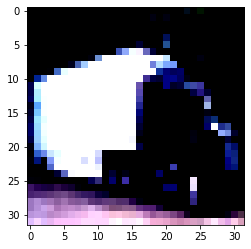

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0071, device='cuda:0')
lossD1
tensor(1.8399, device='cuda:0', grad_fn=<NllLossBackward0>)


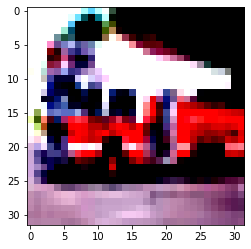

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0128, device='cuda:0')
lossD1
tensor(1.6507, device='cuda:0', grad_fn=<NllLossBackward0>)


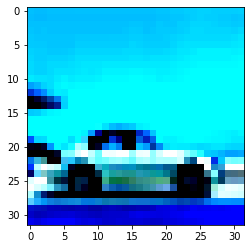

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0039, device='cuda:0')
lossD1
tensor(1.6581, device='cuda:0', grad_fn=<NllLossBackward0>)


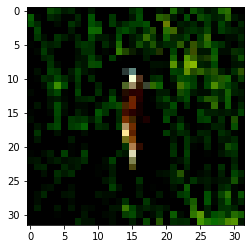

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0065, device='cuda:0')
lossD1
tensor(1.6886, device='cuda:0', grad_fn=<NllLossBackward0>)


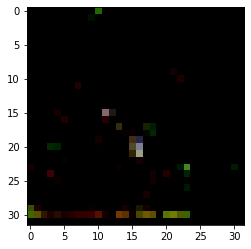

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0225, device='cuda:0')
lossD1
tensor(1.5504, device='cuda:0', grad_fn=<NllLossBackward0>)


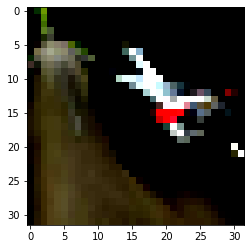

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0007, device='cuda:0')
lossD1
tensor(1.6673, device='cuda:0', grad_fn=<NllLossBackward0>)


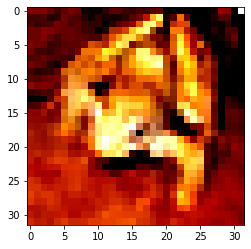

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0049, device='cuda:0')
lossD1
tensor(1.7152, device='cuda:0', grad_fn=<NllLossBackward0>)


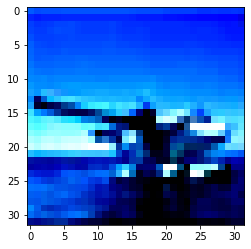

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0522, device='cuda:0')
lossD1
tensor(1.6140, device='cuda:0', grad_fn=<NllLossBackward0>)


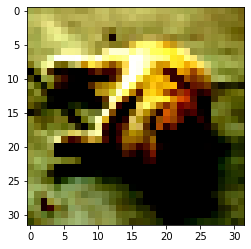

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0206, device='cuda:0')
lossD1
tensor(1.6346, device='cuda:0', grad_fn=<NllLossBackward0>)


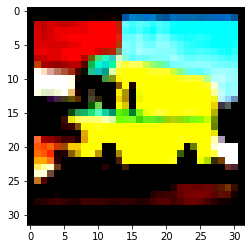

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0387, device='cuda:0')
lossD1
tensor(1.7342, device='cuda:0', grad_fn=<NllLossBackward0>)


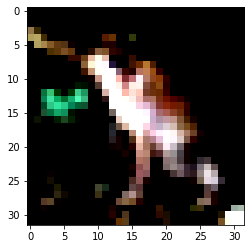

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0107, device='cuda:0')
lossD1
tensor(1.6622, device='cuda:0', grad_fn=<NllLossBackward0>)


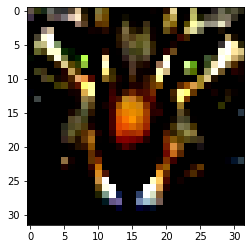

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0443, device='cuda:0')
lossD1
tensor(1.6261, device='cuda:0', grad_fn=<NllLossBackward0>)


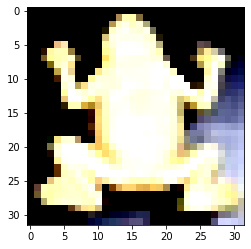

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0135, device='cuda:0')
lossD1
tensor(1.5933, device='cuda:0', grad_fn=<NllLossBackward0>)


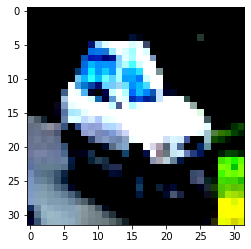

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0021, device='cuda:0')
lossD1
tensor(1.6239, device='cuda:0', grad_fn=<NllLossBackward0>)


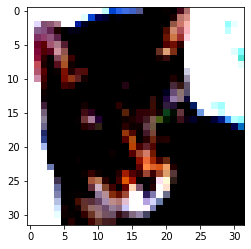

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0456, device='cuda:0')
lossD1
tensor(1.6614, device='cuda:0', grad_fn=<NllLossBackward0>)


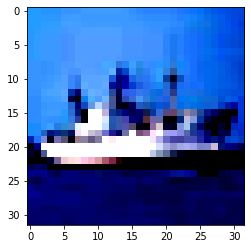

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0398, device='cuda:0')
lossD1
tensor(1.6074, device='cuda:0', grad_fn=<NllLossBackward0>)


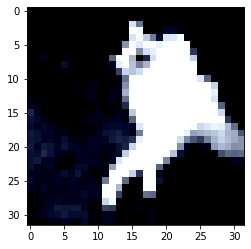

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0035, device='cuda:0')
lossD1
tensor(1.6929, device='cuda:0', grad_fn=<NllLossBackward0>)


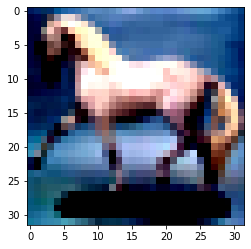

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0012, device='cuda:0')
lossD1
tensor(1.5582, device='cuda:0', grad_fn=<NllLossBackward0>)


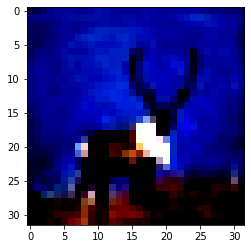

tensor(0.0020, device='cuda:0')
lossD1
tensor(1.5875, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


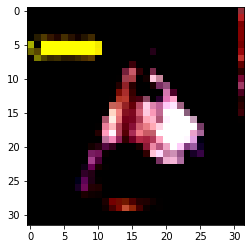

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0402, device='cuda:0')
lossD1
tensor(1.5736, device='cuda:0', grad_fn=<NllLossBackward0>)


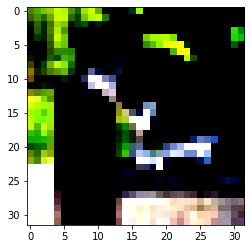

tensor(-0.0399, device='cuda:0')
lossD1
tensor(1.5500, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


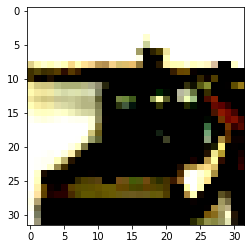

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0446, device='cuda:0')
lossD1
tensor(1.5964, device='cuda:0', grad_fn=<NllLossBackward0>)


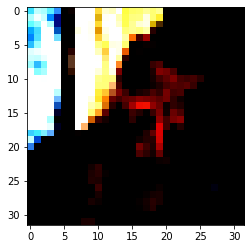

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0751, device='cuda:0')
lossD1
tensor(1.5262, device='cuda:0', grad_fn=<NllLossBackward0>)


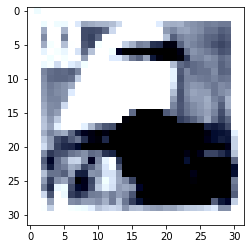

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0334, device='cuda:0')
lossD1
tensor(1.6101, device='cuda:0', grad_fn=<NllLossBackward0>)


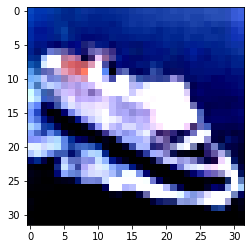

tensor(0.0377, device='cuda:0')
lossD1
tensor(1.7552, device='cuda:0', grad_fn=<NllLossBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


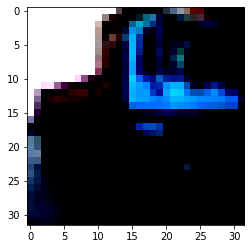

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0209, device='cuda:0')
lossD1
tensor(1.5532, device='cuda:0', grad_fn=<NllLossBackward0>)


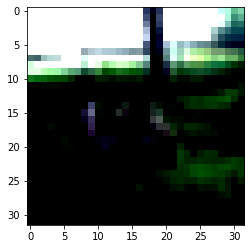

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0370, device='cuda:0')
lossD1
tensor(1.6281, device='cuda:0', grad_fn=<NllLossBackward0>)


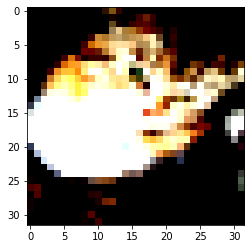

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0191, device='cuda:0')
lossD1
tensor(1.8320, device='cuda:0', grad_fn=<NllLossBackward0>)


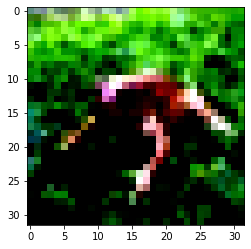

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0026, device='cuda:0')
lossD1
tensor(1.8894, device='cuda:0', grad_fn=<NllLossBackward0>)


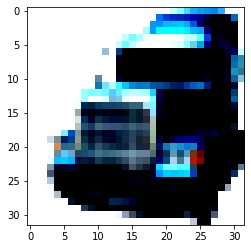

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0477, device='cuda:0')
lossD1
tensor(1.6945, device='cuda:0', grad_fn=<NllLossBackward0>)


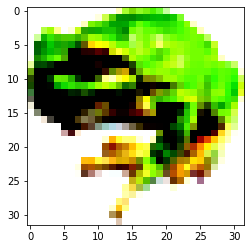

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0291, device='cuda:0')
lossD1
tensor(1.6320, device='cuda:0', grad_fn=<NllLossBackward0>)


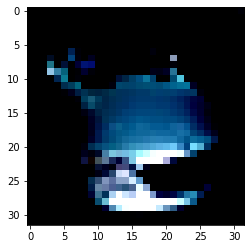

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0632, device='cuda:0')
lossD1
tensor(1.8446, device='cuda:0', grad_fn=<NllLossBackward0>)


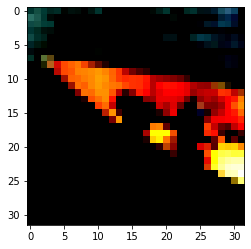

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0050, device='cuda:0')
lossD1
tensor(1.6823, device='cuda:0', grad_fn=<NllLossBackward0>)


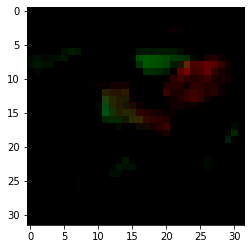

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0104, device='cuda:0')
lossD1
tensor(1.6525, device='cuda:0', grad_fn=<NllLossBackward0>)


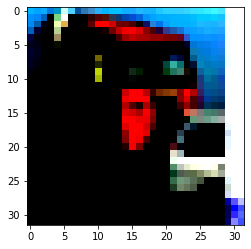

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0422, device='cuda:0')
lossD1
tensor(1.5973, device='cuda:0', grad_fn=<NllLossBackward0>)


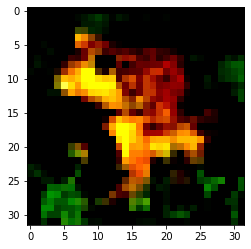

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0392, device='cuda:0')
lossD1
tensor(1.6882, device='cuda:0', grad_fn=<NllLossBackward0>)


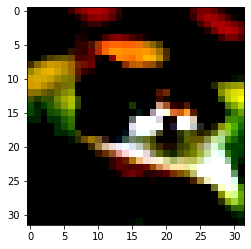

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0107, device='cuda:0')
lossD1
tensor(1.6996, device='cuda:0', grad_fn=<NllLossBackward0>)


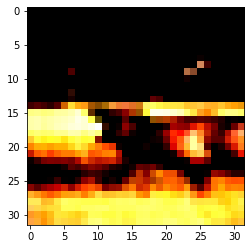

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0191, device='cuda:0')
lossD1
tensor(1.5444, device='cuda:0', grad_fn=<NllLossBackward0>)


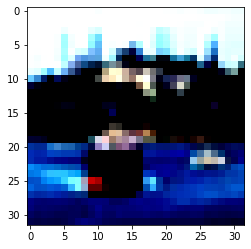

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0116, device='cuda:0')
lossD1
tensor(1.5606, device='cuda:0', grad_fn=<NllLossBackward0>)


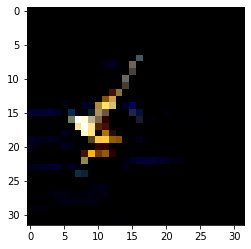

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0273, device='cuda:0')
lossD1
tensor(1.4660, device='cuda:0', grad_fn=<NllLossBackward0>)


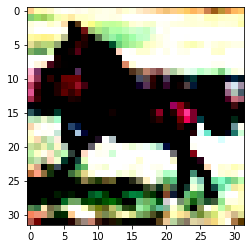

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0097, device='cuda:0')
lossD1
tensor(1.5788, device='cuda:0', grad_fn=<NllLossBackward0>)


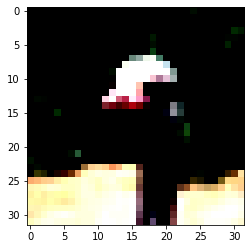

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0118, device='cuda:0')
lossD1
tensor(1.6697, device='cuda:0', grad_fn=<NllLossBackward0>)


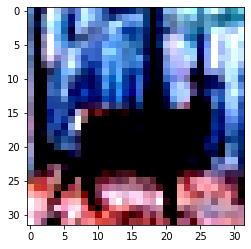

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0456, device='cuda:0')
lossD1
tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>)


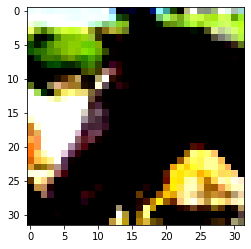

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0254, device='cuda:0')
lossD1
tensor(1.6386, device='cuda:0', grad_fn=<NllLossBackward0>)


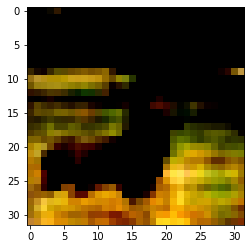

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0163, device='cuda:0')
lossD1
tensor(1.4819, device='cuda:0', grad_fn=<NllLossBackward0>)


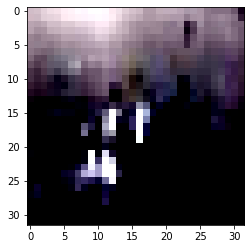

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0467, device='cuda:0')
lossD1
tensor(1.5308, device='cuda:0', grad_fn=<NllLossBackward0>)


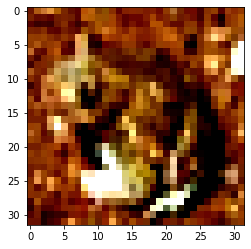

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0284, device='cuda:0')
lossD1
tensor(1.4781, device='cuda:0', grad_fn=<NllLossBackward0>)


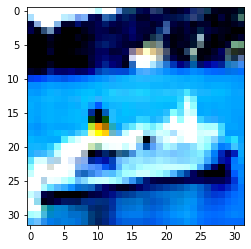

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0038, device='cuda:0')
lossD1
tensor(1.5750, device='cuda:0', grad_fn=<NllLossBackward0>)


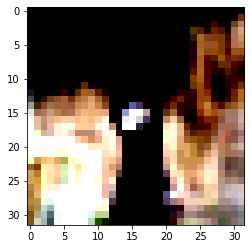

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0343, device='cuda:0')
lossD1
tensor(1.4690, device='cuda:0', grad_fn=<NllLossBackward0>)


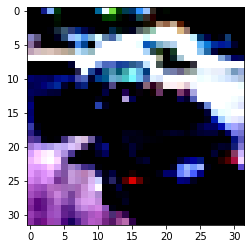

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0479, device='cuda:0')
lossD1
tensor(1.5839, device='cuda:0', grad_fn=<NllLossBackward0>)


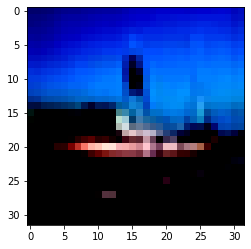

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0360, device='cuda:0')
lossD1
tensor(1.8230, device='cuda:0', grad_fn=<NllLossBackward0>)


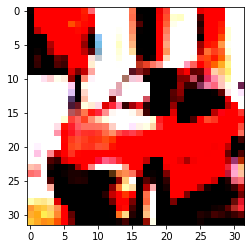

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0431, device='cuda:0')
lossD1
tensor(1.9792, device='cuda:0', grad_fn=<NllLossBackward0>)


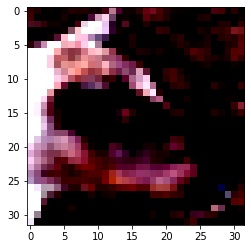

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0159, device='cuda:0')
lossD1
tensor(1.8728, device='cuda:0', grad_fn=<NllLossBackward0>)


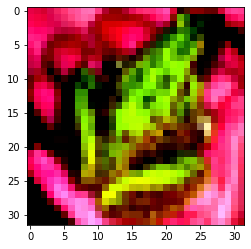

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0153, device='cuda:0')
lossD1
tensor(1.6840, device='cuda:0', grad_fn=<NllLossBackward0>)


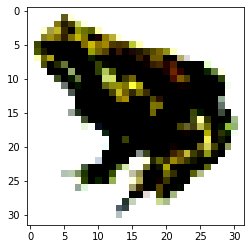

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0095, device='cuda:0')
lossD1
tensor(1.6473, device='cuda:0', grad_fn=<NllLossBackward0>)


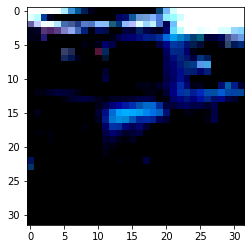

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0045, device='cuda:0')
lossD1
tensor(1.6934, device='cuda:0', grad_fn=<NllLossBackward0>)


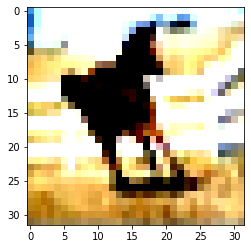

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0277, device='cuda:0')
lossD1
tensor(1.6417, device='cuda:0', grad_fn=<NllLossBackward0>)


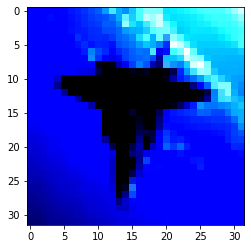

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0142, device='cuda:0')
lossD1
tensor(1.5240, device='cuda:0', grad_fn=<NllLossBackward0>)


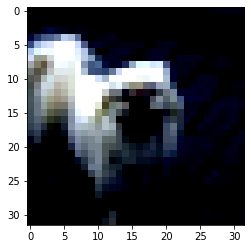

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0124, device='cuda:0')
lossD1
tensor(1.6002, device='cuda:0', grad_fn=<NllLossBackward0>)


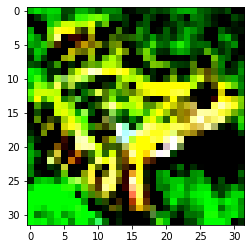

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0194, device='cuda:0')
lossD1
tensor(1.5783, device='cuda:0', grad_fn=<NllLossBackward0>)


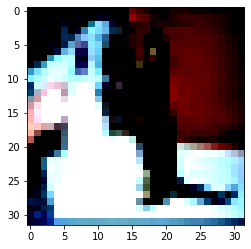

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0379, device='cuda:0')
lossD1
tensor(1.7639, device='cuda:0', grad_fn=<NllLossBackward0>)


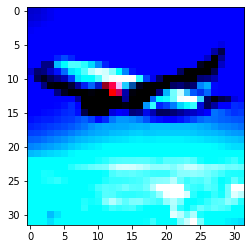

tensor(0.0003, device='cuda:0')
lossD1
tensor(1.9782, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


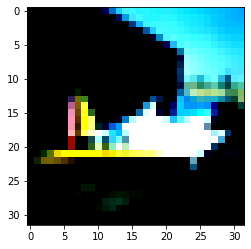

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0245, device='cuda:0')
lossD1
tensor(1.8628, device='cuda:0', grad_fn=<NllLossBackward0>)


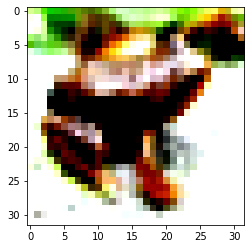

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0206, device='cuda:0')
lossD1
tensor(1.7725, device='cuda:0', grad_fn=<NllLossBackward0>)


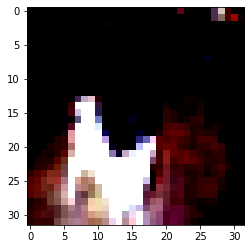

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0092, device='cuda:0')
lossD1
tensor(1.5885, device='cuda:0', grad_fn=<NllLossBackward0>)


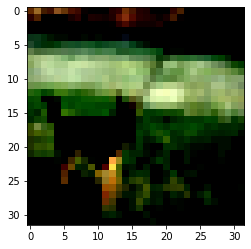

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0049, device='cuda:0')
lossD1
tensor(1.6645, device='cuda:0', grad_fn=<NllLossBackward0>)


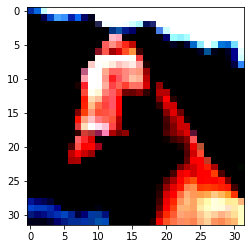

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0231, device='cuda:0')
lossD1
tensor(1.6266, device='cuda:0', grad_fn=<NllLossBackward0>)


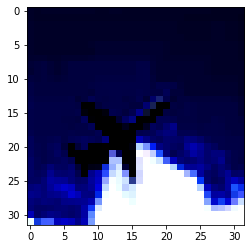

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0211, device='cuda:0')
lossD1
tensor(1.6809, device='cuda:0', grad_fn=<NllLossBackward0>)


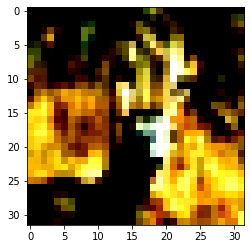

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0199, device='cuda:0')
lossD1
tensor(1.5472, device='cuda:0', grad_fn=<NllLossBackward0>)


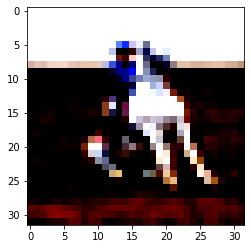

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0201, device='cuda:0')
lossD1
tensor(1.4518, device='cuda:0', grad_fn=<NllLossBackward0>)


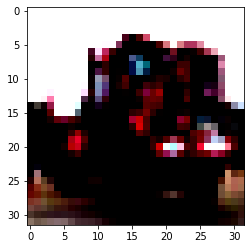

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0612, device='cuda:0')
lossD1
tensor(1.5266, device='cuda:0', grad_fn=<NllLossBackward0>)


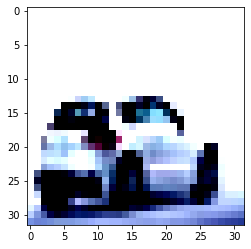

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0567, device='cuda:0')
lossD1
tensor(1.5566, device='cuda:0', grad_fn=<NllLossBackward0>)


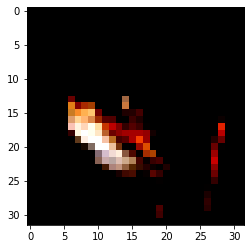

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0396, device='cuda:0')
lossD1
tensor(1.6582, device='cuda:0', grad_fn=<NllLossBackward0>)


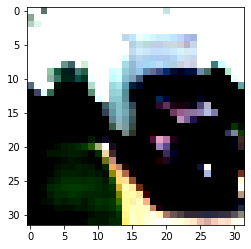

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0677, device='cuda:0')
lossD1
tensor(1.6043, device='cuda:0', grad_fn=<NllLossBackward0>)


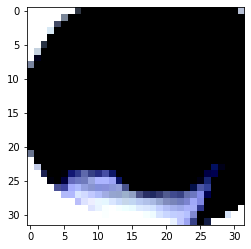

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0719, device='cuda:0')
lossD1
tensor(1.6619, device='cuda:0', grad_fn=<NllLossBackward0>)


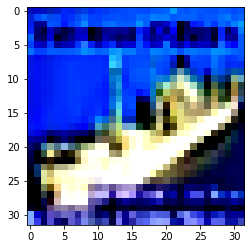

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0155, device='cuda:0')
lossD1
tensor(1.6157, device='cuda:0', grad_fn=<NllLossBackward0>)


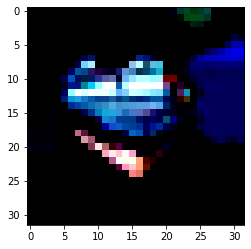

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0285, device='cuda:0')
lossD1
tensor(1.6113, device='cuda:0', grad_fn=<NllLossBackward0>)


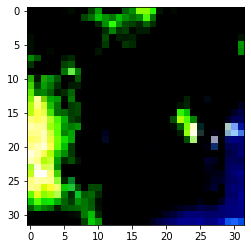

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0218, device='cuda:0')
lossD1
tensor(1.6300, device='cuda:0', grad_fn=<NllLossBackward0>)


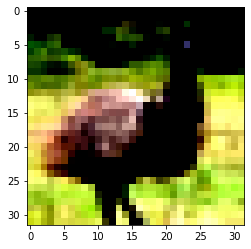

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0294, device='cuda:0')
lossD1
tensor(1.5610, device='cuda:0', grad_fn=<NllLossBackward0>)


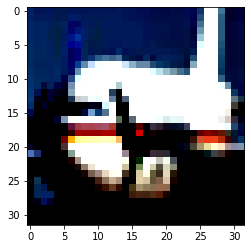

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0070, device='cuda:0')
lossD1
tensor(1.5988, device='cuda:0', grad_fn=<NllLossBackward0>)


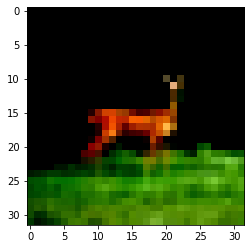

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0464, device='cuda:0')
lossD1
tensor(1.6609, device='cuda:0', grad_fn=<NllLossBackward0>)


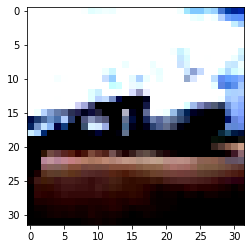

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0464, device='cuda:0')
lossD1
tensor(1.6705, device='cuda:0', grad_fn=<NllLossBackward0>)


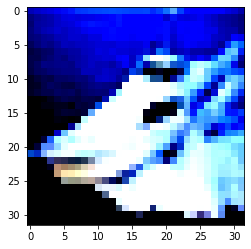

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0271, device='cuda:0')
lossD1
tensor(1.5276, device='cuda:0', grad_fn=<NllLossBackward0>)


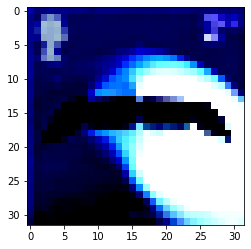

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0435, device='cuda:0')
lossD1
tensor(1.5121, device='cuda:0', grad_fn=<NllLossBackward0>)


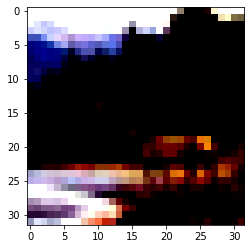

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0820, device='cuda:0')
lossD1
tensor(1.5644, device='cuda:0', grad_fn=<NllLossBackward0>)


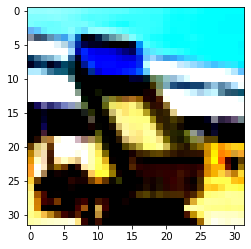

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0146, device='cuda:0')
lossD1
tensor(1.7190, device='cuda:0', grad_fn=<NllLossBackward0>)


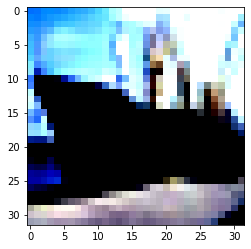

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0881, device='cuda:0')
lossD1
tensor(1.5014, device='cuda:0', grad_fn=<NllLossBackward0>)


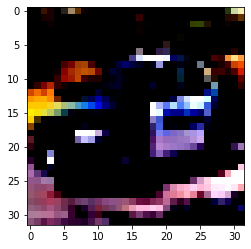

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0306, device='cuda:0')
lossD1
tensor(1.6699, device='cuda:0', grad_fn=<NllLossBackward0>)


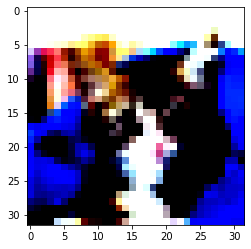

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0398, device='cuda:0')
lossD1
tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>)


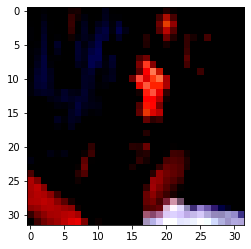

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0342, device='cuda:0')
lossD1
tensor(1.5626, device='cuda:0', grad_fn=<NllLossBackward0>)


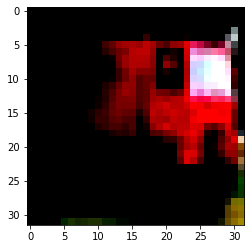

tensor(-0.0387, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



lossD1
tensor(1.6188, device='cuda:0', grad_fn=<NllLossBackward0>)


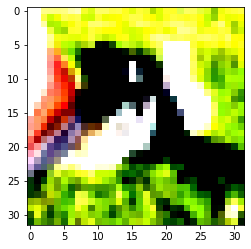

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0234, device='cuda:0')
lossD1
tensor(1.5658, device='cuda:0', grad_fn=<NllLossBackward0>)


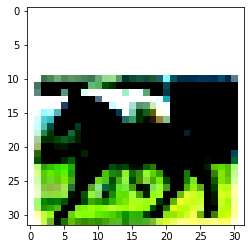

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0841, device='cuda:0')
lossD1
tensor(1.5825, device='cuda:0', grad_fn=<NllLossBackward0>)


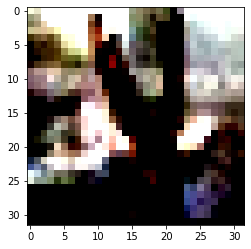

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0080, device='cuda:0')
lossD1
tensor(1.6588, device='cuda:0', grad_fn=<NllLossBackward0>)


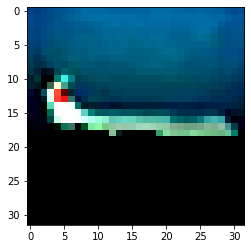

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0457, device='cuda:0')
lossD1
tensor(1.6100, device='cuda:0', grad_fn=<NllLossBackward0>)


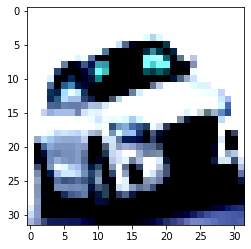

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0153, device='cuda:0')
lossD1
tensor(1.5576, device='cuda:0', grad_fn=<NllLossBackward0>)


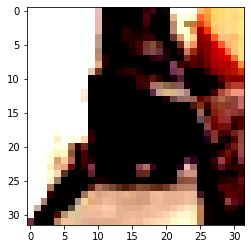

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0343, device='cuda:0')
lossD1
tensor(1.5835, device='cuda:0', grad_fn=<NllLossBackward0>)


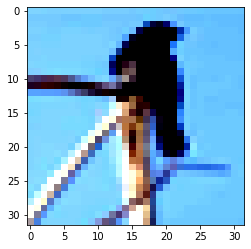

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0040, device='cuda:0')
lossD1
tensor(1.5880, device='cuda:0', grad_fn=<NllLossBackward0>)


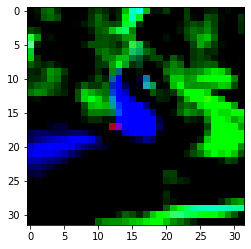

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0423, device='cuda:0')
lossD1
tensor(1.5282, device='cuda:0', grad_fn=<NllLossBackward0>)


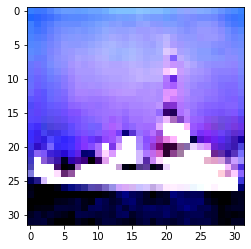

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0473, device='cuda:0')
lossD1
tensor(1.6749, device='cuda:0', grad_fn=<NllLossBackward0>)


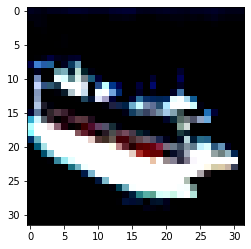

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0177, device='cuda:0')
lossD1
tensor(1.7552, device='cuda:0', grad_fn=<NllLossBackward0>)


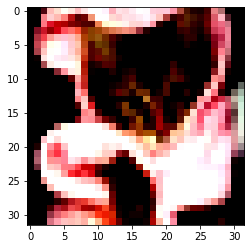

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0281, device='cuda:0')
lossD1
tensor(1.7270, device='cuda:0', grad_fn=<NllLossBackward0>)


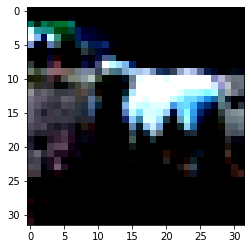

tensor(-0.0054, device='cuda:0')
lossD1
tensor(1.6120, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


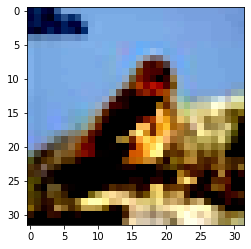

tensor(0.0644, device='cuda:0')
lossD1
tensor(1.5788, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


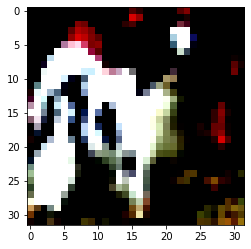

tensor(-0.0157, device='cuda:0')
lossD1
tensor(1.6851, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


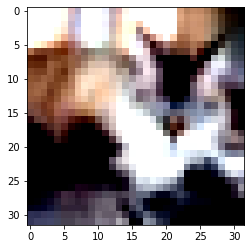

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0200, device='cuda:0')
lossD1
tensor(1.6309, device='cuda:0', grad_fn=<NllLossBackward0>)


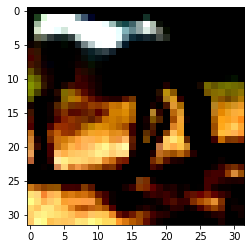

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0394, device='cuda:0')
lossD1
tensor(1.6705, device='cuda:0', grad_fn=<NllLossBackward0>)


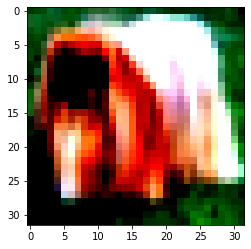

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0069, device='cuda:0')
lossD1
tensor(1.5865, device='cuda:0', grad_fn=<NllLossBackward0>)


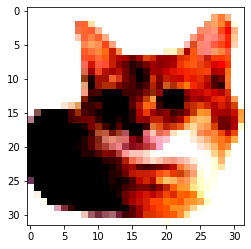

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0199, device='cuda:0')
lossD1
tensor(1.5212, device='cuda:0', grad_fn=<NllLossBackward0>)


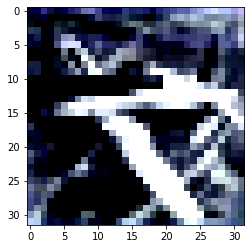

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0559, device='cuda:0')
lossD1
tensor(1.5550, device='cuda:0', grad_fn=<NllLossBackward0>)


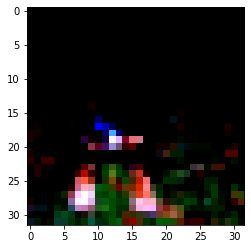

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0656, device='cuda:0')
lossD1
tensor(1.6251, device='cuda:0', grad_fn=<NllLossBackward0>)


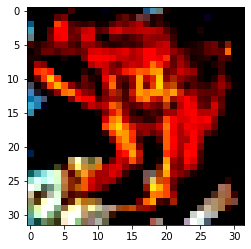

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0073, device='cuda:0')
lossD1
tensor(1.6866, device='cuda:0', grad_fn=<NllLossBackward0>)


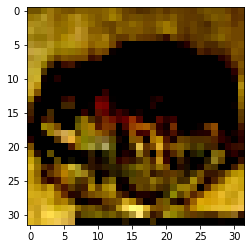

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0182, device='cuda:0')
lossD1
tensor(2.0714, device='cuda:0', grad_fn=<NllLossBackward0>)


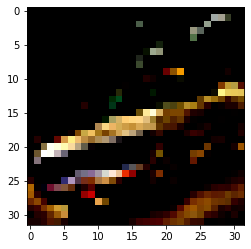

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0178, device='cuda:0')
lossD1
tensor(1.7409, device='cuda:0', grad_fn=<NllLossBackward0>)


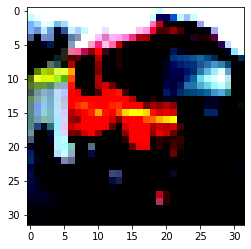

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0170, device='cuda:0')
lossD1
tensor(1.7841, device='cuda:0', grad_fn=<NllLossBackward0>)


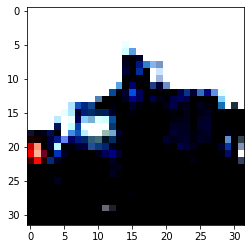

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0048, device='cuda:0')
lossD1
tensor(1.6564, device='cuda:0', grad_fn=<NllLossBackward0>)


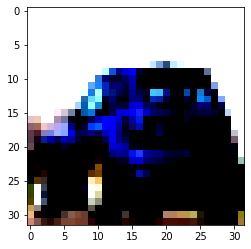

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0013, device='cuda:0')
lossD1
tensor(1.6870, device='cuda:0', grad_fn=<NllLossBackward0>)


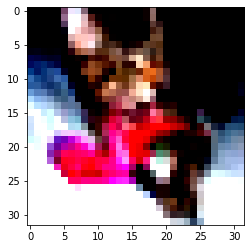

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0128, device='cuda:0')
lossD1
tensor(1.6620, device='cuda:0', grad_fn=<NllLossBackward0>)


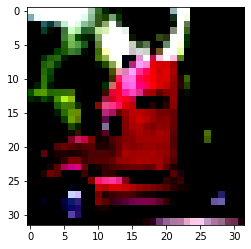

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0097, device='cuda:0')
lossD1
tensor(1.6937, device='cuda:0', grad_fn=<NllLossBackward0>)


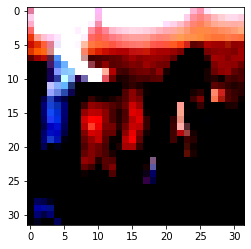

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0091, device='cuda:0')
lossD1
tensor(1.6903, device='cuda:0', grad_fn=<NllLossBackward0>)


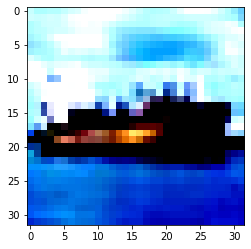

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0107, device='cuda:0')
lossD1
tensor(1.4714, device='cuda:0', grad_fn=<NllLossBackward0>)


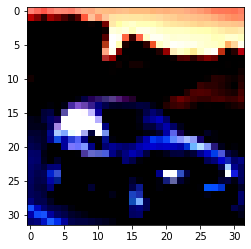

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0170, device='cuda:0')
lossD1
tensor(1.5816, device='cuda:0', grad_fn=<NllLossBackward0>)


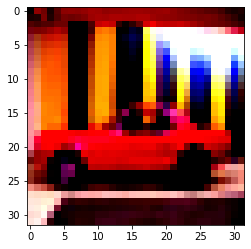

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0274, device='cuda:0')
lossD1
tensor(1.4906, device='cuda:0', grad_fn=<NllLossBackward0>)


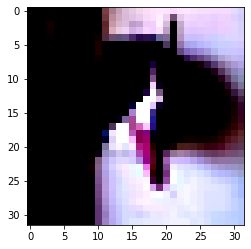

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0161, device='cuda:0')
lossD1
tensor(1.6715, device='cuda:0', grad_fn=<NllLossBackward0>)


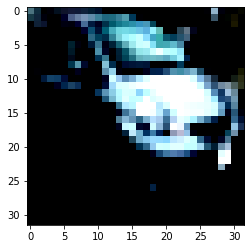

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0404, device='cuda:0')
lossD1
tensor(1.5717, device='cuda:0', grad_fn=<NllLossBackward0>)


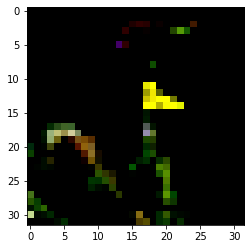

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0373, device='cuda:0')
lossD1
tensor(1.4951, device='cuda:0', grad_fn=<NllLossBackward0>)


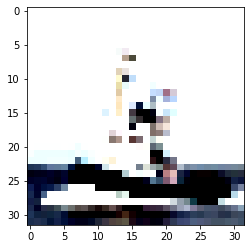

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0240, device='cuda:0')
lossD1
tensor(1.5680, device='cuda:0', grad_fn=<NllLossBackward0>)


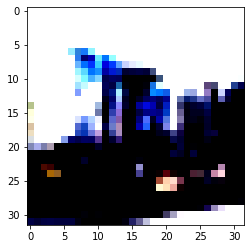

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0260, device='cuda:0')
lossD1
tensor(1.5471, device='cuda:0', grad_fn=<NllLossBackward0>)


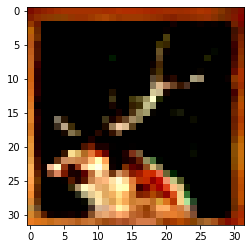

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0133, device='cuda:0')
lossD1
tensor(1.6344, device='cuda:0', grad_fn=<NllLossBackward0>)


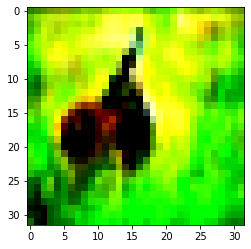

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0405, device='cuda:0')
lossD1
tensor(1.6128, device='cuda:0', grad_fn=<NllLossBackward0>)


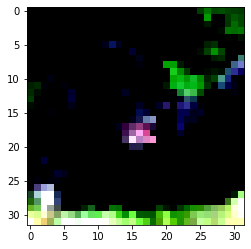

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0591, device='cuda:0')
lossD1
tensor(1.6578, device='cuda:0', grad_fn=<NllLossBackward0>)


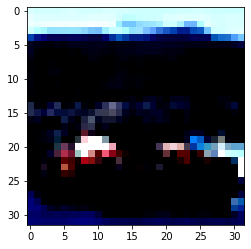

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0210, device='cuda:0')
lossD1
tensor(1.7073, device='cuda:0', grad_fn=<NllLossBackward0>)


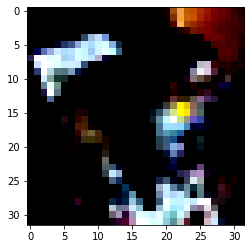

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0169, device='cuda:0')
lossD1
tensor(1.5995, device='cuda:0', grad_fn=<NllLossBackward0>)


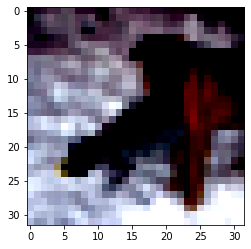

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0078, device='cuda:0')
lossD1
tensor(1.6130, device='cuda:0', grad_fn=<NllLossBackward0>)


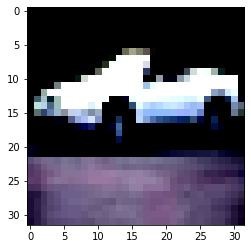

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0253, device='cuda:0')
lossD1
tensor(1.5507, device='cuda:0', grad_fn=<NllLossBackward0>)


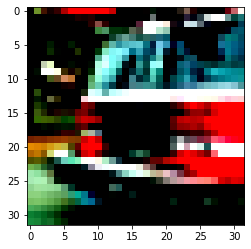

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0709, device='cuda:0')
lossD1
tensor(1.5699, device='cuda:0', grad_fn=<NllLossBackward0>)


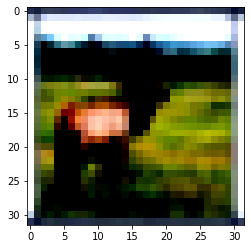

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0227, device='cuda:0')
lossD1
tensor(1.7118, device='cuda:0', grad_fn=<NllLossBackward0>)


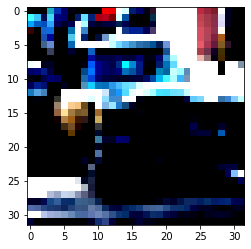

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0344, device='cuda:0')
lossD1
tensor(1.5921, device='cuda:0', grad_fn=<NllLossBackward0>)


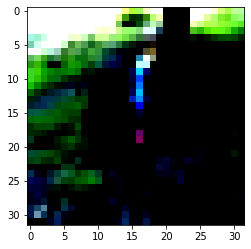

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0499, device='cuda:0')
lossD1
tensor(1.4845, device='cuda:0', grad_fn=<NllLossBackward0>)


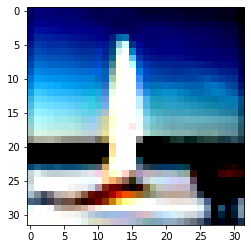

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0153, device='cuda:0')
lossD1
tensor(1.5928, device='cuda:0', grad_fn=<NllLossBackward0>)


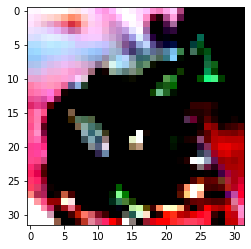

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0699, device='cuda:0')
lossD1
tensor(1.5102, device='cuda:0', grad_fn=<NllLossBackward0>)


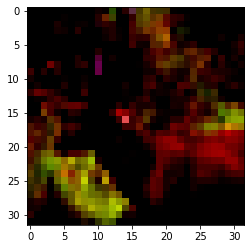

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0318, device='cuda:0')
lossD1
tensor(1.5198, device='cuda:0', grad_fn=<NllLossBackward0>)


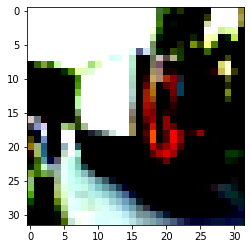

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0720, device='cuda:0')
lossD1
tensor(1.7812, device='cuda:0', grad_fn=<NllLossBackward0>)


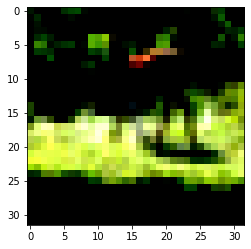

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0174, device='cuda:0')
lossD1
tensor(1.6125, device='cuda:0', grad_fn=<NllLossBackward0>)


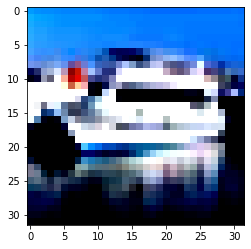

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0334, device='cuda:0')
lossD1
tensor(1.5871, device='cuda:0', grad_fn=<NllLossBackward0>)


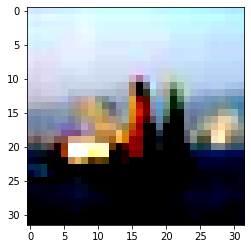

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0516, device='cuda:0')
lossD1
tensor(1.5381, device='cuda:0', grad_fn=<NllLossBackward0>)


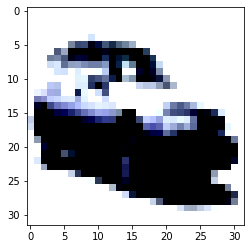

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0879, device='cuda:0')
lossD1
tensor(1.5184, device='cuda:0', grad_fn=<NllLossBackward0>)


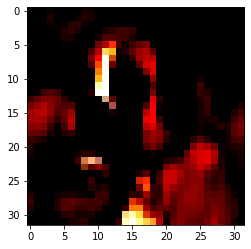

tensor(0.0611, device='cuda:0')
lossD1
tensor(1.4326, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


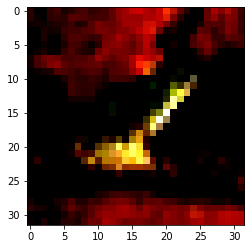

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0467, device='cuda:0')
lossD1
tensor(1.5302, device='cuda:0', grad_fn=<NllLossBackward0>)


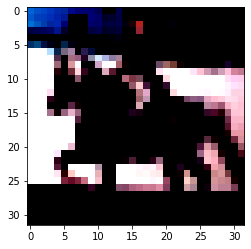

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0409, device='cuda:0')
lossD1
tensor(1.5683, device='cuda:0', grad_fn=<NllLossBackward0>)


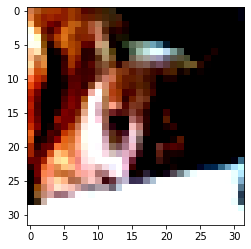

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0709, device='cuda:0')
lossD1
tensor(1.6041, device='cuda:0', grad_fn=<NllLossBackward0>)


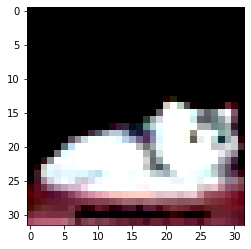

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0683, device='cuda:0')
lossD1
tensor(1.5495, device='cuda:0', grad_fn=<NllLossBackward0>)


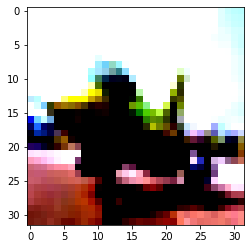

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0434, device='cuda:0')
lossD1
tensor(1.4652, device='cuda:0', grad_fn=<NllLossBackward0>)


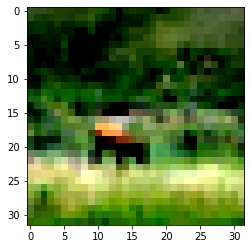

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0449, device='cuda:0')
lossD1
tensor(1.6103, device='cuda:0', grad_fn=<NllLossBackward0>)


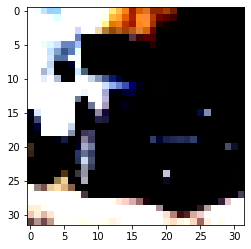

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0182, device='cuda:0')
lossD1
tensor(1.6277, device='cuda:0', grad_fn=<NllLossBackward0>)


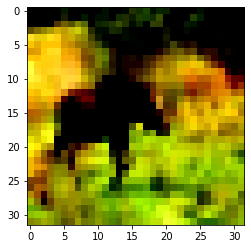

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0671, device='cuda:0')
lossD1
tensor(1.6285, device='cuda:0', grad_fn=<NllLossBackward0>)


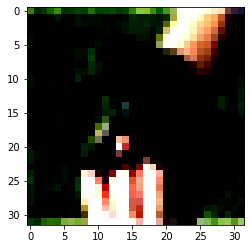

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0213, device='cuda:0')
lossD1
tensor(1.5609, device='cuda:0', grad_fn=<NllLossBackward0>)


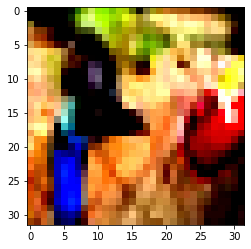

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0239, device='cuda:0')
lossD1
tensor(2.1803, device='cuda:0', grad_fn=<NllLossBackward0>)


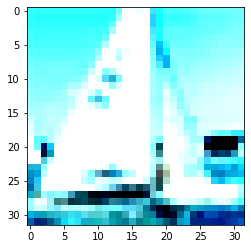

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0465, device='cuda:0')
lossD1
tensor(1.8370, device='cuda:0', grad_fn=<NllLossBackward0>)


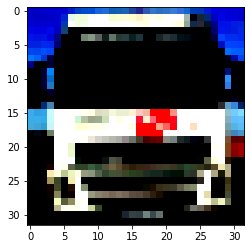

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0264, device='cuda:0')
lossD1
tensor(1.7579, device='cuda:0', grad_fn=<NllLossBackward0>)


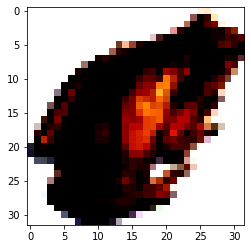

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0896, device='cuda:0')
lossD1
tensor(1.7034, device='cuda:0', grad_fn=<NllLossBackward0>)


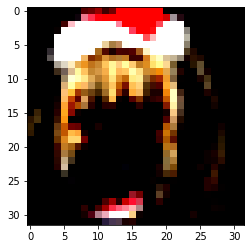

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0089, device='cuda:0')
lossD1
tensor(1.6797, device='cuda:0', grad_fn=<NllLossBackward0>)


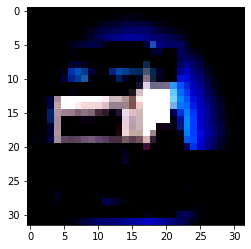

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0004, device='cuda:0')
lossD1
tensor(1.6619, device='cuda:0', grad_fn=<NllLossBackward0>)


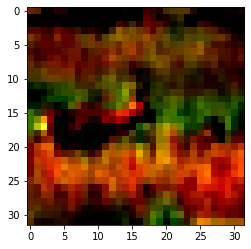

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0810, device='cuda:0')
lossD1
tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>)


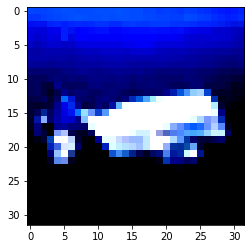

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0692, device='cuda:0')
lossD1
tensor(1.6720, device='cuda:0', grad_fn=<NllLossBackward0>)


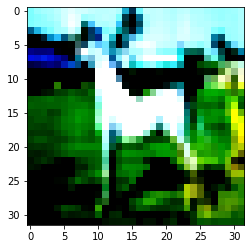

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0423, device='cuda:0')
lossD1
tensor(1.5159, device='cuda:0', grad_fn=<NllLossBackward0>)


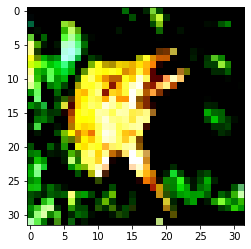

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0382, device='cuda:0')
lossD1
tensor(1.4853, device='cuda:0', grad_fn=<NllLossBackward0>)


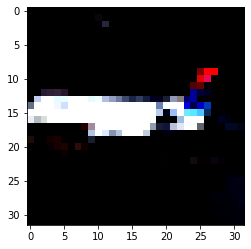

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0636, device='cuda:0')
lossD1
tensor(1.6222, device='cuda:0', grad_fn=<NllLossBackward0>)


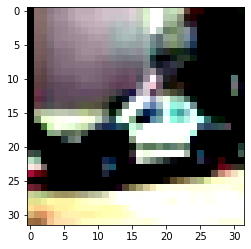

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0572, device='cuda:0')
lossD1
tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)


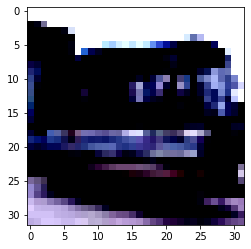

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0097, device='cuda:0')
lossD1
tensor(1.8339, device='cuda:0', grad_fn=<NllLossBackward0>)


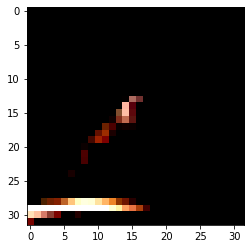

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0064, device='cuda:0')
lossD1
tensor(1.5791, device='cuda:0', grad_fn=<NllLossBackward0>)


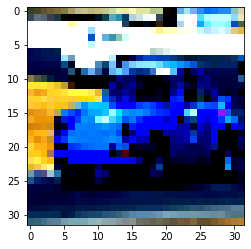

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0045, device='cuda:0')
lossD1
tensor(1.7478, device='cuda:0', grad_fn=<NllLossBackward0>)


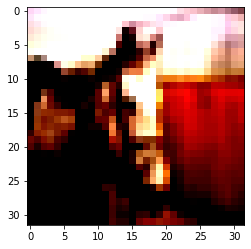

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0195, device='cuda:0')
lossD1
tensor(1.6926, device='cuda:0', grad_fn=<NllLossBackward0>)


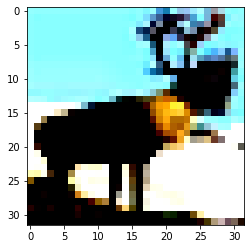

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0056, device='cuda:0')
lossD1
tensor(1.7398, device='cuda:0', grad_fn=<NllLossBackward0>)


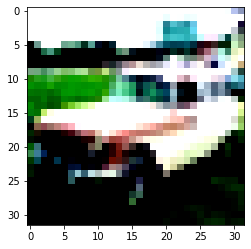

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0023, device='cuda:0')
lossD1
tensor(1.6876, device='cuda:0', grad_fn=<NllLossBackward0>)


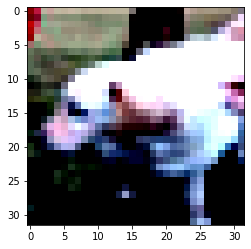

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0023, device='cuda:0')
lossD1
tensor(1.7669, device='cuda:0', grad_fn=<NllLossBackward0>)


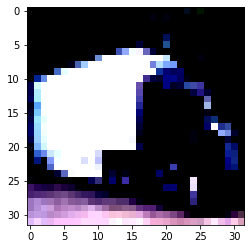

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0069, device='cuda:0')
lossD1
tensor(1.5818, device='cuda:0', grad_fn=<NllLossBackward0>)


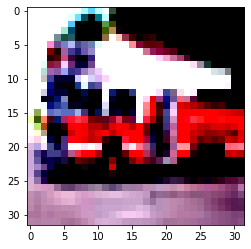

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0009, device='cuda:0')
lossD1
tensor(1.4716, device='cuda:0', grad_fn=<NllLossBackward0>)


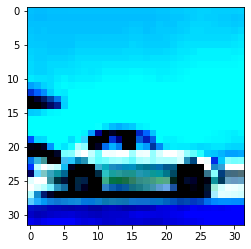

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0171, device='cuda:0')
lossD1
tensor(1.5454, device='cuda:0', grad_fn=<NllLossBackward0>)


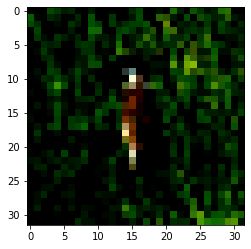

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0183, device='cuda:0')
lossD1
tensor(1.5727, device='cuda:0', grad_fn=<NllLossBackward0>)


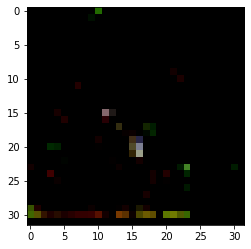

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0161, device='cuda:0')
lossD1
tensor(1.5001, device='cuda:0', grad_fn=<NllLossBackward0>)


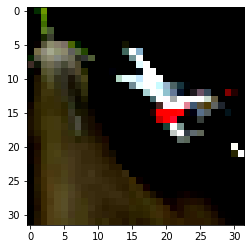

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0171, device='cuda:0')
lossD1
tensor(1.6048, device='cuda:0', grad_fn=<NllLossBackward0>)


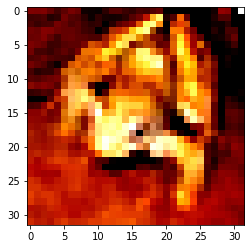

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0528, device='cuda:0')
lossD1
tensor(1.7123, device='cuda:0', grad_fn=<NllLossBackward0>)


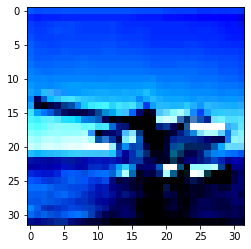

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0486, device='cuda:0')
lossD1
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)


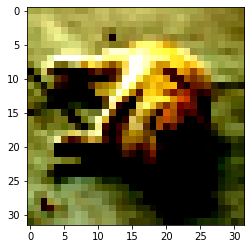

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0134, device='cuda:0')
lossD1
tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)


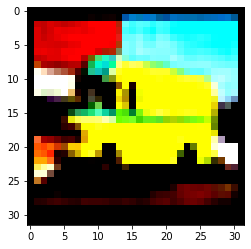

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0572, device='cuda:0')
lossD1
tensor(1.6983, device='cuda:0', grad_fn=<NllLossBackward0>)


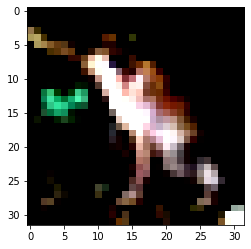

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0025, device='cuda:0')
lossD1
tensor(1.6757, device='cuda:0', grad_fn=<NllLossBackward0>)


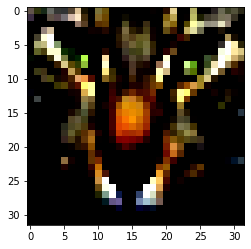

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0233, device='cuda:0')
lossD1
tensor(1.5732, device='cuda:0', grad_fn=<NllLossBackward0>)


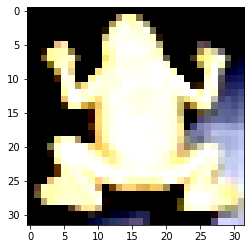

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0036, device='cuda:0')
lossD1
tensor(1.5940, device='cuda:0', grad_fn=<NllLossBackward0>)


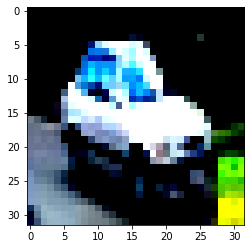

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0090, device='cuda:0')
lossD1
tensor(1.4764, device='cuda:0', grad_fn=<NllLossBackward0>)


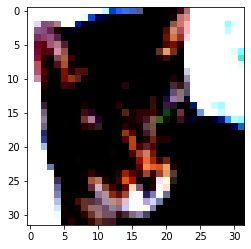

tensor(0.0553, device='cuda:0')
lossD1
tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


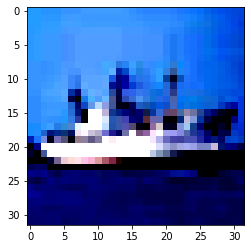

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0554, device='cuda:0')
lossD1
tensor(1.5682, device='cuda:0', grad_fn=<NllLossBackward0>)


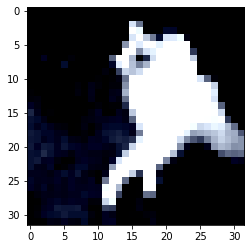

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0060, device='cuda:0')
lossD1
tensor(1.5428, device='cuda:0', grad_fn=<NllLossBackward0>)


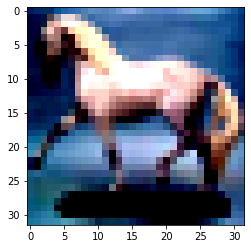

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0038, device='cuda:0')
lossD1
tensor(1.4686, device='cuda:0', grad_fn=<NllLossBackward0>)


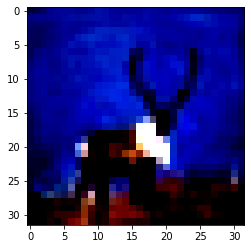

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0155, device='cuda:0')
lossD1
tensor(1.4698, device='cuda:0', grad_fn=<NllLossBackward0>)


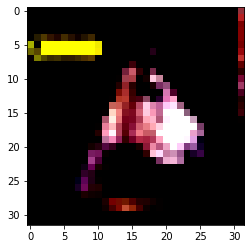

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0759, device='cuda:0')
lossD1
tensor(1.5503, device='cuda:0', grad_fn=<NllLossBackward0>)


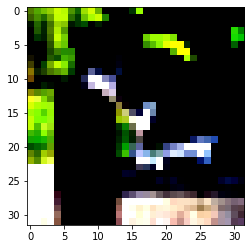

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0532, device='cuda:0')
lossD1
tensor(1.5293, device='cuda:0', grad_fn=<NllLossBackward0>)


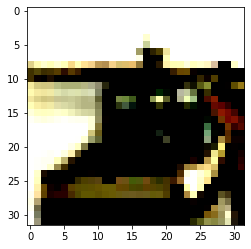

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0383, device='cuda:0')
lossD1
tensor(1.5713, device='cuda:0', grad_fn=<NllLossBackward0>)


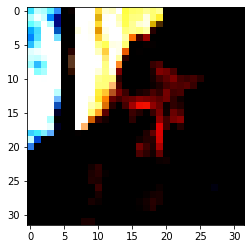

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0732, device='cuda:0')
lossD1
tensor(1.6858, device='cuda:0', grad_fn=<NllLossBackward0>)


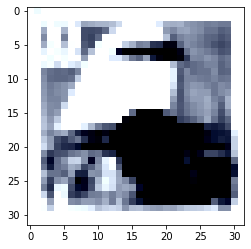

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0381, device='cuda:0')
lossD1
tensor(1.7563, device='cuda:0', grad_fn=<NllLossBackward0>)


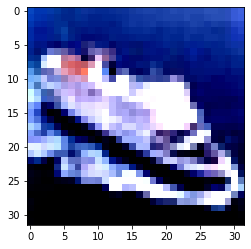

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0424, device='cuda:0')
lossD1
tensor(1.7403, device='cuda:0', grad_fn=<NllLossBackward0>)


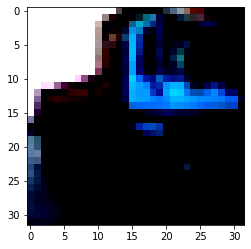

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0174, device='cuda:0')
lossD1
tensor(1.5758, device='cuda:0', grad_fn=<NllLossBackward0>)


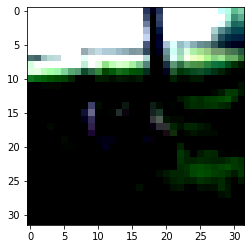

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0323, device='cuda:0')
lossD1
tensor(1.5787, device='cuda:0', grad_fn=<NllLossBackward0>)


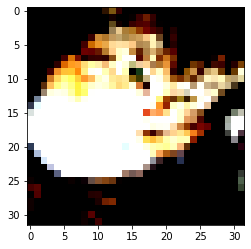

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0372, device='cuda:0')
lossD1
tensor(1.5764, device='cuda:0', grad_fn=<NllLossBackward0>)


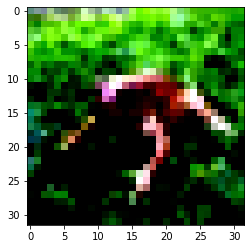

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0134, device='cuda:0')
lossD1
tensor(1.5445, device='cuda:0', grad_fn=<NllLossBackward0>)


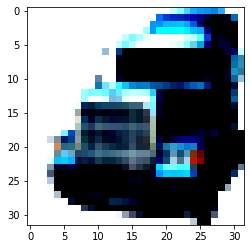

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0360, device='cuda:0')
lossD1
tensor(1.5080, device='cuda:0', grad_fn=<NllLossBackward0>)


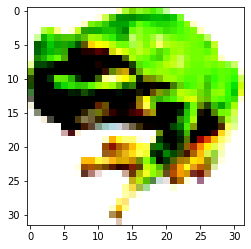

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0308, device='cuda:0')
lossD1
tensor(1.4652, device='cuda:0', grad_fn=<NllLossBackward0>)


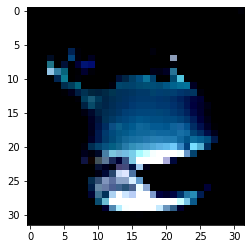

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0507, device='cuda:0')
lossD1
tensor(1.7892, device='cuda:0', grad_fn=<NllLossBackward0>)


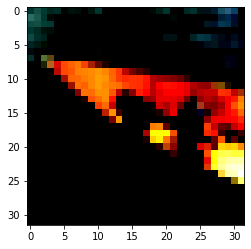

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0092, device='cuda:0')
lossD1
tensor(1.6576, device='cuda:0', grad_fn=<NllLossBackward0>)


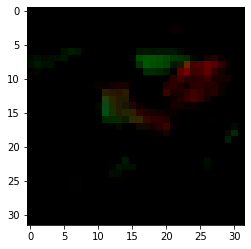

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0046, device='cuda:0')
lossD1
tensor(1.5632, device='cuda:0', grad_fn=<NllLossBackward0>)


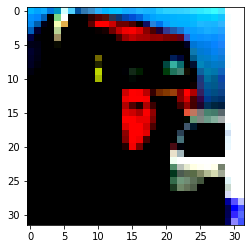

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0478, device='cuda:0')
lossD1
tensor(1.5596, device='cuda:0', grad_fn=<NllLossBackward0>)


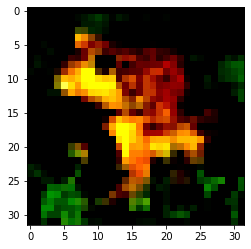

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0266, device='cuda:0')
lossD1
tensor(1.6355, device='cuda:0', grad_fn=<NllLossBackward0>)


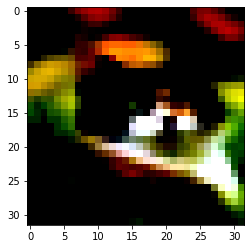

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0304, device='cuda:0')
lossD1
tensor(1.5857, device='cuda:0', grad_fn=<NllLossBackward0>)


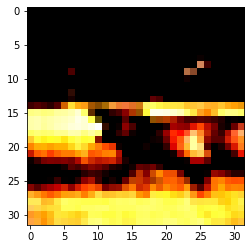

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0284, device='cuda:0')
lossD1
tensor(1.4765, device='cuda:0', grad_fn=<NllLossBackward0>)


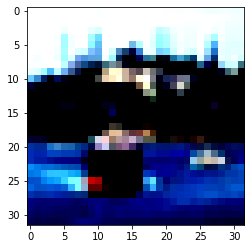

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0228, device='cuda:0')
lossD1
tensor(1.4921, device='cuda:0', grad_fn=<NllLossBackward0>)


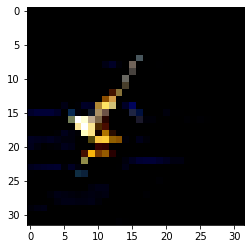

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0417, device='cuda:0')
lossD1
tensor(1.4289, device='cuda:0', grad_fn=<NllLossBackward0>)


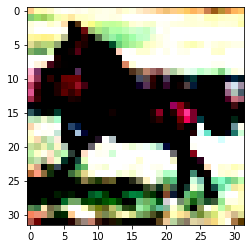

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0066, device='cuda:0')
lossD1
tensor(1.4714, device='cuda:0', grad_fn=<NllLossBackward0>)


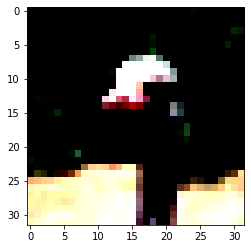

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0258, device='cuda:0')
lossD1
tensor(1.6487, device='cuda:0', grad_fn=<NllLossBackward0>)


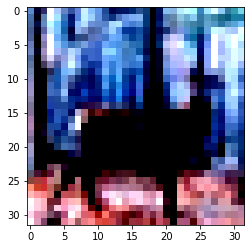

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0512, device='cuda:0')
lossD1
tensor(1.5633, device='cuda:0', grad_fn=<NllLossBackward0>)


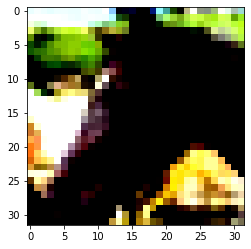

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0171, device='cuda:0')
lossD1
tensor(1.5750, device='cuda:0', grad_fn=<NllLossBackward0>)


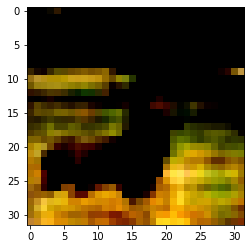

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0275, device='cuda:0')
lossD1
tensor(1.4233, device='cuda:0', grad_fn=<NllLossBackward0>)


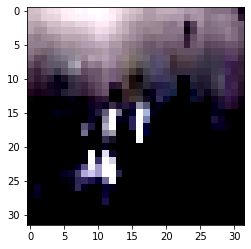

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0629, device='cuda:0')
lossD1
tensor(1.4630, device='cuda:0', grad_fn=<NllLossBackward0>)


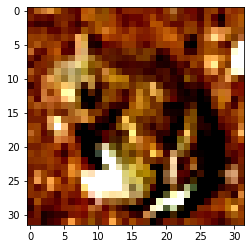

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0168, device='cuda:0')
lossD1
tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)


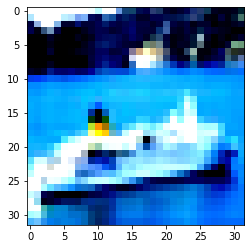

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0034, device='cuda:0')
lossD1
tensor(1.4838, device='cuda:0', grad_fn=<NllLossBackward0>)


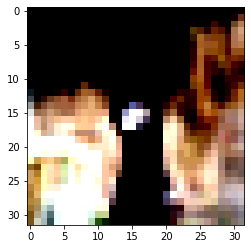

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0337, device='cuda:0')
lossD1
tensor(1.4506, device='cuda:0', grad_fn=<NllLossBackward0>)


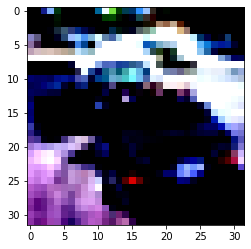

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0318, device='cuda:0')
lossD1
tensor(1.6686, device='cuda:0', grad_fn=<NllLossBackward0>)


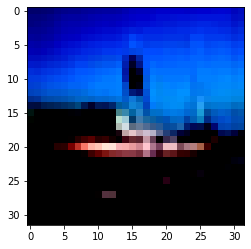

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0107, device='cuda:0')
lossD1
tensor(1.9372, device='cuda:0', grad_fn=<NllLossBackward0>)


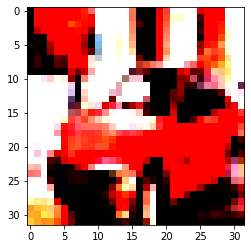

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1532, device='cuda:0')
lossD1
tensor(1.7505, device='cuda:0', grad_fn=<NllLossBackward0>)


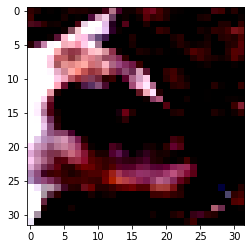

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0530, device='cuda:0')
lossD1
tensor(1.8582, device='cuda:0', grad_fn=<NllLossBackward0>)


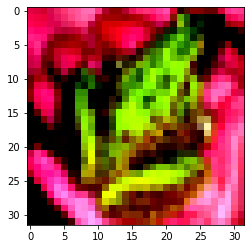

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0625, device='cuda:0')
lossD1
tensor(1.8454, device='cuda:0', grad_fn=<NllLossBackward0>)


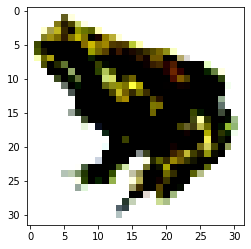

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0022, device='cuda:0')
lossD1
tensor(1.6328, device='cuda:0', grad_fn=<NllLossBackward0>)


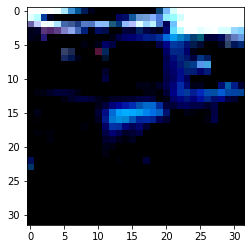

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0086, device='cuda:0')
lossD1
tensor(1.6713, device='cuda:0', grad_fn=<NllLossBackward0>)


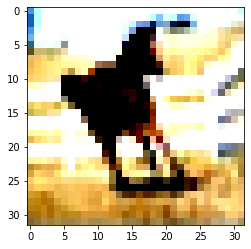

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0176, device='cuda:0')
lossD1
tensor(1.6133, device='cuda:0', grad_fn=<NllLossBackward0>)


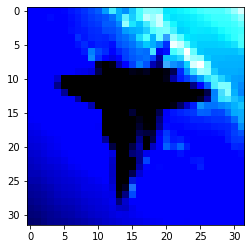

tensor(0.0027, device='cuda:0')
lossD1
tensor(1.5200, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


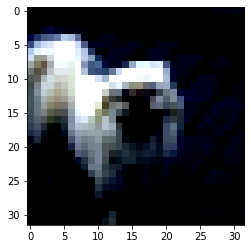

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0117, device='cuda:0')
lossD1
tensor(1.5734, device='cuda:0', grad_fn=<NllLossBackward0>)


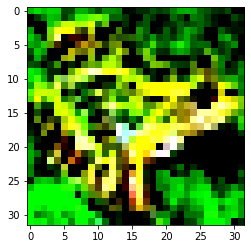

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0149, device='cuda:0')
lossD1
tensor(1.5798, device='cuda:0', grad_fn=<NllLossBackward0>)


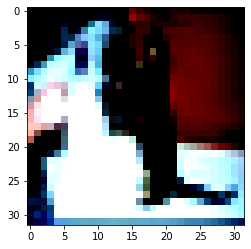

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0149, device='cuda:0')
lossD1
tensor(1.5938, device='cuda:0', grad_fn=<NllLossBackward0>)


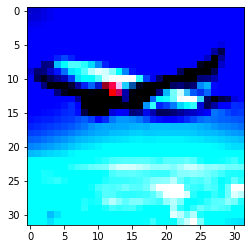

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0203, device='cuda:0')
lossD1
tensor(1.6115, device='cuda:0', grad_fn=<NllLossBackward0>)


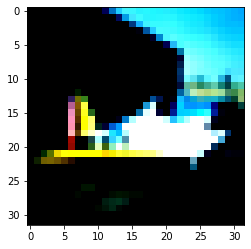

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0394, device='cuda:0')
lossD1
tensor(1.6613, device='cuda:0', grad_fn=<NllLossBackward0>)


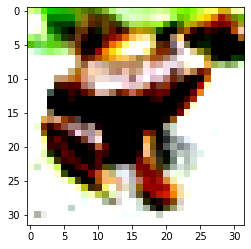

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0040, device='cuda:0')
lossD1
tensor(1.6529, device='cuda:0', grad_fn=<NllLossBackward0>)


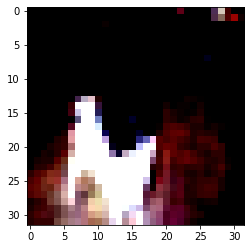

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0109, device='cuda:0')
lossD1
tensor(1.4303, device='cuda:0', grad_fn=<NllLossBackward0>)


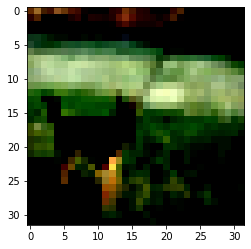

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0412, device='cuda:0')
lossD1
tensor(1.5374, device='cuda:0', grad_fn=<NllLossBackward0>)


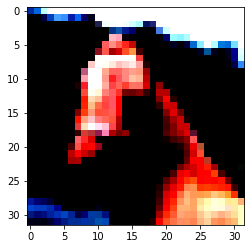

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0564, device='cuda:0')
lossD1
tensor(1.5469, device='cuda:0', grad_fn=<NllLossBackward0>)


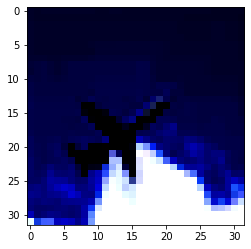

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0458, device='cuda:0')
lossD1
tensor(1.7755, device='cuda:0', grad_fn=<NllLossBackward0>)


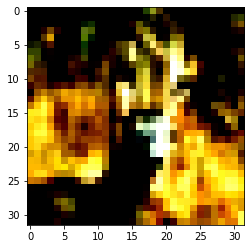

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0401, device='cuda:0')
lossD1
tensor(1.6049, device='cuda:0', grad_fn=<NllLossBackward0>)


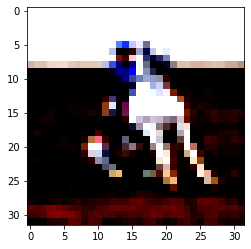

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0032, device='cuda:0')
lossD1
tensor(1.4669, device='cuda:0', grad_fn=<NllLossBackward0>)


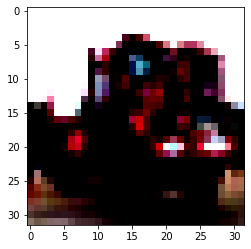

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0152, device='cuda:0')
lossD1
tensor(1.4832, device='cuda:0', grad_fn=<NllLossBackward0>)


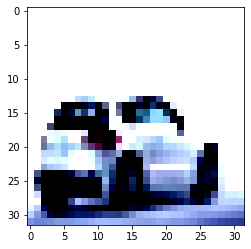

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0364, device='cuda:0')
lossD1
tensor(1.5657, device='cuda:0', grad_fn=<NllLossBackward0>)


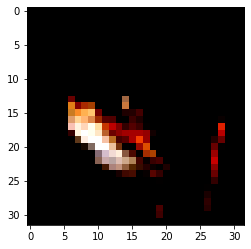

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0355, device='cuda:0')
lossD1
tensor(1.5652, device='cuda:0', grad_fn=<NllLossBackward0>)


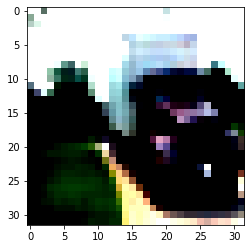

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0279, device='cuda:0')
lossD1
tensor(1.5732, device='cuda:0', grad_fn=<NllLossBackward0>)


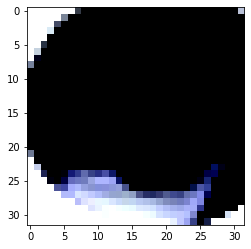

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0479, device='cuda:0')
lossD1
tensor(1.5791, device='cuda:0', grad_fn=<NllLossBackward0>)


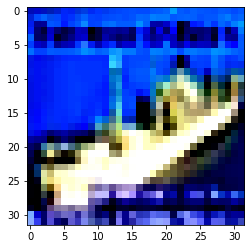

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0144, device='cuda:0')
lossD1
tensor(1.4976, device='cuda:0', grad_fn=<NllLossBackward0>)


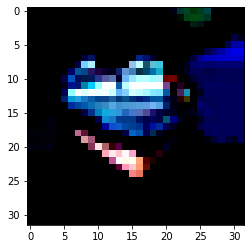

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0289, device='cuda:0')
lossD1
tensor(1.5778, device='cuda:0', grad_fn=<NllLossBackward0>)


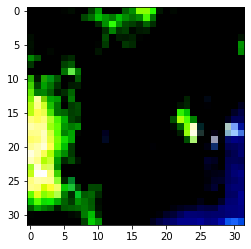

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0500, device='cuda:0')
lossD1
tensor(1.5157, device='cuda:0', grad_fn=<NllLossBackward0>)


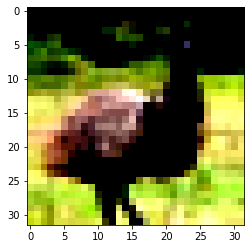

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0285, device='cuda:0')
lossD1
tensor(1.4500, device='cuda:0', grad_fn=<NllLossBackward0>)


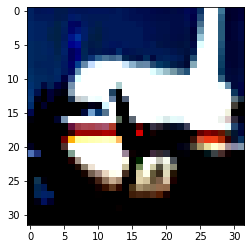

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0077, device='cuda:0')
lossD1
tensor(1.5736, device='cuda:0', grad_fn=<NllLossBackward0>)


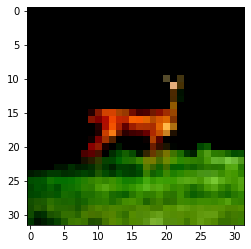

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0505, device='cuda:0')
lossD1
tensor(1.4727, device='cuda:0', grad_fn=<NllLossBackward0>)


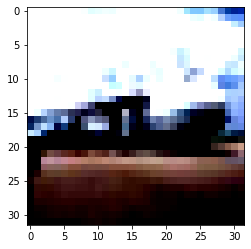

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0510, device='cuda:0')
lossD1
tensor(1.5447, device='cuda:0', grad_fn=<NllLossBackward0>)


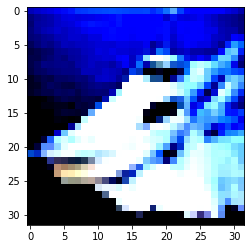

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0620, device='cuda:0')
lossD1
tensor(1.8587, device='cuda:0', grad_fn=<NllLossBackward0>)


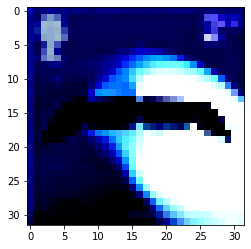

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0023, device='cuda:0')
lossD1
tensor(1.8930, device='cuda:0', grad_fn=<NllLossBackward0>)


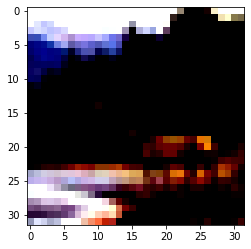

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0339, device='cuda:0')
lossD1
tensor(1.6585, device='cuda:0', grad_fn=<NllLossBackward0>)


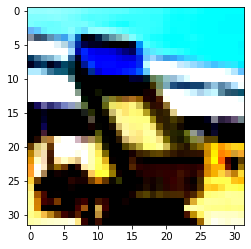

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0090, device='cuda:0')
lossD1
tensor(1.7750, device='cuda:0', grad_fn=<NllLossBackward0>)


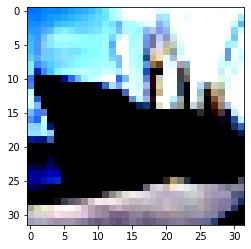

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0758, device='cuda:0')
lossD1
tensor(1.6441, device='cuda:0', grad_fn=<NllLossBackward0>)


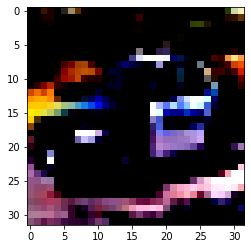

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0094, device='cuda:0')
lossD1
tensor(1.7158, device='cuda:0', grad_fn=<NllLossBackward0>)


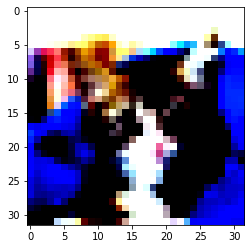

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0066, device='cuda:0')
lossD1
tensor(1.6404, device='cuda:0', grad_fn=<NllLossBackward0>)


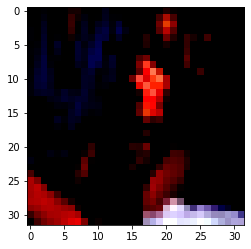

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0089, device='cuda:0')
lossD1
tensor(1.5951, device='cuda:0', grad_fn=<NllLossBackward0>)


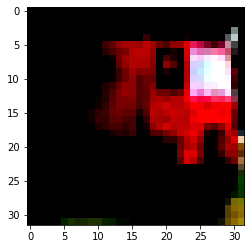

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0222, device='cuda:0')
lossD1
tensor(1.6437, device='cuda:0', grad_fn=<NllLossBackward0>)


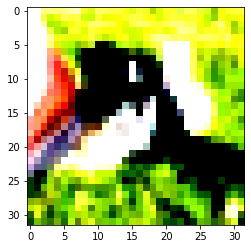

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0027, device='cuda:0')
lossD1
tensor(1.6380, device='cuda:0', grad_fn=<NllLossBackward0>)


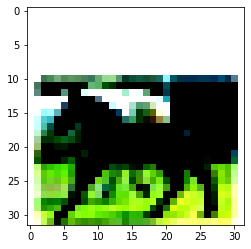

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0366, device='cuda:0')
lossD1
tensor(1.5855, device='cuda:0', grad_fn=<NllLossBackward0>)


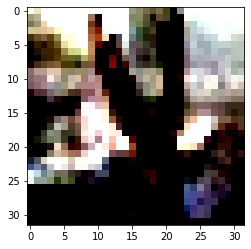

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0080, device='cuda:0')
lossD1
tensor(1.5727, device='cuda:0', grad_fn=<NllLossBackward0>)


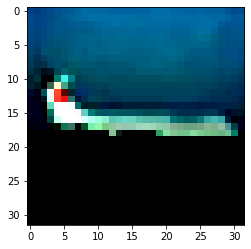

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0258, device='cuda:0')
lossD1
tensor(1.6300, device='cuda:0', grad_fn=<NllLossBackward0>)


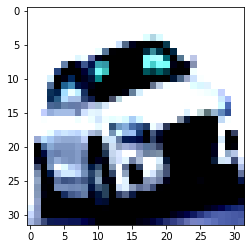

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0156, device='cuda:0')
lossD1
tensor(1.5345, device='cuda:0', grad_fn=<NllLossBackward0>)


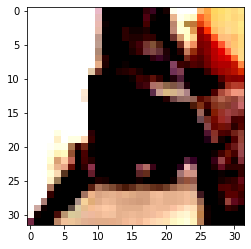

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0385, device='cuda:0')
lossD1
tensor(1.6189, device='cuda:0', grad_fn=<NllLossBackward0>)


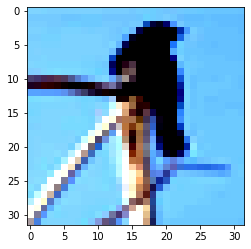

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0078, device='cuda:0')
lossD1
tensor(1.5484, device='cuda:0', grad_fn=<NllLossBackward0>)


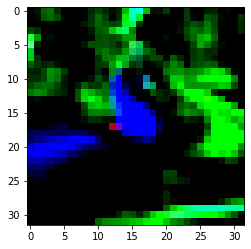

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0153, device='cuda:0')
lossD1
tensor(1.4242, device='cuda:0', grad_fn=<NllLossBackward0>)


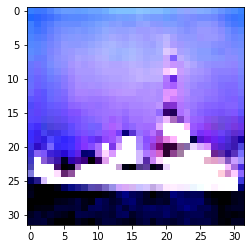

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0203, device='cuda:0')
lossD1
tensor(1.5757, device='cuda:0', grad_fn=<NllLossBackward0>)


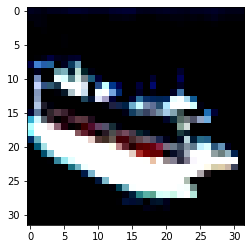

tensor(0.0015, device='cuda:0')
lossD1
tensor(1.6869, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


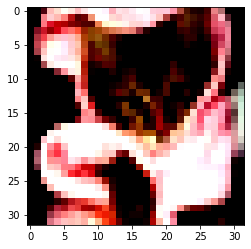

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0268, device='cuda:0')
lossD1
tensor(1.5643, device='cuda:0', grad_fn=<NllLossBackward0>)


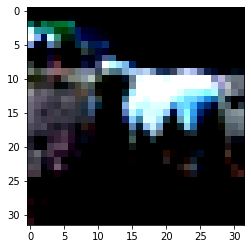

tensor(-0.0357, device='cuda:0')
lossD1
tensor(1.5320, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


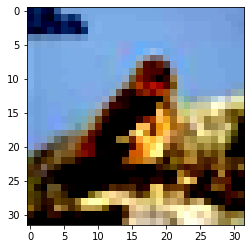

tensor(0.1063, device='cuda:0')
lossD1
tensor(1.4885, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


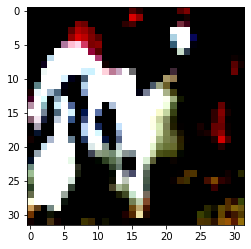

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0305, device='cuda:0')
lossD1
tensor(1.6841, device='cuda:0', grad_fn=<NllLossBackward0>)


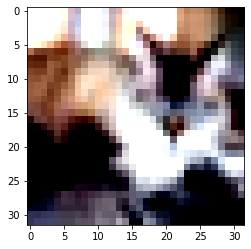

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0634, device='cuda:0')
lossD1
tensor(1.6257, device='cuda:0', grad_fn=<NllLossBackward0>)


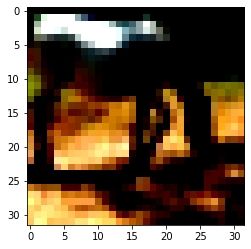

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0523, device='cuda:0')
lossD1
tensor(1.6052, device='cuda:0', grad_fn=<NllLossBackward0>)


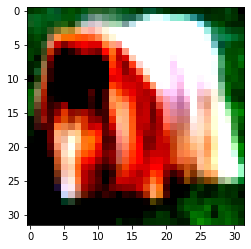

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0338, device='cuda:0')
lossD1
tensor(1.5134, device='cuda:0', grad_fn=<NllLossBackward0>)


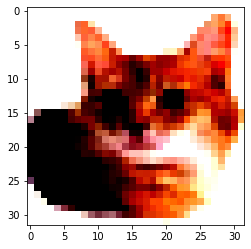

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0585, device='cuda:0')
lossD1
tensor(1.5413, device='cuda:0', grad_fn=<NllLossBackward0>)


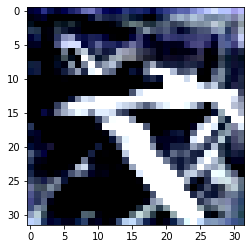

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0339, device='cuda:0')
lossD1
tensor(1.4706, device='cuda:0', grad_fn=<NllLossBackward0>)


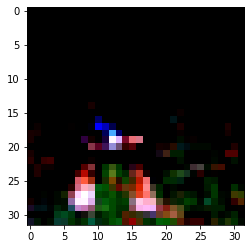

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0628, device='cuda:0')
lossD1
tensor(1.6253, device='cuda:0', grad_fn=<NllLossBackward0>)


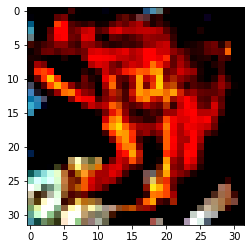

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0022, device='cuda:0')
lossD1
tensor(1.7061, device='cuda:0', grad_fn=<NllLossBackward0>)


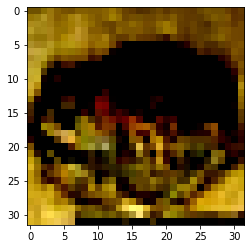

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0239, device='cuda:0')
lossD1
tensor(1.7529, device='cuda:0', grad_fn=<NllLossBackward0>)


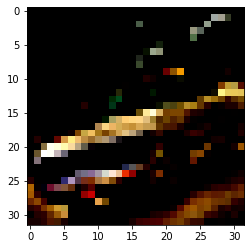

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0188, device='cuda:0')
lossD1
tensor(1.5680, device='cuda:0', grad_fn=<NllLossBackward0>)


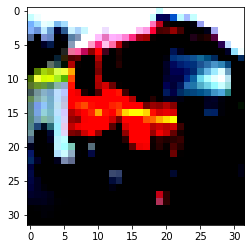

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0268, device='cuda:0')
lossD1
tensor(1.5255, device='cuda:0', grad_fn=<NllLossBackward0>)


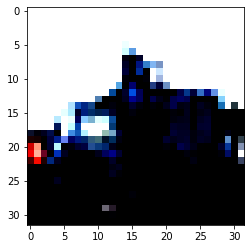

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0089, device='cuda:0')
lossD1
tensor(1.5061, device='cuda:0', grad_fn=<NllLossBackward0>)


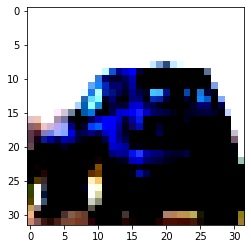

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0184, device='cuda:0')
lossD1
tensor(1.4898, device='cuda:0', grad_fn=<NllLossBackward0>)


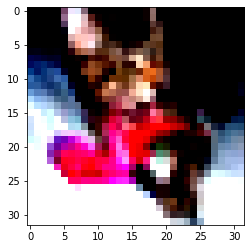

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0348, device='cuda:0')
lossD1
tensor(1.5446, device='cuda:0', grad_fn=<NllLossBackward0>)


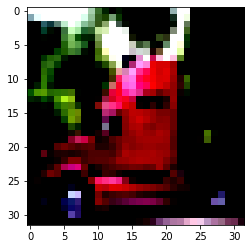

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0260, device='cuda:0')
lossD1
tensor(1.5620, device='cuda:0', grad_fn=<NllLossBackward0>)


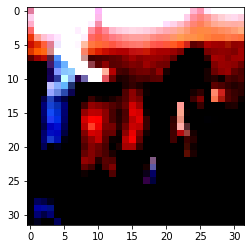

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0036, device='cuda:0')
lossD1
tensor(1.5660, device='cuda:0', grad_fn=<NllLossBackward0>)


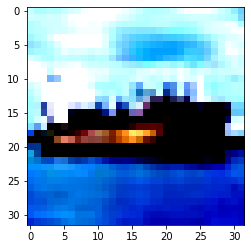

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0302, device='cuda:0')
lossD1
tensor(1.3559, device='cuda:0', grad_fn=<NllLossBackward0>)


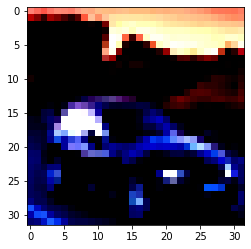

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0426, device='cuda:0')
lossD1
tensor(1.5253, device='cuda:0', grad_fn=<NllLossBackward0>)


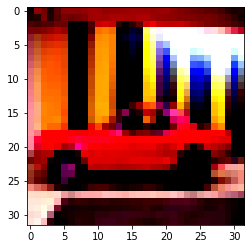

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0552, device='cuda:0')
lossD1
tensor(1.5027, device='cuda:0', grad_fn=<NllLossBackward0>)


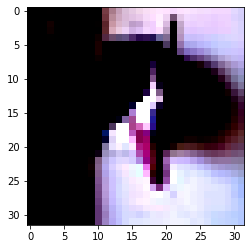

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0151, device='cuda:0')
lossD1
tensor(1.8274, device='cuda:0', grad_fn=<NllLossBackward0>)


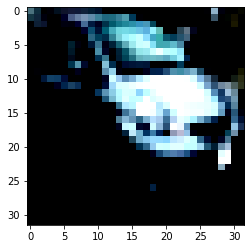

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0196, device='cuda:0')
lossD1
tensor(1.6242, device='cuda:0', grad_fn=<NllLossBackward0>)


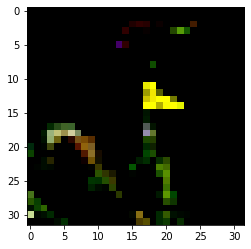

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0459, device='cuda:0')
lossD1
tensor(1.4868, device='cuda:0', grad_fn=<NllLossBackward0>)


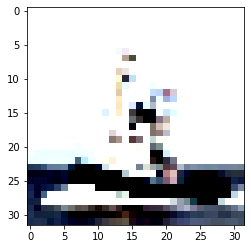

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0716, device='cuda:0')
lossD1
tensor(1.5669, device='cuda:0', grad_fn=<NllLossBackward0>)


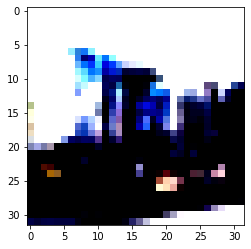

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0304, device='cuda:0')
lossD1
tensor(1.5502, device='cuda:0', grad_fn=<NllLossBackward0>)


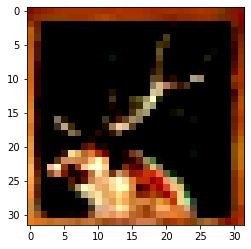

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0234, device='cuda:0')
lossD1
tensor(1.6286, device='cuda:0', grad_fn=<NllLossBackward0>)


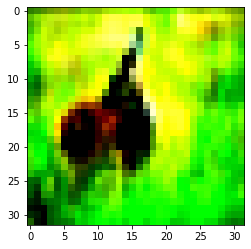

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0412, device='cuda:0')
lossD1
tensor(1.5922, device='cuda:0', grad_fn=<NllLossBackward0>)


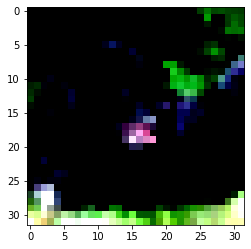

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0641, device='cuda:0')
lossD1
tensor(1.4388, device='cuda:0', grad_fn=<NllLossBackward0>)


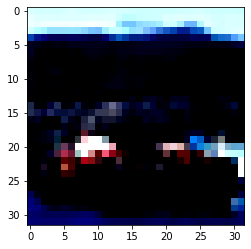

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0485, device='cuda:0')
lossD1
tensor(1.5313, device='cuda:0', grad_fn=<NllLossBackward0>)


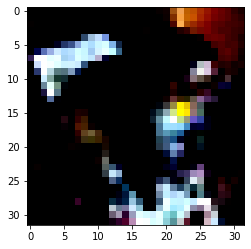

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0406, device='cuda:0')
lossD1
tensor(1.5341, device='cuda:0', grad_fn=<NllLossBackward0>)


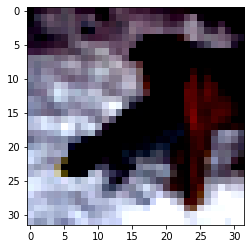

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0278, device='cuda:0')
lossD1
tensor(1.6287, device='cuda:0', grad_fn=<NllLossBackward0>)


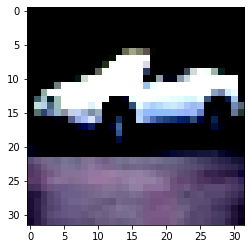

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0358, device='cuda:0')
lossD1
tensor(1.4572, device='cuda:0', grad_fn=<NllLossBackward0>)


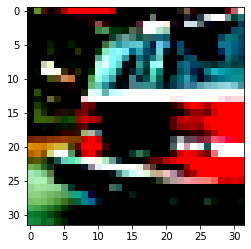

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0787, device='cuda:0')
lossD1
tensor(1.5478, device='cuda:0', grad_fn=<NllLossBackward0>)


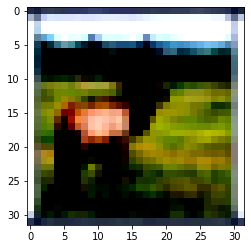

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0028, device='cuda:0')
lossD1
tensor(1.7355, device='cuda:0', grad_fn=<NllLossBackward0>)


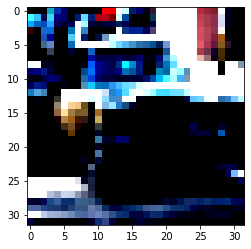

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0209, device='cuda:0')
lossD1
tensor(1.4855, device='cuda:0', grad_fn=<NllLossBackward0>)


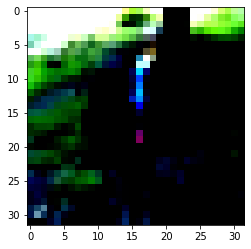

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0375, device='cuda:0')
lossD1
tensor(1.4347, device='cuda:0', grad_fn=<NllLossBackward0>)


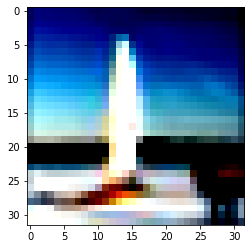

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0052, device='cuda:0')
lossD1
tensor(1.4792, device='cuda:0', grad_fn=<NllLossBackward0>)


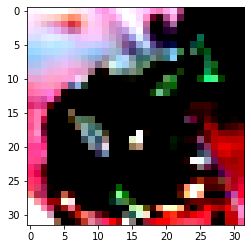

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0324, device='cuda:0')
lossD1
tensor(1.4834, device='cuda:0', grad_fn=<NllLossBackward0>)


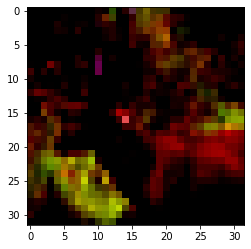

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0468, device='cuda:0')
lossD1
tensor(1.4530, device='cuda:0', grad_fn=<NllLossBackward0>)


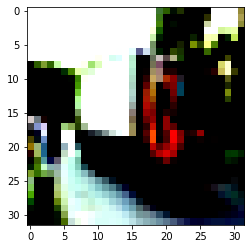

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0702, device='cuda:0')
lossD1
tensor(1.7650, device='cuda:0', grad_fn=<NllLossBackward0>)


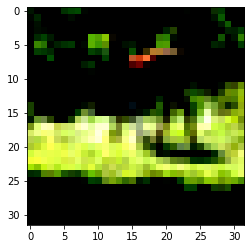

tensor(-0.0009, device='cuda:0')
lossD1
tensor(1.7062, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


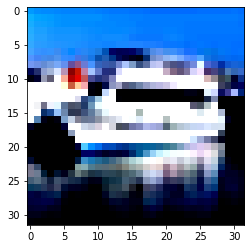

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0326, device='cuda:0')
lossD1
tensor(1.6350, device='cuda:0', grad_fn=<NllLossBackward0>)


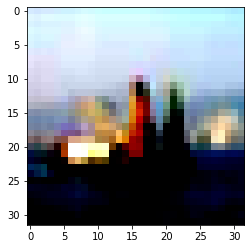

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0462, device='cuda:0')
lossD1
tensor(1.6156, device='cuda:0', grad_fn=<NllLossBackward0>)


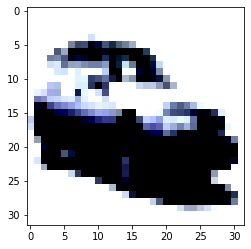

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0902, device='cuda:0')
lossD1
tensor(1.5389, device='cuda:0', grad_fn=<NllLossBackward0>)


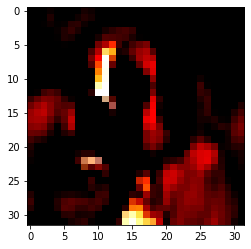

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0386, device='cuda:0')
lossD1
tensor(1.4867, device='cuda:0', grad_fn=<NllLossBackward0>)


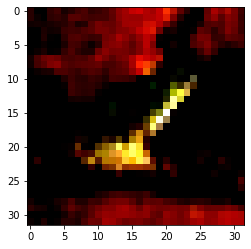

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0232, device='cuda:0')
lossD1
tensor(1.5067, device='cuda:0', grad_fn=<NllLossBackward0>)


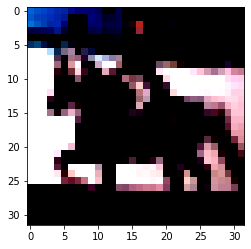

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0339, device='cuda:0')
lossD1
tensor(1.5192, device='cuda:0', grad_fn=<NllLossBackward0>)


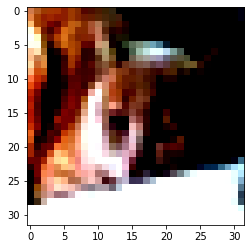

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0478, device='cuda:0')
lossD1
tensor(1.5283, device='cuda:0', grad_fn=<NllLossBackward0>)


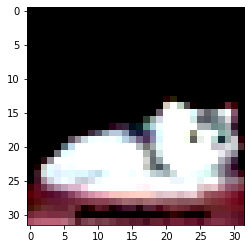

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0594, device='cuda:0')
lossD1
tensor(1.5201, device='cuda:0', grad_fn=<NllLossBackward0>)


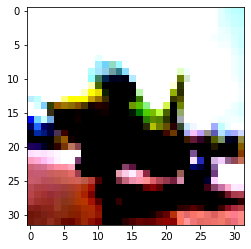

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0325, device='cuda:0')
lossD1
tensor(1.4489, device='cuda:0', grad_fn=<NllLossBackward0>)


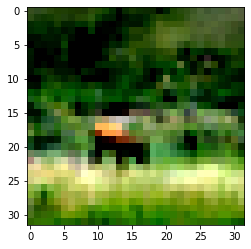

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0290, device='cuda:0')
lossD1
tensor(1.5518, device='cuda:0', grad_fn=<NllLossBackward0>)


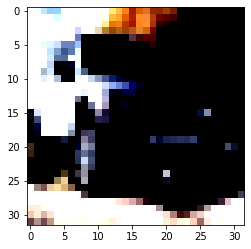

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0311, device='cuda:0')
lossD1
tensor(1.4979, device='cuda:0', grad_fn=<NllLossBackward0>)


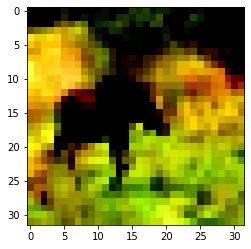

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0694, device='cuda:0')
lossD1
tensor(1.4970, device='cuda:0', grad_fn=<NllLossBackward0>)


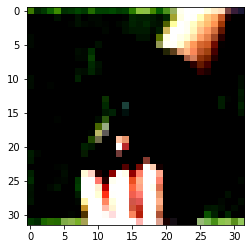

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0715, device='cuda:0')
lossD1
tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)


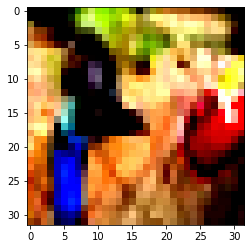

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0436, device='cuda:0')
lossD1
tensor(1.7359, device='cuda:0', grad_fn=<NllLossBackward0>)


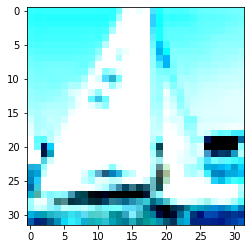

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0271, device='cuda:0')
lossD1
tensor(1.6018, device='cuda:0', grad_fn=<NllLossBackward0>)


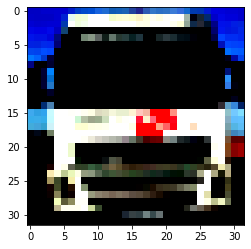

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0010, device='cuda:0')
lossD1
tensor(1.6147, device='cuda:0', grad_fn=<NllLossBackward0>)


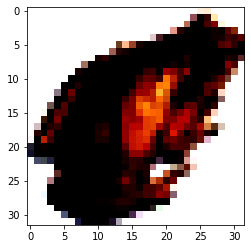

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0639, device='cuda:0')
lossD1
tensor(1.6538, device='cuda:0', grad_fn=<NllLossBackward0>)


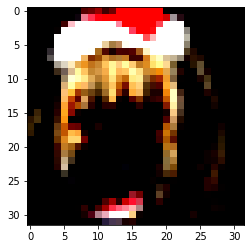

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0188, device='cuda:0')
lossD1
tensor(1.5876, device='cuda:0', grad_fn=<NllLossBackward0>)


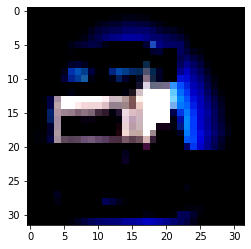

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0001, device='cuda:0')
lossD1
tensor(1.5342, device='cuda:0', grad_fn=<NllLossBackward0>)


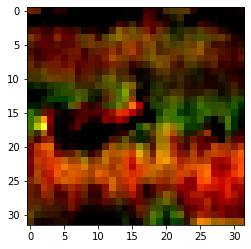

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0791, device='cuda:0')
lossD1
tensor(1.5087, device='cuda:0', grad_fn=<NllLossBackward0>)


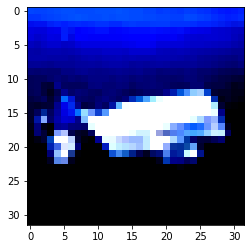

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0543, device='cuda:0')
lossD1
tensor(1.5948, device='cuda:0', grad_fn=<NllLossBackward0>)


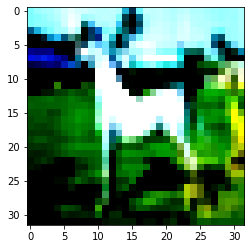

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0392, device='cuda:0')
lossD1
tensor(1.4343, device='cuda:0', grad_fn=<NllLossBackward0>)


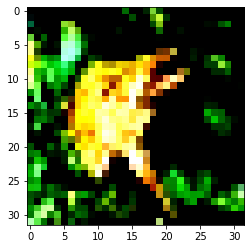

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0270, device='cuda:0')
lossD1
tensor(1.4488, device='cuda:0', grad_fn=<NllLossBackward0>)


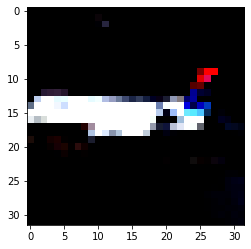

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0626, device='cuda:0')
lossD1
tensor(1.4829, device='cuda:0', grad_fn=<NllLossBackward0>)


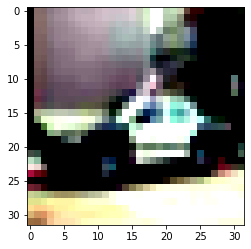

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0296, device='cuda:0')
lossD1
tensor(1.4797, device='cuda:0', grad_fn=<NllLossBackward0>)


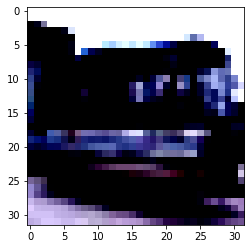

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0300, device='cuda:0')
lossD1
tensor(1.6364, device='cuda:0', grad_fn=<NllLossBackward0>)


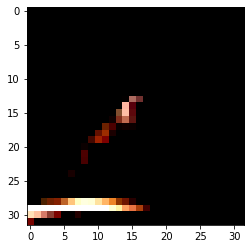

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0255, device='cuda:0')
lossD1
tensor(1.6394, device='cuda:0', grad_fn=<NllLossBackward0>)


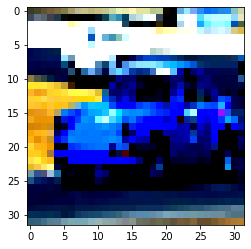

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0338, device='cuda:0')
lossD1
tensor(1.7609, device='cuda:0', grad_fn=<NllLossBackward0>)


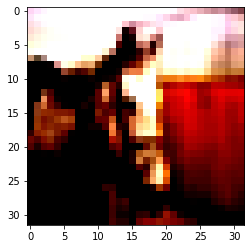

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0082, device='cuda:0')
lossD1
tensor(1.6718, device='cuda:0', grad_fn=<NllLossBackward0>)


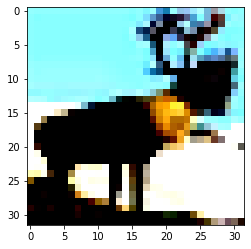

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0020, device='cuda:0')
lossD1
tensor(1.8469, device='cuda:0', grad_fn=<NllLossBackward0>)


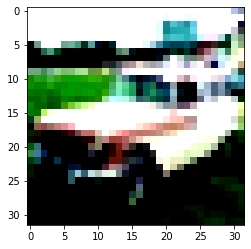

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0073, device='cuda:0')
lossD1
tensor(1.6656, device='cuda:0', grad_fn=<NllLossBackward0>)


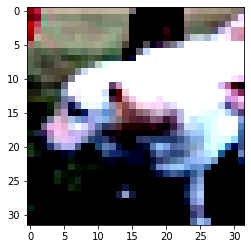

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0066, device='cuda:0')
lossD1
tensor(1.6268, device='cuda:0', grad_fn=<NllLossBackward0>)


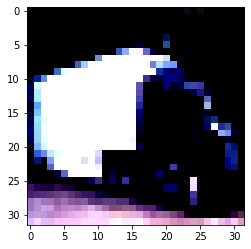

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0059, device='cuda:0')
lossD1
tensor(1.5535, device='cuda:0', grad_fn=<NllLossBackward0>)


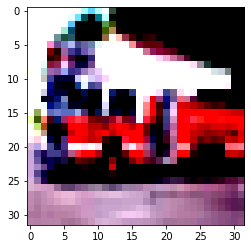

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0027, device='cuda:0')
lossD1
tensor(1.4703, device='cuda:0', grad_fn=<NllLossBackward0>)


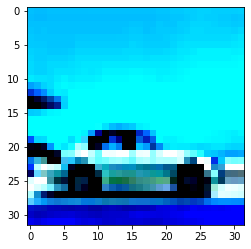

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0129, device='cuda:0')
lossD1
tensor(1.4764, device='cuda:0', grad_fn=<NllLossBackward0>)


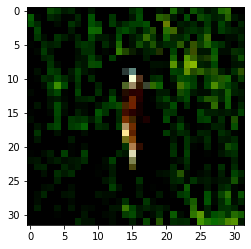

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0053, device='cuda:0')
lossD1
tensor(1.4735, device='cuda:0', grad_fn=<NllLossBackward0>)


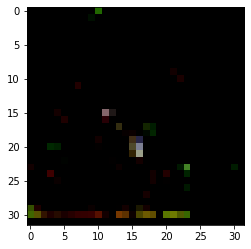

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0193, device='cuda:0')
lossD1
tensor(1.4346, device='cuda:0', grad_fn=<NllLossBackward0>)


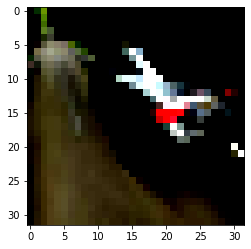

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0123, device='cuda:0')
lossD1
tensor(1.6439, device='cuda:0', grad_fn=<NllLossBackward0>)


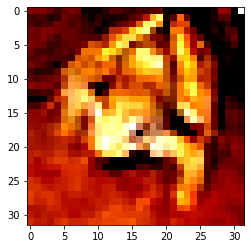

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0312, device='cuda:0')
lossD1
tensor(1.9385, device='cuda:0', grad_fn=<NllLossBackward0>)


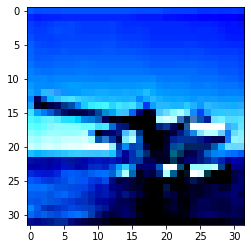

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0586, device='cuda:0')
lossD1
tensor(1.7522, device='cuda:0', grad_fn=<NllLossBackward0>)


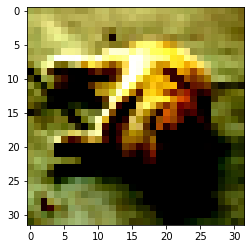

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0212, device='cuda:0')
lossD1
tensor(1.7295, device='cuda:0', grad_fn=<NllLossBackward0>)


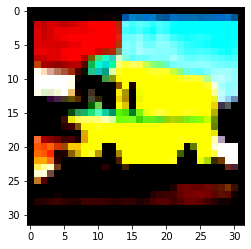

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0251, device='cuda:0')
lossD1
tensor(1.7037, device='cuda:0', grad_fn=<NllLossBackward0>)


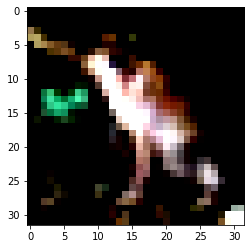

tensor(-0.0105, device='cuda:0')
lossD1
tensor(1.6659, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


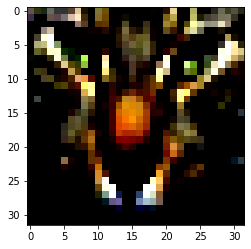

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0155, device='cuda:0')
lossD1
tensor(1.5114, device='cuda:0', grad_fn=<NllLossBackward0>)


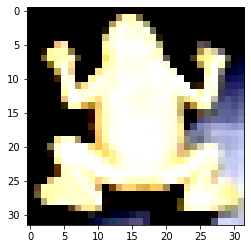

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0108, device='cuda:0')
lossD1
tensor(1.5754, device='cuda:0', grad_fn=<NllLossBackward0>)


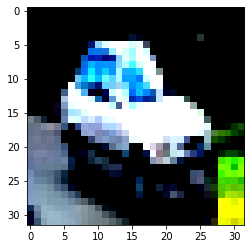

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0232, device='cuda:0')
lossD1
tensor(1.6687, device='cuda:0', grad_fn=<NllLossBackward0>)


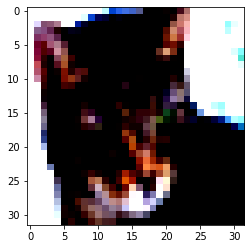

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0261, device='cuda:0')
lossD1
tensor(1.6542, device='cuda:0', grad_fn=<NllLossBackward0>)


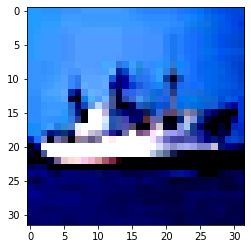

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0409, device='cuda:0')
lossD1
tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)


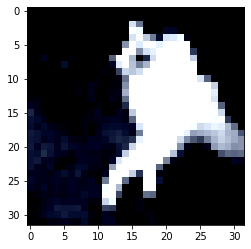

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0113, device='cuda:0')
lossD1
tensor(1.6163, device='cuda:0', grad_fn=<NllLossBackward0>)


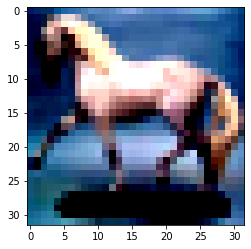

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0050, device='cuda:0')
lossD1
tensor(1.5374, device='cuda:0', grad_fn=<NllLossBackward0>)


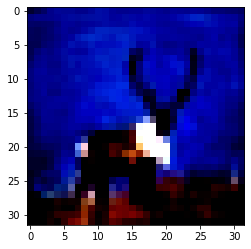

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0027, device='cuda:0')
lossD1
tensor(1.5048, device='cuda:0', grad_fn=<NllLossBackward0>)


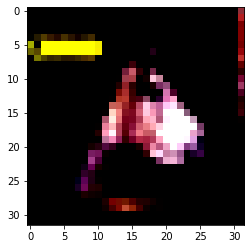

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0696, device='cuda:0')
lossD1
tensor(1.5389, device='cuda:0', grad_fn=<NllLossBackward0>)


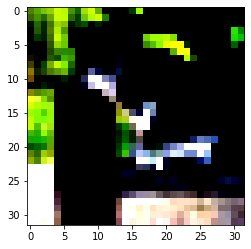

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0481, device='cuda:0')
lossD1
tensor(1.4437, device='cuda:0', grad_fn=<NllLossBackward0>)


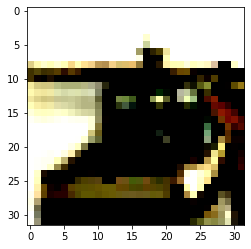

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0571, device='cuda:0')
lossD1
tensor(1.5400, device='cuda:0', grad_fn=<NllLossBackward0>)


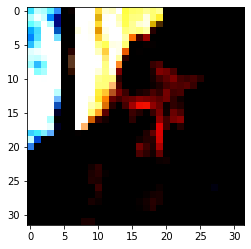

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0803, device='cuda:0')
lossD1
tensor(1.5295, device='cuda:0', grad_fn=<NllLossBackward0>)


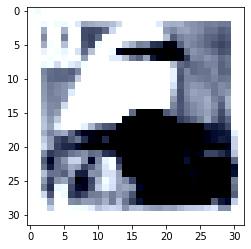

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0261, device='cuda:0')
lossD1
tensor(1.5159, device='cuda:0', grad_fn=<NllLossBackward0>)


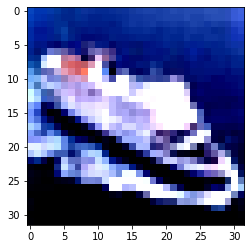

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0242, device='cuda:0')
lossD1
tensor(1.6031, device='cuda:0', grad_fn=<NllLossBackward0>)


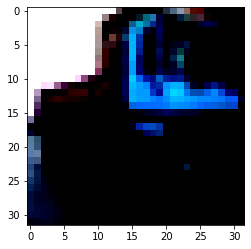

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0022, device='cuda:0')
lossD1
tensor(1.5197, device='cuda:0', grad_fn=<NllLossBackward0>)


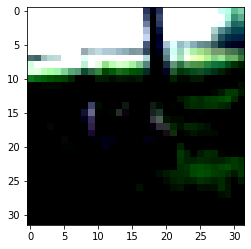

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0179, device='cuda:0')
lossD1
tensor(1.4564, device='cuda:0', grad_fn=<NllLossBackward0>)


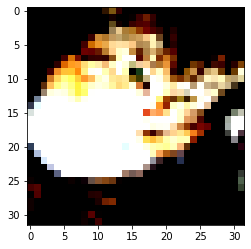

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0379, device='cuda:0')
lossD1
tensor(1.5583, device='cuda:0', grad_fn=<NllLossBackward0>)


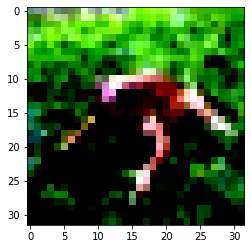

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0069, device='cuda:0')
lossD1
tensor(1.5714, device='cuda:0', grad_fn=<NllLossBackward0>)


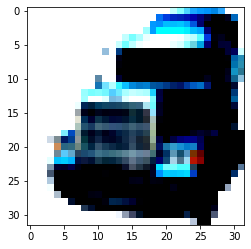

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0121, device='cuda:0')
lossD1
tensor(1.6266, device='cuda:0', grad_fn=<NllLossBackward0>)


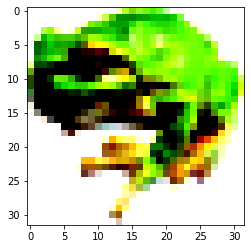

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0201, device='cuda:0')
lossD1
tensor(1.6666, device='cuda:0', grad_fn=<NllLossBackward0>)


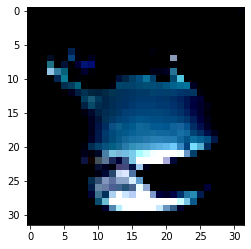

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0296, device='cuda:0')
lossD1
tensor(1.7251, device='cuda:0', grad_fn=<NllLossBackward0>)


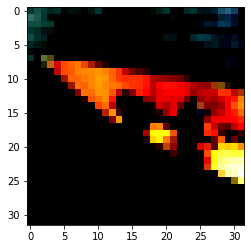

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0007, device='cuda:0')
lossD1
tensor(1.7173, device='cuda:0', grad_fn=<NllLossBackward0>)


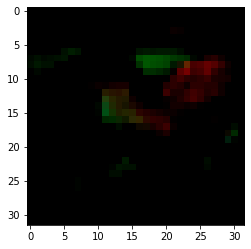

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0384, device='cuda:0')
lossD1
tensor(1.5008, device='cuda:0', grad_fn=<NllLossBackward0>)


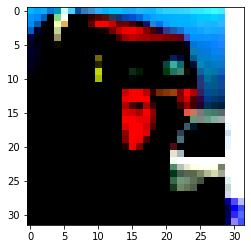

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0040, device='cuda:0')
lossD1
tensor(1.5063, device='cuda:0', grad_fn=<NllLossBackward0>)


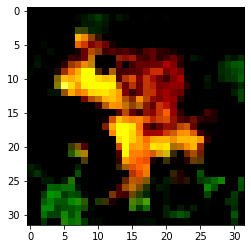

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0005, device='cuda:0')
lossD1
tensor(1.5548, device='cuda:0', grad_fn=<NllLossBackward0>)


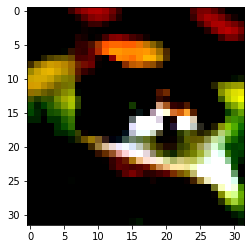

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0294, device='cuda:0')
lossD1
tensor(1.5868, device='cuda:0', grad_fn=<NllLossBackward0>)


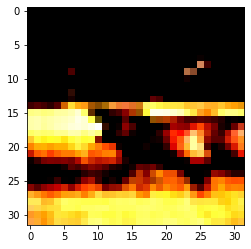

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0517, device='cuda:0')
lossD1
tensor(1.5110, device='cuda:0', grad_fn=<NllLossBackward0>)


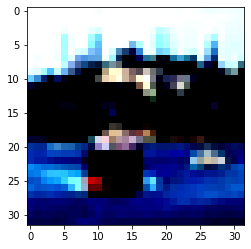

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0111, device='cuda:0')
lossD1
tensor(1.4765, device='cuda:0', grad_fn=<NllLossBackward0>)


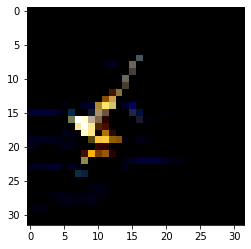

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0072, device='cuda:0')
lossD1
tensor(1.3680, device='cuda:0', grad_fn=<NllLossBackward0>)


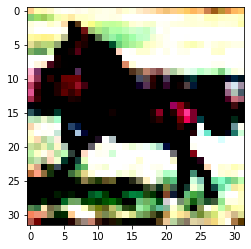

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0112, device='cuda:0')
lossD1
tensor(1.4407, device='cuda:0', grad_fn=<NllLossBackward0>)


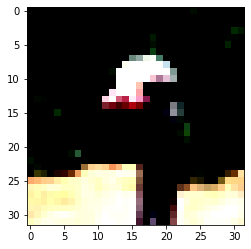

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0147, device='cuda:0')
lossD1
tensor(1.5641, device='cuda:0', grad_fn=<NllLossBackward0>)


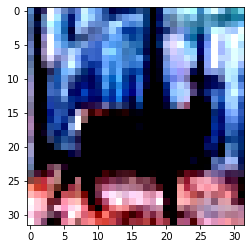

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0362, device='cuda:0')
lossD1
tensor(1.5127, device='cuda:0', grad_fn=<NllLossBackward0>)


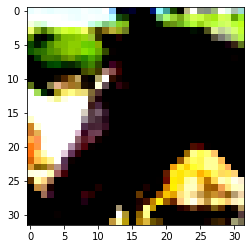

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0241, device='cuda:0')
lossD1
tensor(1.5103, device='cuda:0', grad_fn=<NllLossBackward0>)


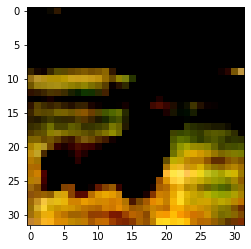

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0157, device='cuda:0')
lossD1
tensor(1.3526, device='cuda:0', grad_fn=<NllLossBackward0>)


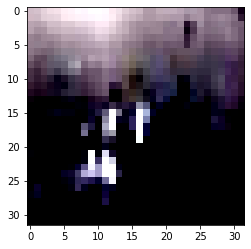

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0501, device='cuda:0')
lossD1
tensor(1.3896, device='cuda:0', grad_fn=<NllLossBackward0>)


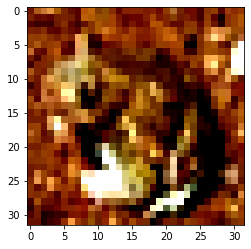

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0146, device='cuda:0')
lossD1
tensor(1.3751, device='cuda:0', grad_fn=<NllLossBackward0>)


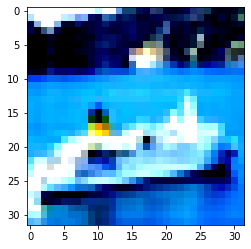

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0037, device='cuda:0')
lossD1
tensor(1.3970, device='cuda:0', grad_fn=<NllLossBackward0>)


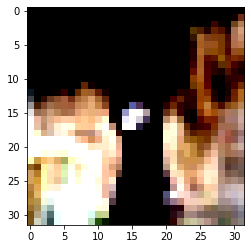

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0261, device='cuda:0')
lossD1
tensor(1.4488, device='cuda:0', grad_fn=<NllLossBackward0>)


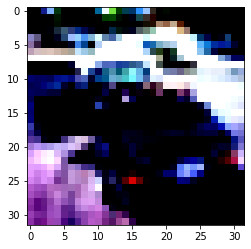

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0327, device='cuda:0')
lossD1
tensor(1.8512, device='cuda:0', grad_fn=<NllLossBackward0>)


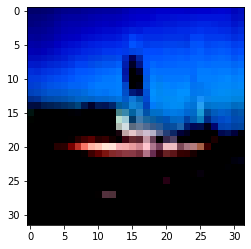

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0289, device='cuda:0')
lossD1
tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)


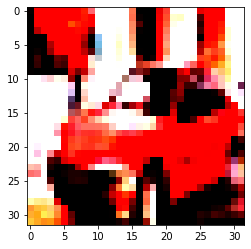

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1227, device='cuda:0')
lossD1
tensor(1.9092, device='cuda:0', grad_fn=<NllLossBackward0>)


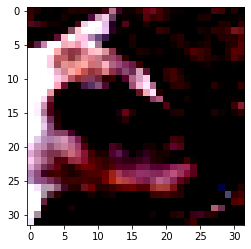

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0581, device='cuda:0')
lossD1
tensor(2.2063, device='cuda:0', grad_fn=<NllLossBackward0>)


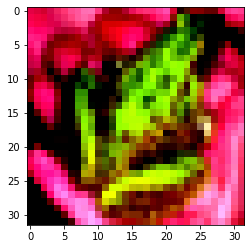

tensor(-0.0626, device='cuda:0')
lossD1
tensor(1.8589, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


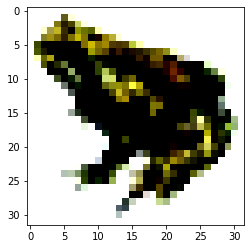

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1137, device='cuda:0')
lossD1
tensor(1.9441, device='cuda:0', grad_fn=<NllLossBackward0>)


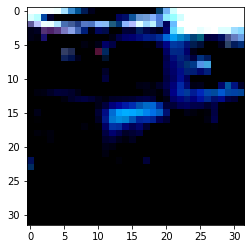

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0037, device='cuda:0')
lossD1
tensor(1.8626, device='cuda:0', grad_fn=<NllLossBackward0>)


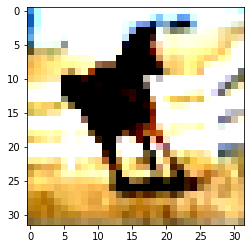

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0291, device='cuda:0')
lossD1
tensor(1.8320, device='cuda:0', grad_fn=<NllLossBackward0>)


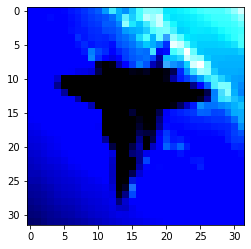

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0140, device='cuda:0')
lossD1
tensor(1.6398, device='cuda:0', grad_fn=<NllLossBackward0>)


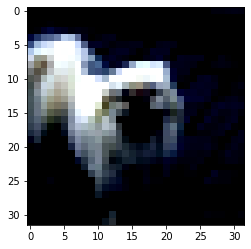

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0034, device='cuda:0')
lossD1
tensor(1.6550, device='cuda:0', grad_fn=<NllLossBackward0>)


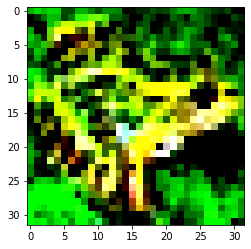

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0118, device='cuda:0')
lossD1
tensor(1.5651, device='cuda:0', grad_fn=<NllLossBackward0>)


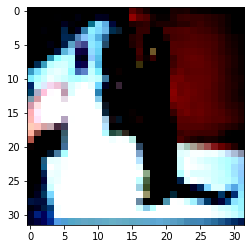

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0029, device='cuda:0')
lossD1
tensor(1.6285, device='cuda:0', grad_fn=<NllLossBackward0>)


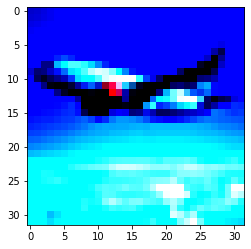

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0423, device='cuda:0')
lossD1
tensor(1.7868, device='cuda:0', grad_fn=<NllLossBackward0>)


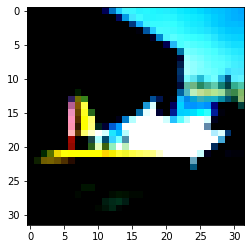

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0231, device='cuda:0')
lossD1
tensor(1.8638, device='cuda:0', grad_fn=<NllLossBackward0>)


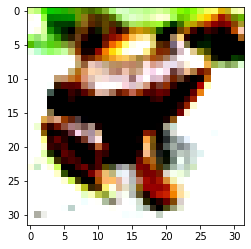

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0007, device='cuda:0')
lossD1
tensor(1.6977, device='cuda:0', grad_fn=<NllLossBackward0>)


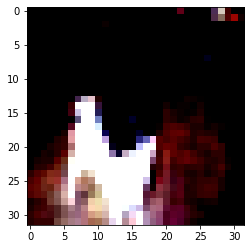

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0186, device='cuda:0')
lossD1
tensor(1.4968, device='cuda:0', grad_fn=<NllLossBackward0>)


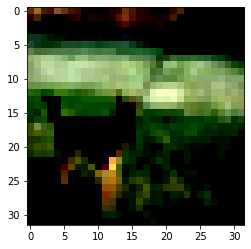

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0215, device='cuda:0')
lossD1
tensor(1.6009, device='cuda:0', grad_fn=<NllLossBackward0>)


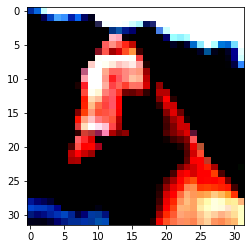

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0444, device='cuda:0')
lossD1
tensor(1.5002, device='cuda:0', grad_fn=<NllLossBackward0>)


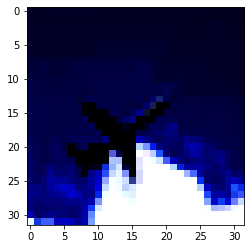

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0471, device='cuda:0')
lossD1
tensor(1.6852, device='cuda:0', grad_fn=<NllLossBackward0>)


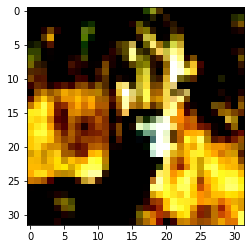

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0378, device='cuda:0')
lossD1
tensor(1.4521, device='cuda:0', grad_fn=<NllLossBackward0>)


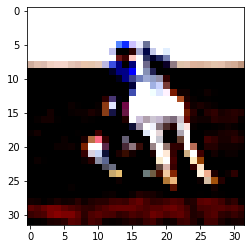

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0274, device='cuda:0')
lossD1
tensor(1.3373, device='cuda:0', grad_fn=<NllLossBackward0>)


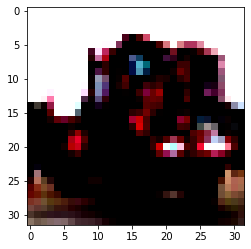

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0677, device='cuda:0')
lossD1
tensor(1.4362, device='cuda:0', grad_fn=<NllLossBackward0>)


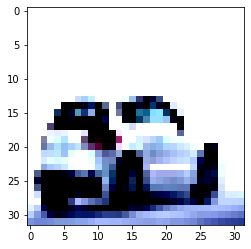

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0611, device='cuda:0')
lossD1
tensor(1.4910, device='cuda:0', grad_fn=<NllLossBackward0>)


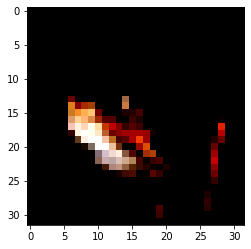

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0532, device='cuda:0')
lossD1
tensor(1.5556, device='cuda:0', grad_fn=<NllLossBackward0>)


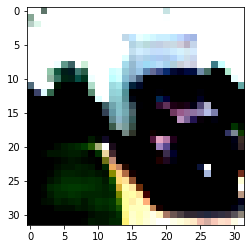

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0439, device='cuda:0')
lossD1
tensor(1.5234, device='cuda:0', grad_fn=<NllLossBackward0>)


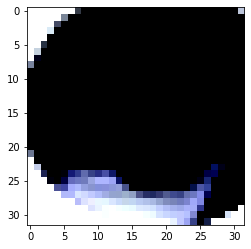

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0399, device='cuda:0')
lossD1
tensor(1.7475, device='cuda:0', grad_fn=<NllLossBackward0>)


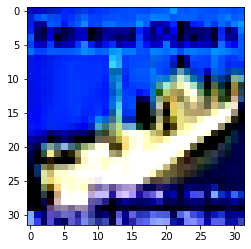

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0156, device='cuda:0')
lossD1
tensor(1.7650, device='cuda:0', grad_fn=<NllLossBackward0>)


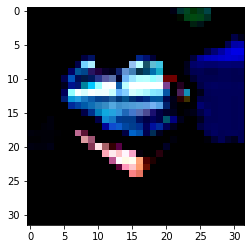

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0905, device='cuda:0')
lossD1
tensor(1.7573, device='cuda:0', grad_fn=<NllLossBackward0>)


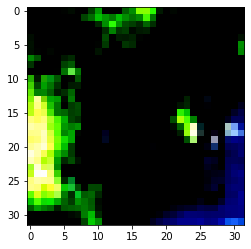

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1001, device='cuda:0')
lossD1
tensor(1.6663, device='cuda:0', grad_fn=<NllLossBackward0>)


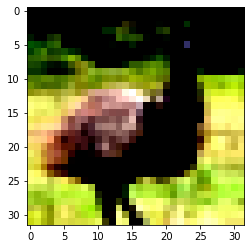

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0477, device='cuda:0')
lossD1
tensor(1.5590, device='cuda:0', grad_fn=<NllLossBackward0>)


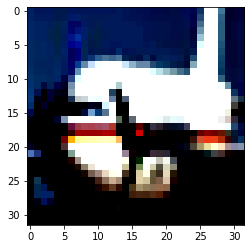

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0157, device='cuda:0')
lossD1
tensor(1.6691, device='cuda:0', grad_fn=<NllLossBackward0>)


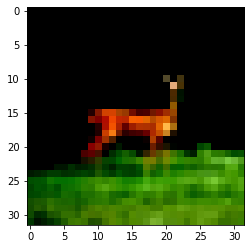

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0355, device='cuda:0')
lossD1
tensor(1.6256, device='cuda:0', grad_fn=<NllLossBackward0>)


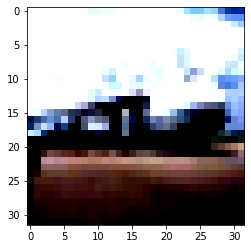

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0196, device='cuda:0')
lossD1
tensor(1.5282, device='cuda:0', grad_fn=<NllLossBackward0>)


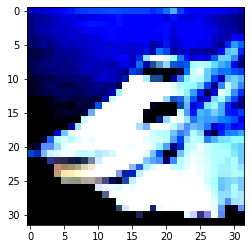

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0506, device='cuda:0')
lossD1
tensor(1.5545, device='cuda:0', grad_fn=<NllLossBackward0>)


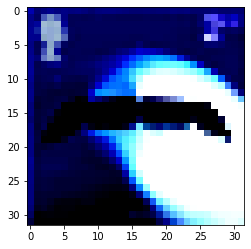

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0596, device='cuda:0')
lossD1
tensor(1.4987, device='cuda:0', grad_fn=<NllLossBackward0>)


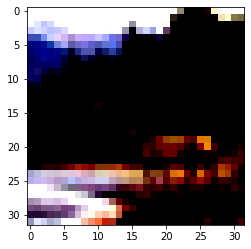

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0767, device='cuda:0')
lossD1
tensor(1.5585, device='cuda:0', grad_fn=<NllLossBackward0>)


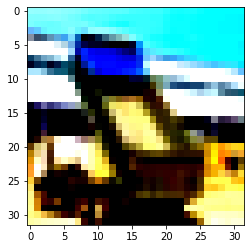

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0083, device='cuda:0')
lossD1
tensor(1.6033, device='cuda:0', grad_fn=<NllLossBackward0>)


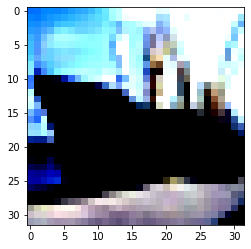

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0839, device='cuda:0')
lossD1
tensor(1.4914, device='cuda:0', grad_fn=<NllLossBackward0>)


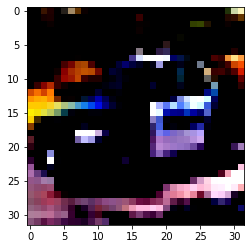

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0433, device='cuda:0')
lossD1
tensor(1.5554, device='cuda:0', grad_fn=<NllLossBackward0>)


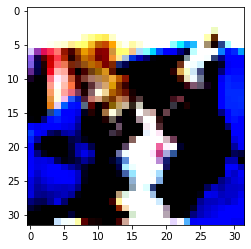

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0232, device='cuda:0')
lossD1
tensor(1.5419, device='cuda:0', grad_fn=<NllLossBackward0>)


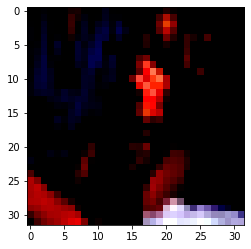

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0260, device='cuda:0')
lossD1
tensor(1.4840, device='cuda:0', grad_fn=<NllLossBackward0>)


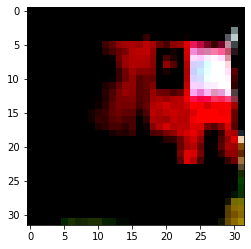

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0468, device='cuda:0')
lossD1
tensor(1.5576, device='cuda:0', grad_fn=<NllLossBackward0>)


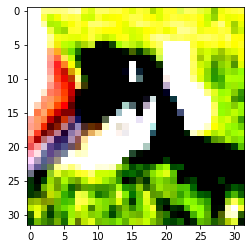

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0007, device='cuda:0')
lossD1
tensor(1.5098, device='cuda:0', grad_fn=<NllLossBackward0>)


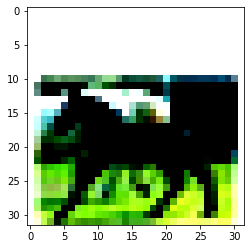

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0641, device='cuda:0')
lossD1
tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)


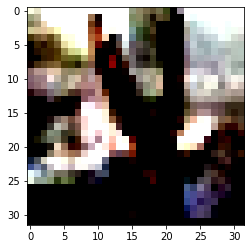

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0364, device='cuda:0')
lossD1
tensor(1.6151, device='cuda:0', grad_fn=<NllLossBackward0>)


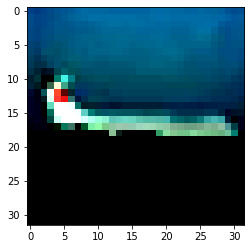

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0288, device='cuda:0')
lossD1
tensor(1.5892, device='cuda:0', grad_fn=<NllLossBackward0>)


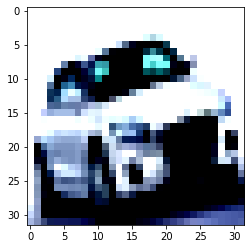

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0181, device='cuda:0')
lossD1
tensor(1.5078, device='cuda:0', grad_fn=<NllLossBackward0>)


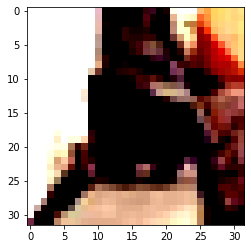

tensor(0.0282, device='cuda:0')
lossD1
tensor(1.4913, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


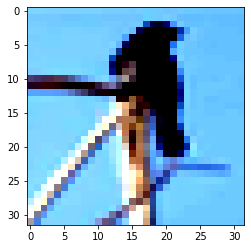

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0121, device='cuda:0')
lossD1
tensor(1.4977, device='cuda:0', grad_fn=<NllLossBackward0>)


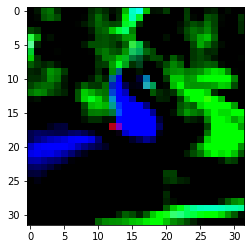

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0412, device='cuda:0')
lossD1
tensor(1.4194, device='cuda:0', grad_fn=<NllLossBackward0>)


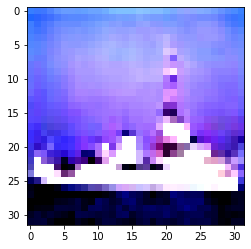

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0257, device='cuda:0')
lossD1
tensor(1.5830, device='cuda:0', grad_fn=<NllLossBackward0>)


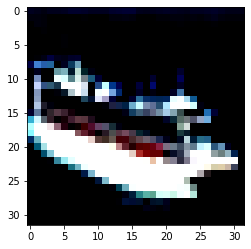

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0110, device='cuda:0')
lossD1
tensor(1.5880, device='cuda:0', grad_fn=<NllLossBackward0>)


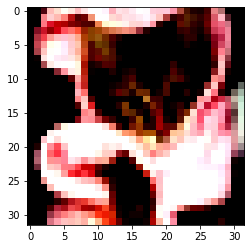

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0325, device='cuda:0')
lossD1
tensor(1.4316, device='cuda:0', grad_fn=<NllLossBackward0>)


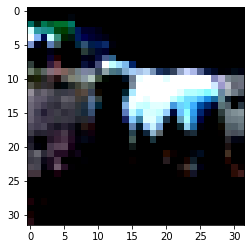

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0344, device='cuda:0')
lossD1
tensor(1.5590, device='cuda:0', grad_fn=<NllLossBackward0>)


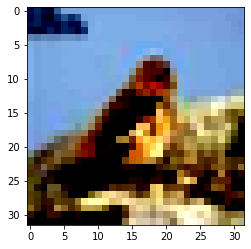

tensor(-0.1021, device='cuda:0')
lossD1
tensor(1.5672, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


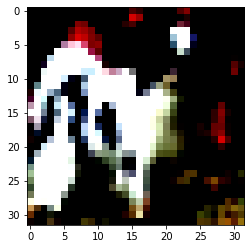

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0049, device='cuda:0')
lossD1
tensor(1.7123, device='cuda:0', grad_fn=<NllLossBackward0>)


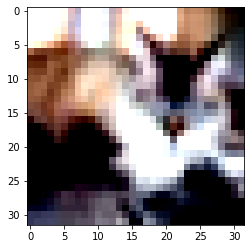

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0068, device='cuda:0')
lossD1
tensor(1.5422, device='cuda:0', grad_fn=<NllLossBackward0>)


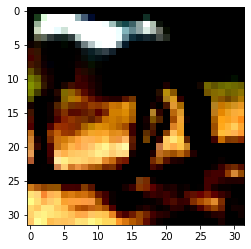

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0326, device='cuda:0')
lossD1
tensor(1.5985, device='cuda:0', grad_fn=<NllLossBackward0>)


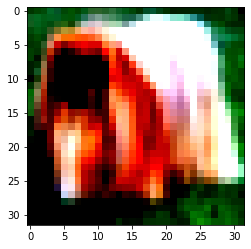

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0370, device='cuda:0')
lossD1
tensor(1.4858, device='cuda:0', grad_fn=<NllLossBackward0>)


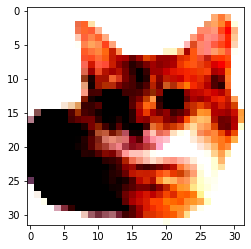

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0308, device='cuda:0')
lossD1
tensor(1.4890, device='cuda:0', grad_fn=<NllLossBackward0>)


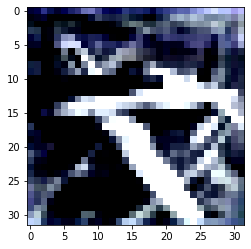

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0353, device='cuda:0')
lossD1
tensor(1.4697, device='cuda:0', grad_fn=<NllLossBackward0>)


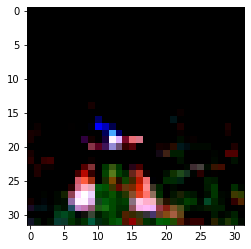

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0435, device='cuda:0')
lossD1
tensor(1.5656, device='cuda:0', grad_fn=<NllLossBackward0>)


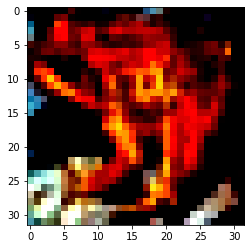

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0236, device='cuda:0')
lossD1
tensor(1.5039, device='cuda:0', grad_fn=<NllLossBackward0>)


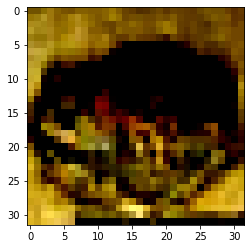

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0109, device='cuda:0')
lossD1
tensor(1.9655, device='cuda:0', grad_fn=<NllLossBackward0>)


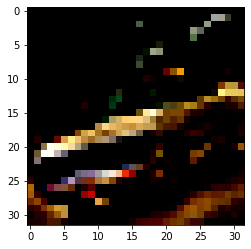

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0201, device='cuda:0')
lossD1
tensor(2.1649, device='cuda:0', grad_fn=<NllLossBackward0>)


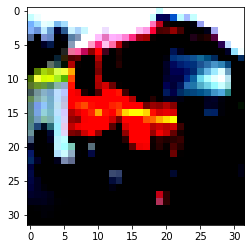

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0528, device='cuda:0')
lossD1
tensor(2.3872, device='cuda:0', grad_fn=<NllLossBackward0>)


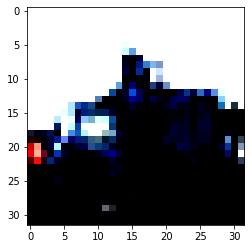

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1085, device='cuda:0')
lossD1
tensor(2.0381, device='cuda:0', grad_fn=<NllLossBackward0>)


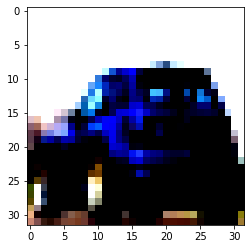

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0692, device='cuda:0')
lossD1
tensor(1.9726, device='cuda:0', grad_fn=<NllLossBackward0>)


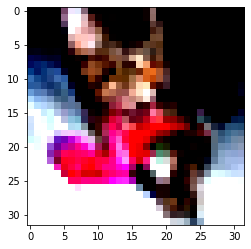

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0345, device='cuda:0')
lossD1
tensor(2.1384, device='cuda:0', grad_fn=<NllLossBackward0>)


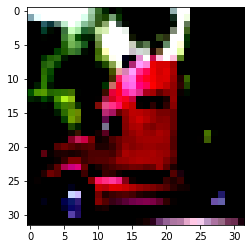

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0033, device='cuda:0')
lossD1
tensor(1.8490, device='cuda:0', grad_fn=<NllLossBackward0>)


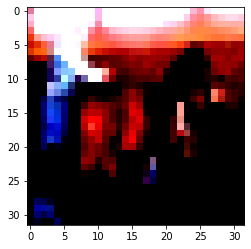

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0121, device='cuda:0')
lossD1
tensor(1.8766, device='cuda:0', grad_fn=<NllLossBackward0>)


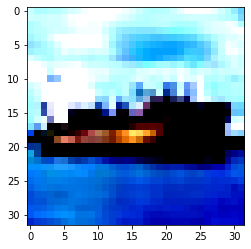

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0133, device='cuda:0')
lossD1
tensor(1.5496, device='cuda:0', grad_fn=<NllLossBackward0>)


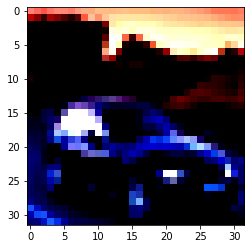

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0380, device='cuda:0')
lossD1
tensor(1.6842, device='cuda:0', grad_fn=<NllLossBackward0>)


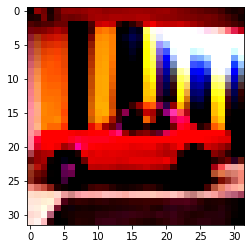

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0187, device='cuda:0')
lossD1
tensor(1.5287, device='cuda:0', grad_fn=<NllLossBackward0>)


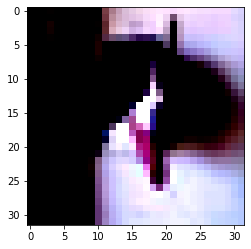

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0189, device='cuda:0')
lossD1
tensor(1.6522, device='cuda:0', grad_fn=<NllLossBackward0>)


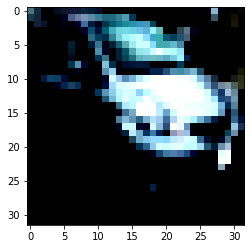

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0653, device='cuda:0')
lossD1
tensor(1.6917, device='cuda:0', grad_fn=<NllLossBackward0>)


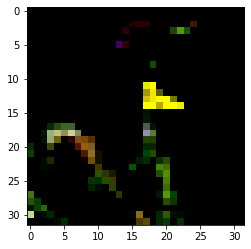

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0187, device='cuda:0')
lossD1
tensor(1.4962, device='cuda:0', grad_fn=<NllLossBackward0>)


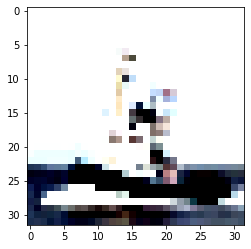

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0263, device='cuda:0')
lossD1
tensor(1.5903, device='cuda:0', grad_fn=<NllLossBackward0>)


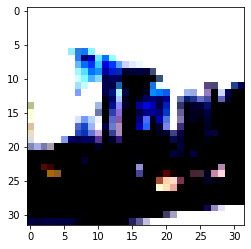

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0272, device='cuda:0')
lossD1
tensor(1.5318, device='cuda:0', grad_fn=<NllLossBackward0>)


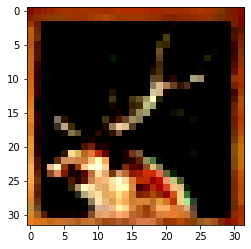

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0252, device='cuda:0')
lossD1
tensor(1.6931, device='cuda:0', grad_fn=<NllLossBackward0>)


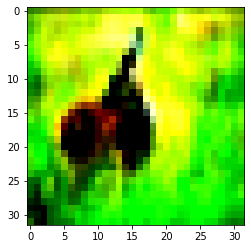

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0411, device='cuda:0')
lossD1
tensor(1.5622, device='cuda:0', grad_fn=<NllLossBackward0>)


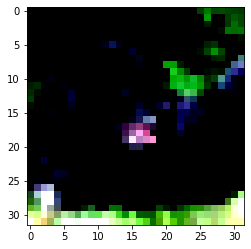

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0530, device='cuda:0')
lossD1
tensor(1.4689, device='cuda:0', grad_fn=<NllLossBackward0>)


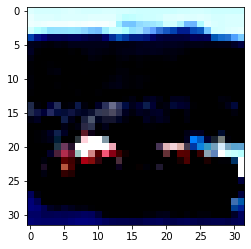

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0310, device='cuda:0')
lossD1
tensor(1.4237, device='cuda:0', grad_fn=<NllLossBackward0>)


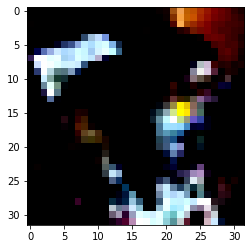

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0162, device='cuda:0')
lossD1
tensor(1.5422, device='cuda:0', grad_fn=<NllLossBackward0>)


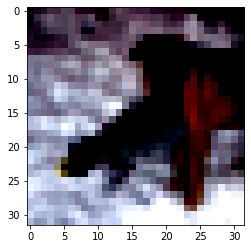

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0332, device='cuda:0')
lossD1
tensor(1.7477, device='cuda:0', grad_fn=<NllLossBackward0>)


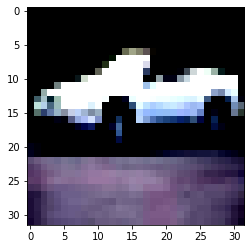

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0223, device='cuda:0')
lossD1
tensor(1.5843, device='cuda:0', grad_fn=<NllLossBackward0>)


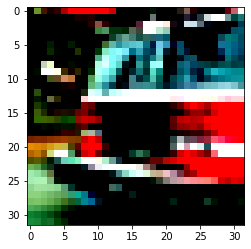

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1112, device='cuda:0')
lossD1
tensor(1.6001, device='cuda:0', grad_fn=<NllLossBackward0>)


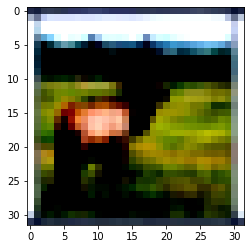

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0014, device='cuda:0')
lossD1
tensor(1.7749, device='cuda:0', grad_fn=<NllLossBackward0>)


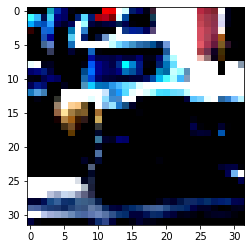

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0087, device='cuda:0')
lossD1
tensor(1.5751, device='cuda:0', grad_fn=<NllLossBackward0>)


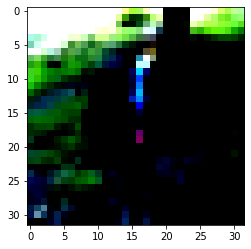

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0230, device='cuda:0')
lossD1
tensor(1.4768, device='cuda:0', grad_fn=<NllLossBackward0>)


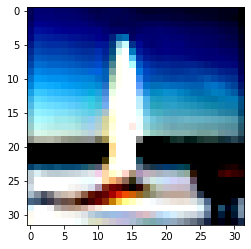

tensor(0.0094, device='cuda:0')
lossD1
tensor(1.5201, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


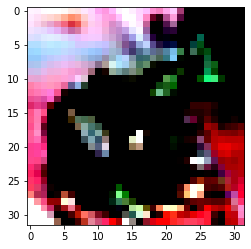

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0163, device='cuda:0')
lossD1
tensor(1.5389, device='cuda:0', grad_fn=<NllLossBackward0>)


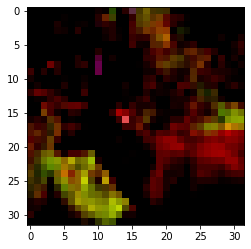

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0187, device='cuda:0')
lossD1
tensor(1.4573, device='cuda:0', grad_fn=<NllLossBackward0>)


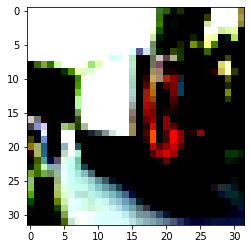

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0384, device='cuda:0')
lossD1
tensor(1.8701, device='cuda:0', grad_fn=<NllLossBackward0>)


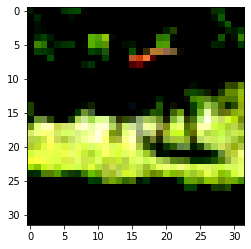

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0072, device='cuda:0')
lossD1
tensor(1.7420, device='cuda:0', grad_fn=<NllLossBackward0>)


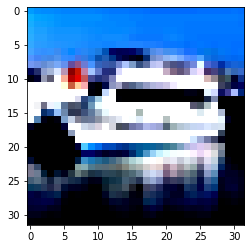

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0490, device='cuda:0')
lossD1
tensor(1.7401, device='cuda:0', grad_fn=<NllLossBackward0>)


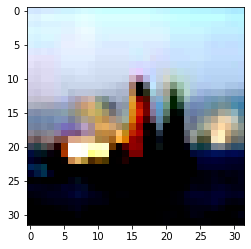

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0453, device='cuda:0')
lossD1
tensor(1.6271, device='cuda:0', grad_fn=<NllLossBackward0>)


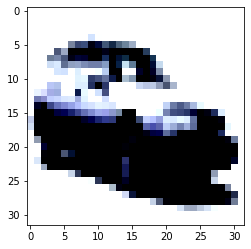

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0610, device='cuda:0')
lossD1
tensor(1.5784, device='cuda:0', grad_fn=<NllLossBackward0>)


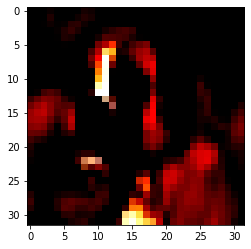

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0336, device='cuda:0')
lossD1
tensor(1.4870, device='cuda:0', grad_fn=<NllLossBackward0>)


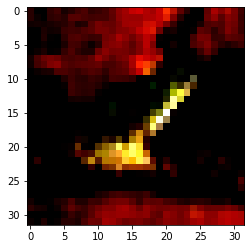

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0193, device='cuda:0')
lossD1
tensor(1.5324, device='cuda:0', grad_fn=<NllLossBackward0>)


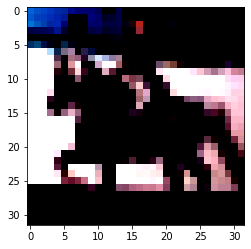

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0074, device='cuda:0')
lossD1
tensor(1.5687, device='cuda:0', grad_fn=<NllLossBackward0>)


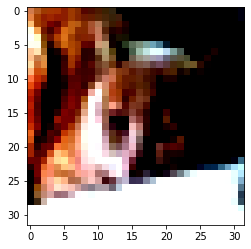

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0555, device='cuda:0')
lossD1
tensor(1.5937, device='cuda:0', grad_fn=<NllLossBackward0>)


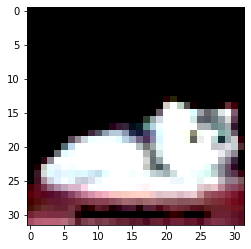

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0605, device='cuda:0')
lossD1
tensor(1.5943, device='cuda:0', grad_fn=<NllLossBackward0>)


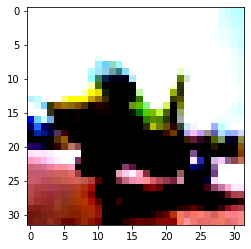

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0028, device='cuda:0')
lossD1
tensor(1.4512, device='cuda:0', grad_fn=<NllLossBackward0>)


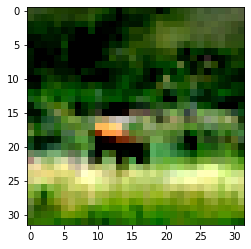

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0253, device='cuda:0')
lossD1
tensor(1.6049, device='cuda:0', grad_fn=<NllLossBackward0>)


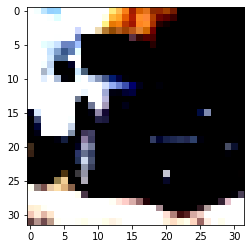

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0277, device='cuda:0')
lossD1
tensor(1.5719, device='cuda:0', grad_fn=<NllLossBackward0>)


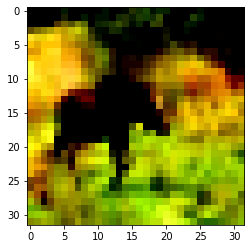

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0553, device='cuda:0')
lossD1
tensor(1.5503, device='cuda:0', grad_fn=<NllLossBackward0>)


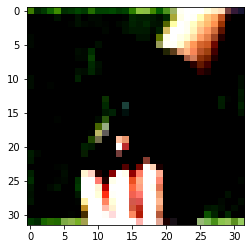

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0642, device='cuda:0')
lossD1
tensor(1.5059, device='cuda:0', grad_fn=<NllLossBackward0>)


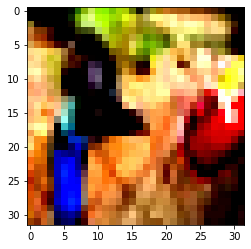

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0918, device='cuda:0')
lossD1
tensor(1.6923, device='cuda:0', grad_fn=<NllLossBackward0>)


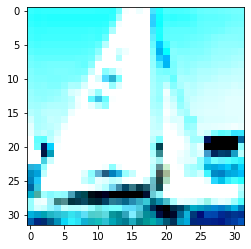

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0114, device='cuda:0')
lossD1
tensor(1.4251, device='cuda:0', grad_fn=<NllLossBackward0>)


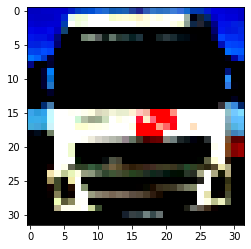

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0183, device='cuda:0')
lossD1
tensor(1.5557, device='cuda:0', grad_fn=<NllLossBackward0>)


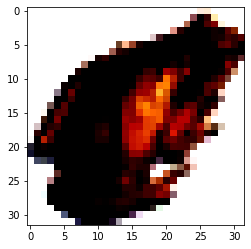

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0740, device='cuda:0')
lossD1
tensor(1.5563, device='cuda:0', grad_fn=<NllLossBackward0>)


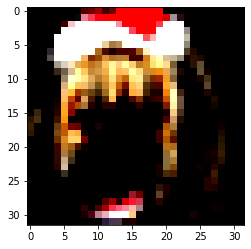

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0290, device='cuda:0')
lossD1
tensor(1.5784, device='cuda:0', grad_fn=<NllLossBackward0>)


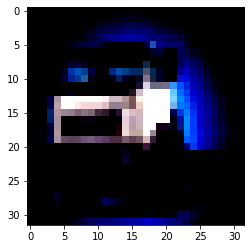

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0081, device='cuda:0')
lossD1
tensor(1.5053, device='cuda:0', grad_fn=<NllLossBackward0>)


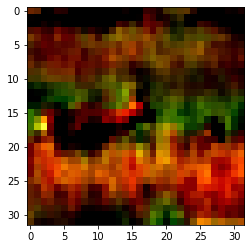

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0839, device='cuda:0')
lossD1
tensor(1.4847, device='cuda:0', grad_fn=<NllLossBackward0>)


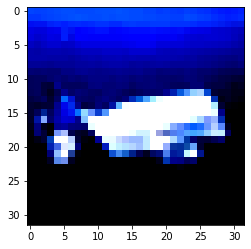

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0475, device='cuda:0')
lossD1
tensor(1.6044, device='cuda:0', grad_fn=<NllLossBackward0>)


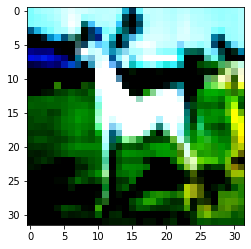

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0284, device='cuda:0')
lossD1
tensor(1.4338, device='cuda:0', grad_fn=<NllLossBackward0>)


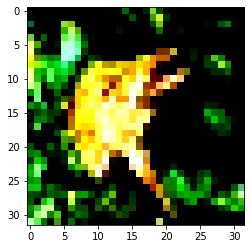

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0186, device='cuda:0')
lossD1
tensor(1.4712, device='cuda:0', grad_fn=<NllLossBackward0>)


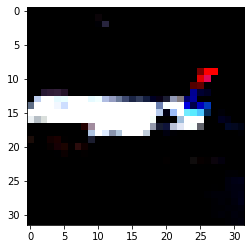

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0696, device='cuda:0')
lossD1
tensor(1.5422, device='cuda:0', grad_fn=<NllLossBackward0>)


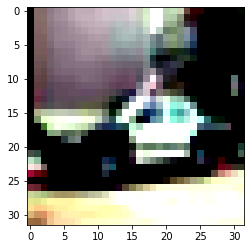

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0474, device='cuda:0')
lossD1
tensor(1.6198, device='cuda:0', grad_fn=<NllLossBackward0>)


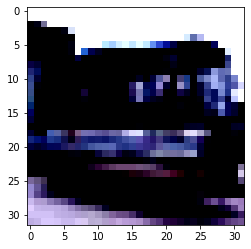

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0118, device='cuda:0')
lossD1
tensor(1.7528, device='cuda:0', grad_fn=<NllLossBackward0>)


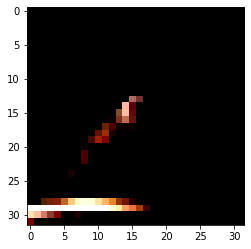

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0011, device='cuda:0')
lossD1
tensor(1.5254, device='cuda:0', grad_fn=<NllLossBackward0>)


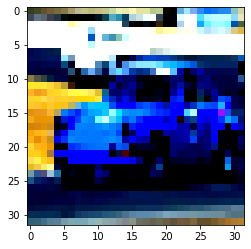

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0301, device='cuda:0')
lossD1
tensor(1.6135, device='cuda:0', grad_fn=<NllLossBackward0>)


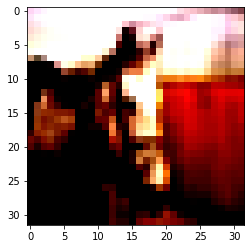

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0068, device='cuda:0')
lossD1
tensor(1.6517, device='cuda:0', grad_fn=<NllLossBackward0>)


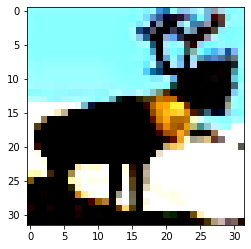

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0132, device='cuda:0')
lossD1
tensor(1.9637, device='cuda:0', grad_fn=<NllLossBackward0>)


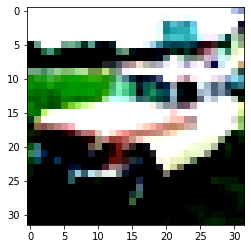

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0096, device='cuda:0')
lossD1
tensor(1.7597, device='cuda:0', grad_fn=<NllLossBackward0>)


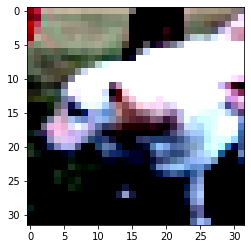

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0007, device='cuda:0')
lossD1
tensor(1.7148, device='cuda:0', grad_fn=<NllLossBackward0>)


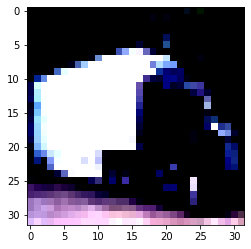

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0126, device='cuda:0')
lossD1
tensor(1.6323, device='cuda:0', grad_fn=<NllLossBackward0>)


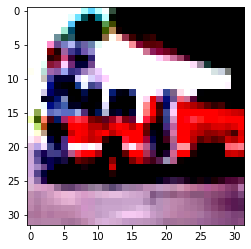

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0305, device='cuda:0')
lossD1
tensor(1.5755, device='cuda:0', grad_fn=<NllLossBackward0>)


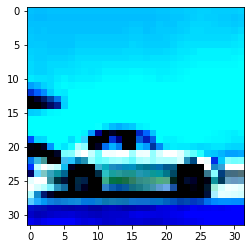

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0113, device='cuda:0')
lossD1
tensor(1.5174, device='cuda:0', grad_fn=<NllLossBackward0>)


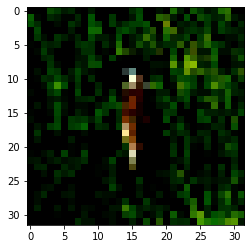

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0020, device='cuda:0')
lossD1
tensor(1.5273, device='cuda:0', grad_fn=<NllLossBackward0>)


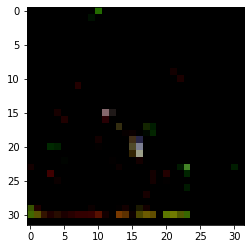

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0088, device='cuda:0')
lossD1
tensor(1.4727, device='cuda:0', grad_fn=<NllLossBackward0>)


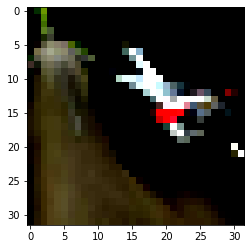

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0318, device='cuda:0')
lossD1
tensor(1.5714, device='cuda:0', grad_fn=<NllLossBackward0>)


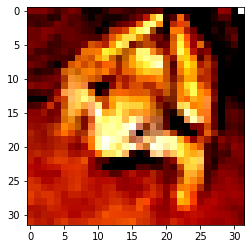

tensor(0.0622, device='cuda:0')
lossD1
tensor(1.5582, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


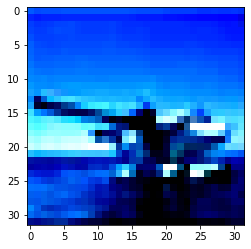

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0567, device='cuda:0')
lossD1
tensor(1.4950, device='cuda:0', grad_fn=<NllLossBackward0>)


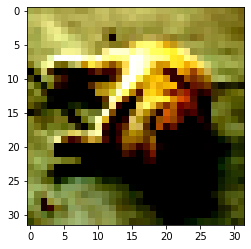

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0061, device='cuda:0')
lossD1
tensor(1.5842, device='cuda:0', grad_fn=<NllLossBackward0>)


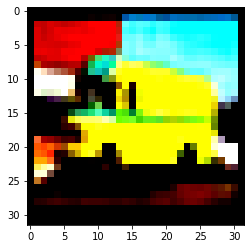

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0601, device='cuda:0')
lossD1
tensor(1.7404, device='cuda:0', grad_fn=<NllLossBackward0>)


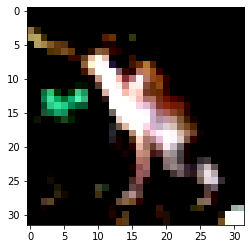

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0102, device='cuda:0')
lossD1
tensor(1.6796, device='cuda:0', grad_fn=<NllLossBackward0>)


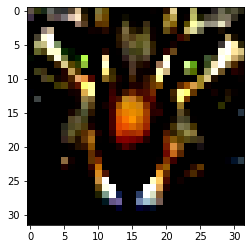

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0258, device='cuda:0')
lossD1
tensor(1.4877, device='cuda:0', grad_fn=<NllLossBackward0>)


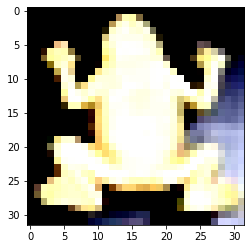

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0189, device='cuda:0')
lossD1
tensor(1.5030, device='cuda:0', grad_fn=<NllLossBackward0>)


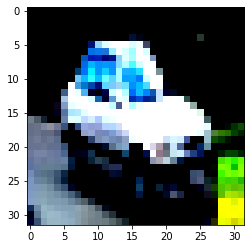

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0489, device='cuda:0')
lossD1
tensor(1.4408, device='cuda:0', grad_fn=<NllLossBackward0>)


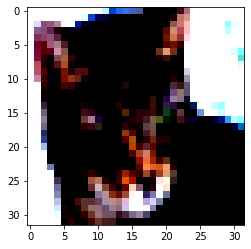

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0648, device='cuda:0')
lossD1
tensor(1.5440, device='cuda:0', grad_fn=<NllLossBackward0>)


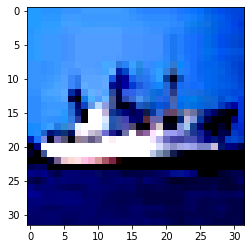

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0264, device='cuda:0')
lossD1
tensor(1.5078, device='cuda:0', grad_fn=<NllLossBackward0>)


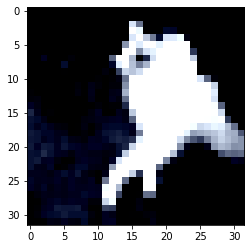

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0310, device='cuda:0')
lossD1
tensor(1.5195, device='cuda:0', grad_fn=<NllLossBackward0>)


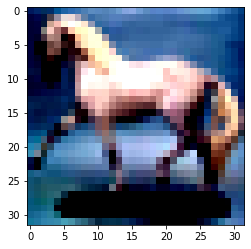

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0138, device='cuda:0')
lossD1
tensor(1.4804, device='cuda:0', grad_fn=<NllLossBackward0>)


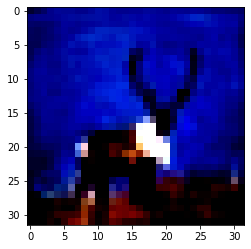

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0113, device='cuda:0')
lossD1
tensor(1.4957, device='cuda:0', grad_fn=<NllLossBackward0>)


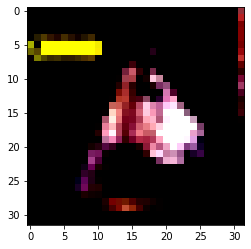

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0934, device='cuda:0')
lossD1
tensor(1.5466, device='cuda:0', grad_fn=<NllLossBackward0>)


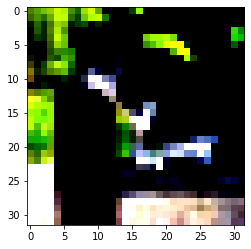

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0470, device='cuda:0')
lossD1
tensor(1.4237, device='cuda:0', grad_fn=<NllLossBackward0>)


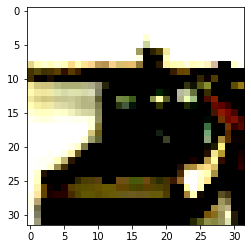

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0711, device='cuda:0')
lossD1
tensor(1.5317, device='cuda:0', grad_fn=<NllLossBackward0>)


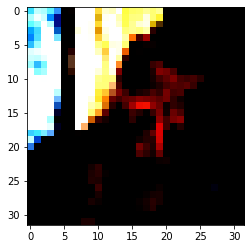

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0973, device='cuda:0')
lossD1
tensor(1.5135, device='cuda:0', grad_fn=<NllLossBackward0>)


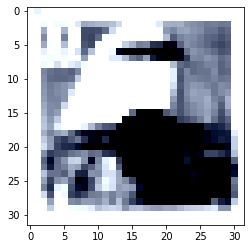

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0250, device='cuda:0')
lossD1
tensor(1.5290, device='cuda:0', grad_fn=<NllLossBackward0>)


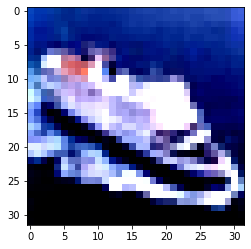

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0187, device='cuda:0')
lossD1
tensor(1.7229, device='cuda:0', grad_fn=<NllLossBackward0>)


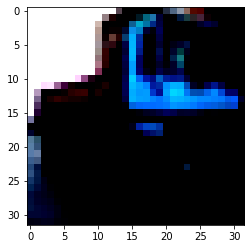

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0071, device='cuda:0')
lossD1
tensor(1.7033, device='cuda:0', grad_fn=<NllLossBackward0>)


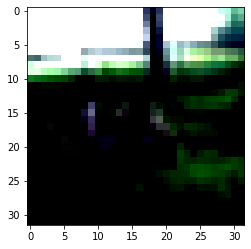

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0523, device='cuda:0')
lossD1
tensor(1.5938, device='cuda:0', grad_fn=<NllLossBackward0>)


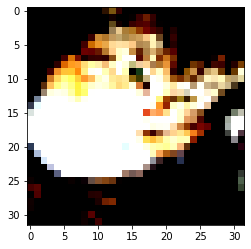

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0231, device='cuda:0')
lossD1
tensor(1.6536, device='cuda:0', grad_fn=<NllLossBackward0>)


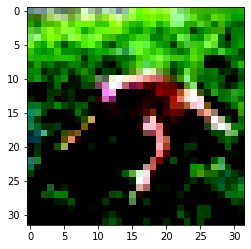

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0032, device='cuda:0')
lossD1
tensor(1.5540, device='cuda:0', grad_fn=<NllLossBackward0>)


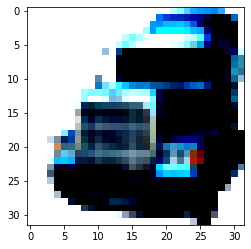

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0416, device='cuda:0')
lossD1
tensor(1.4776, device='cuda:0', grad_fn=<NllLossBackward0>)


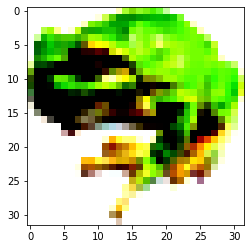

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0242, device='cuda:0')
lossD1
tensor(1.4820, device='cuda:0', grad_fn=<NllLossBackward0>)


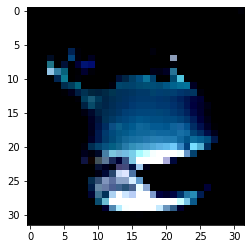

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0339, device='cuda:0')
lossD1
tensor(1.7313, device='cuda:0', grad_fn=<NllLossBackward0>)


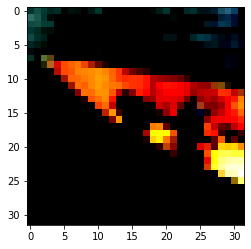

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0342, device='cuda:0')
lossD1
tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)


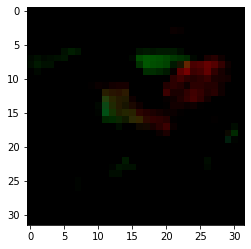

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.2040e-05, device='cuda:0')
lossD1
tensor(1.4780, device='cuda:0', grad_fn=<NllLossBackward0>)


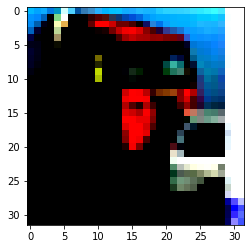

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0234, device='cuda:0')
lossD1
tensor(1.4333, device='cuda:0', grad_fn=<NllLossBackward0>)


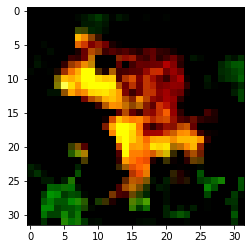

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0195, device='cuda:0')
lossD1
tensor(1.4787, device='cuda:0', grad_fn=<NllLossBackward0>)


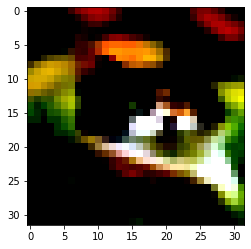

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0401, device='cuda:0')
lossD1
tensor(1.5426, device='cuda:0', grad_fn=<NllLossBackward0>)


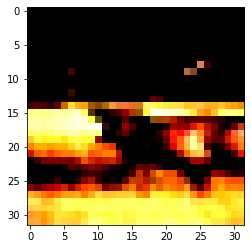

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0545, device='cuda:0')
lossD1
tensor(1.4833, device='cuda:0', grad_fn=<NllLossBackward0>)


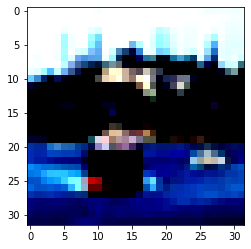

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0195, device='cuda:0')
lossD1
tensor(1.5487, device='cuda:0', grad_fn=<NllLossBackward0>)


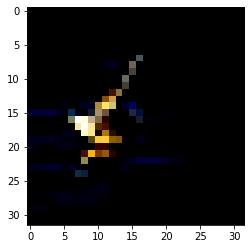

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0176, device='cuda:0')
lossD1
tensor(1.5179, device='cuda:0', grad_fn=<NllLossBackward0>)


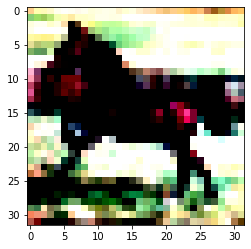

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0115, device='cuda:0')
lossD1
tensor(1.4978, device='cuda:0', grad_fn=<NllLossBackward0>)


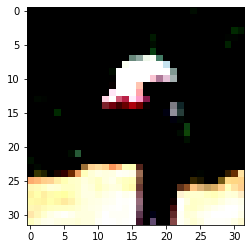

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0155, device='cuda:0')
lossD1
tensor(1.6143, device='cuda:0', grad_fn=<NllLossBackward0>)


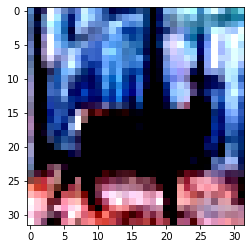

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0502, device='cuda:0')
lossD1
tensor(1.5685, device='cuda:0', grad_fn=<NllLossBackward0>)


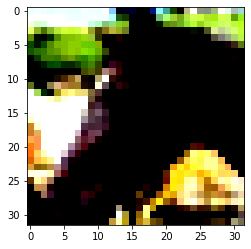

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0162, device='cuda:0')
lossD1
tensor(1.4830, device='cuda:0', grad_fn=<NllLossBackward0>)


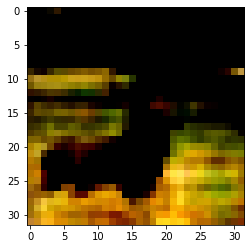

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0082, device='cuda:0')
lossD1
tensor(1.3538, device='cuda:0', grad_fn=<NllLossBackward0>)


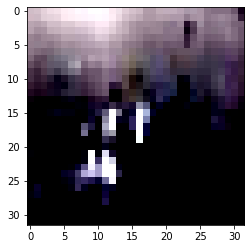

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0584, device='cuda:0')
lossD1
tensor(1.4228, device='cuda:0', grad_fn=<NllLossBackward0>)


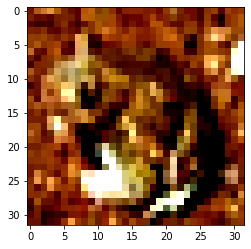

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0322, device='cuda:0')
lossD1
tensor(1.3536, device='cuda:0', grad_fn=<NllLossBackward0>)


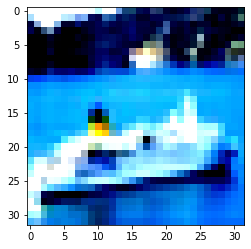

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0186, device='cuda:0')
lossD1
tensor(1.4184, device='cuda:0', grad_fn=<NllLossBackward0>)


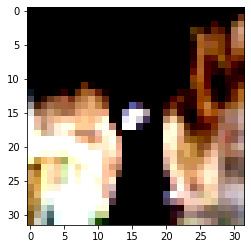

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0358, device='cuda:0')
lossD1
tensor(1.3532, device='cuda:0', grad_fn=<NllLossBackward0>)


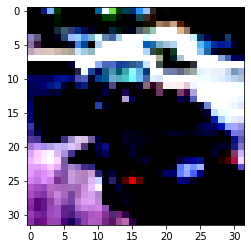

tensor(0.0383, device='cuda:0')
lossD1
tensor(1.4380, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


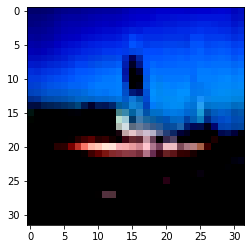

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0292, device='cuda:0')
lossD1
tensor(1.5006, device='cuda:0', grad_fn=<NllLossBackward0>)


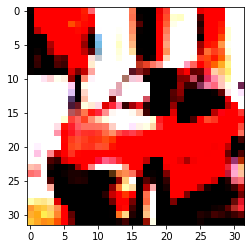

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1125, device='cuda:0')
lossD1
tensor(1.4600, device='cuda:0', grad_fn=<NllLossBackward0>)


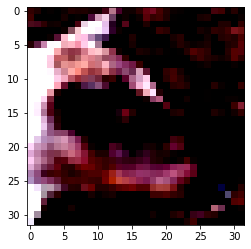

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0632, device='cuda:0')
lossD1
tensor(1.5652, device='cuda:0', grad_fn=<NllLossBackward0>)


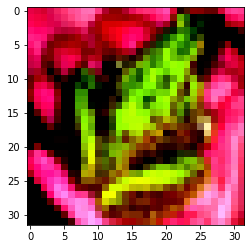

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0701, device='cuda:0')
lossD1
tensor(1.6563, device='cuda:0', grad_fn=<NllLossBackward0>)


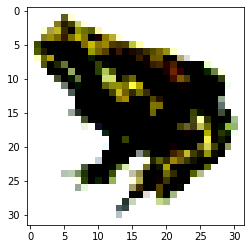

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0764, device='cuda:0')
lossD1
tensor(1.9701, device='cuda:0', grad_fn=<NllLossBackward0>)


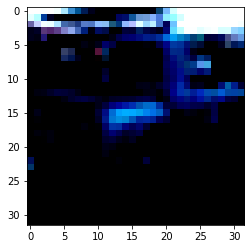

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0006, device='cuda:0')
lossD1
tensor(2.1058, device='cuda:0', grad_fn=<NllLossBackward0>)


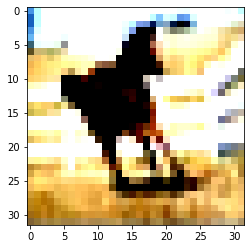

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0362, device='cuda:0')
lossD1
tensor(1.9584, device='cuda:0', grad_fn=<NllLossBackward0>)


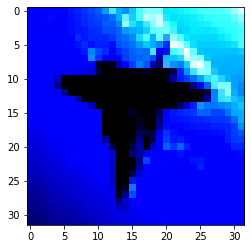

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0116, device='cuda:0')
lossD1
tensor(1.8244, device='cuda:0', grad_fn=<NllLossBackward0>)


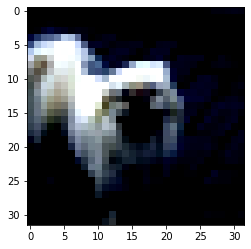

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0043, device='cuda:0')
lossD1
tensor(1.7348, device='cuda:0', grad_fn=<NllLossBackward0>)


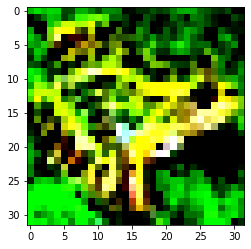

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0151, device='cuda:0')
lossD1
tensor(1.6465, device='cuda:0', grad_fn=<NllLossBackward0>)


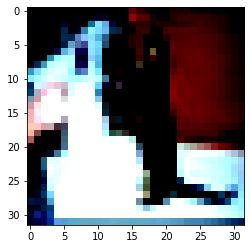

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0150, device='cuda:0')
lossD1
tensor(1.7541, device='cuda:0', grad_fn=<NllLossBackward0>)


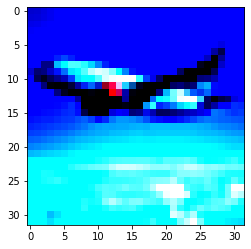

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0134, device='cuda:0')
lossD1
tensor(1.6585, device='cuda:0', grad_fn=<NllLossBackward0>)


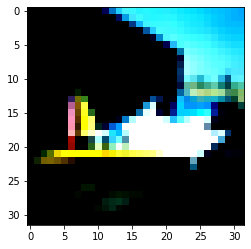

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0413, device='cuda:0')
lossD1
tensor(1.7038, device='cuda:0', grad_fn=<NllLossBackward0>)


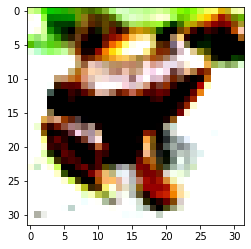

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0008, device='cuda:0')
lossD1
tensor(1.6312, device='cuda:0', grad_fn=<NllLossBackward0>)


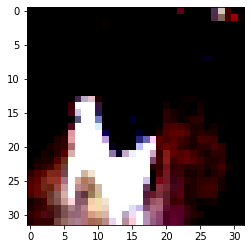

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0168, device='cuda:0')
lossD1
tensor(1.3685, device='cuda:0', grad_fn=<NllLossBackward0>)


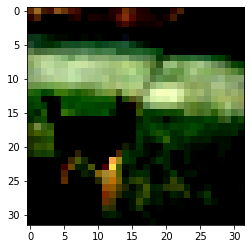

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0626, device='cuda:0')
lossD1
tensor(1.5759, device='cuda:0', grad_fn=<NllLossBackward0>)


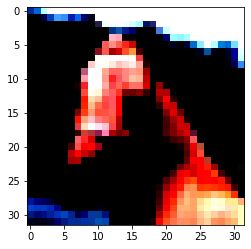

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0600, device='cuda:0')
lossD1
tensor(1.4545, device='cuda:0', grad_fn=<NllLossBackward0>)


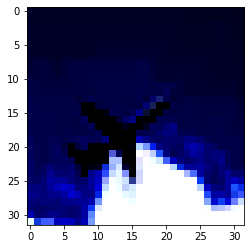

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0590, device='cuda:0')
lossD1
tensor(1.5909, device='cuda:0', grad_fn=<NllLossBackward0>)


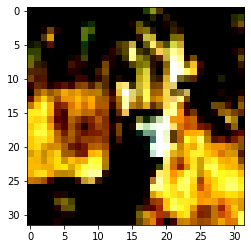

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0606, device='cuda:0')
lossD1
tensor(1.5660, device='cuda:0', grad_fn=<NllLossBackward0>)


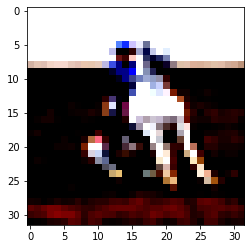

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0079, device='cuda:0')
lossD1
tensor(1.4347, device='cuda:0', grad_fn=<NllLossBackward0>)


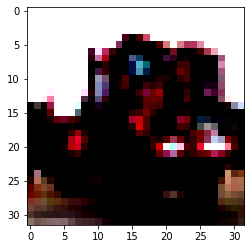

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0187, device='cuda:0')
lossD1
tensor(1.4738, device='cuda:0', grad_fn=<NllLossBackward0>)


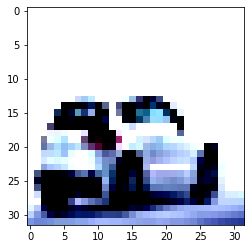

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0513, device='cuda:0')
lossD1
tensor(1.5299, device='cuda:0', grad_fn=<NllLossBackward0>)


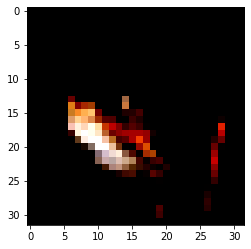

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0426, device='cuda:0')
lossD1
tensor(1.5191, device='cuda:0', grad_fn=<NllLossBackward0>)


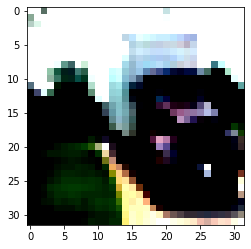

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0402, device='cuda:0')
lossD1
tensor(1.5468, device='cuda:0', grad_fn=<NllLossBackward0>)


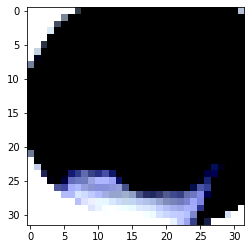

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0323, device='cuda:0')
lossD1
tensor(1.5962, device='cuda:0', grad_fn=<NllLossBackward0>)


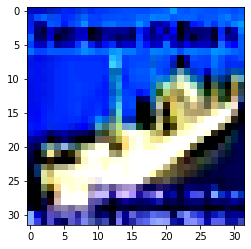

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0439, device='cuda:0')
lossD1
tensor(1.5299, device='cuda:0', grad_fn=<NllLossBackward0>)


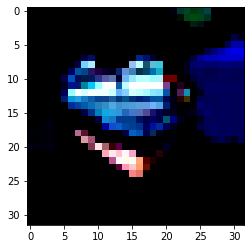

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0465, device='cuda:0')
lossD1
tensor(1.5959, device='cuda:0', grad_fn=<NllLossBackward0>)


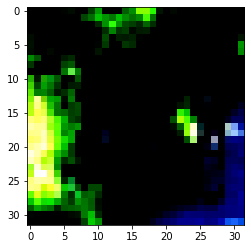

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0374, device='cuda:0')
lossD1
tensor(1.5866, device='cuda:0', grad_fn=<NllLossBackward0>)


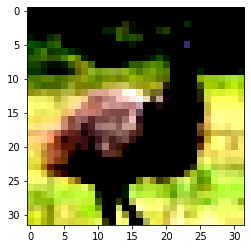

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0279, device='cuda:0')
lossD1
tensor(1.4392, device='cuda:0', grad_fn=<NllLossBackward0>)


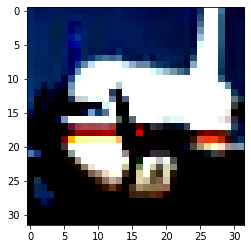

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0062, device='cuda:0')
lossD1
tensor(1.4763, device='cuda:0', grad_fn=<NllLossBackward0>)


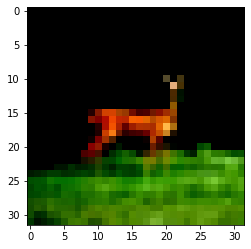

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0504, device='cuda:0')
lossD1
tensor(1.5948, device='cuda:0', grad_fn=<NllLossBackward0>)


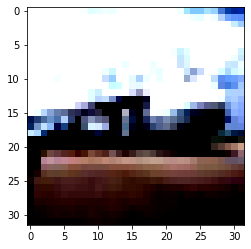

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0546, device='cuda:0')
lossD1
tensor(2.2482, device='cuda:0', grad_fn=<NllLossBackward0>)


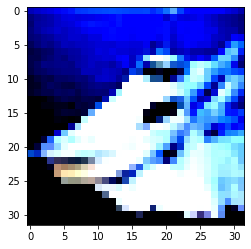

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1072, device='cuda:0')
lossD1
tensor(1.9264, device='cuda:0', grad_fn=<NllLossBackward0>)


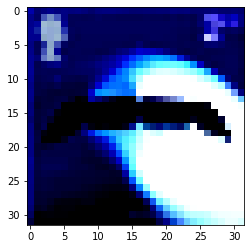

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0728, device='cuda:0')
lossD1
tensor(1.7224, device='cuda:0', grad_fn=<NllLossBackward0>)


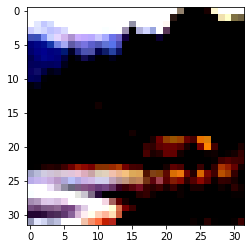

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0922, device='cuda:0')
lossD1
tensor(1.8071, device='cuda:0', grad_fn=<NllLossBackward0>)


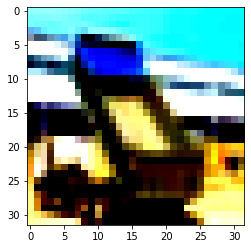

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0500, device='cuda:0')
lossD1
tensor(1.9609, device='cuda:0', grad_fn=<NllLossBackward0>)


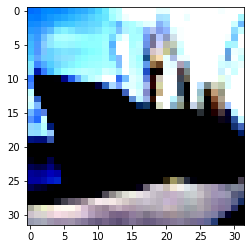

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0680, device='cuda:0')
lossD1
tensor(1.8748, device='cuda:0', grad_fn=<NllLossBackward0>)


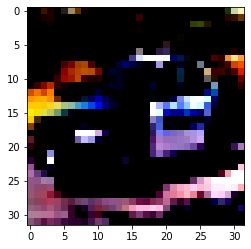

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0301, device='cuda:0')
lossD1
tensor(1.9455, device='cuda:0', grad_fn=<NllLossBackward0>)


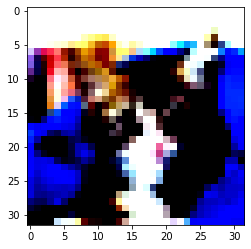

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0009, device='cuda:0')
lossD1
tensor(1.7970, device='cuda:0', grad_fn=<NllLossBackward0>)


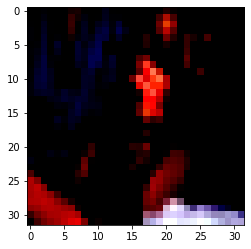

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0062, device='cuda:0')
lossD1
tensor(1.6652, device='cuda:0', grad_fn=<NllLossBackward0>)


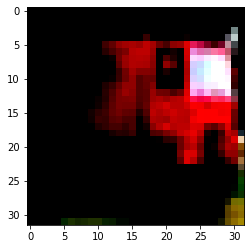

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0208, device='cuda:0')
lossD1
tensor(1.7355, device='cuda:0', grad_fn=<NllLossBackward0>)


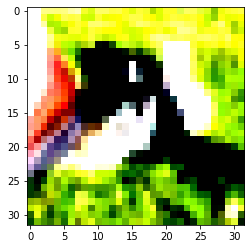

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0107, device='cuda:0')
lossD1
tensor(1.5842, device='cuda:0', grad_fn=<NllLossBackward0>)


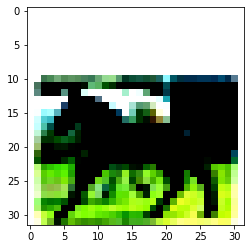

tensor(-0.0584, device='cuda:0')
lossD1
tensor(1.6202, device='cuda:0', grad_fn=<NllLossBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


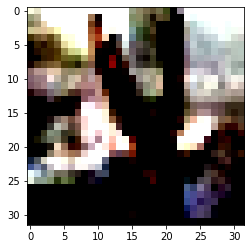

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0116, device='cuda:0')
lossD1
tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)


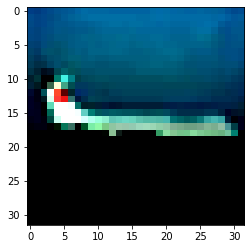

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0061, device='cuda:0')
lossD1
tensor(1.6654, device='cuda:0', grad_fn=<NllLossBackward0>)


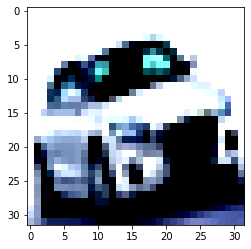

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0142, device='cuda:0')
lossD1
tensor(1.6141, device='cuda:0', grad_fn=<NllLossBackward0>)


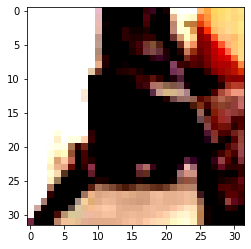

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0728, device='cuda:0')
lossD1
tensor(1.6926, device='cuda:0', grad_fn=<NllLossBackward0>)


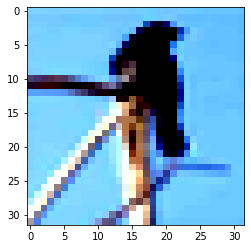

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0274, device='cuda:0')
lossD1
tensor(1.7102, device='cuda:0', grad_fn=<NllLossBackward0>)


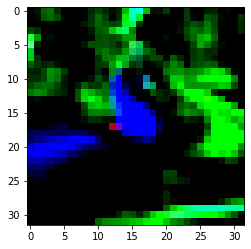

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0139, device='cuda:0')
lossD1
tensor(1.5476, device='cuda:0', grad_fn=<NllLossBackward0>)


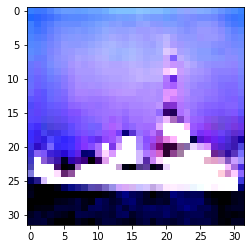

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0114, device='cuda:0')
lossD1
tensor(1.4977, device='cuda:0', grad_fn=<NllLossBackward0>)


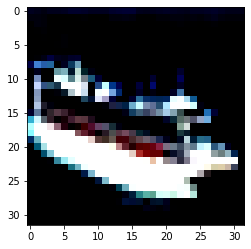

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0070, device='cuda:0')
lossD1
tensor(1.4507, device='cuda:0', grad_fn=<NllLossBackward0>)


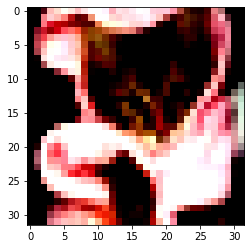

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0458, device='cuda:0')
lossD1
tensor(1.4730, device='cuda:0', grad_fn=<NllLossBackward0>)


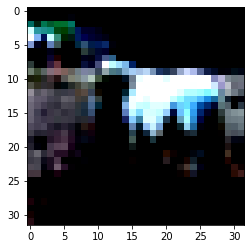

tensor(-0.0223, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lossD1
tensor(1.4568, device='cuda:0', grad_fn=<NllLossBackward0>)


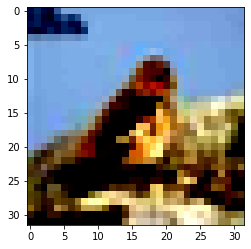

tensor(-0.1302, device='cuda:0')
lossD1
tensor(1.5727, device='cuda:0', grad_fn=<NllLossBackward0>)


In [40]:
dm = CIFARDataModule()
model = GANModule(*dm.size())
trainer = pl.Trainer(gpus=AVAIL_GPUS, max_epochs=5, progress_bar_refresh_rate=20)
trainer.fit(model, dm)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [ ]:
import numpy as np